In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import gym
import random
import time

In [2]:
from torch import nn 
from tqdm import tqdm

### For discrete action space

In [8]:
class CEM(nn.Module):
    def __init__(self, state_dim, action_n):
        super().__init__()
        self.state_dim = state_dim
        self.action_n = action_n

        self.network = nn.Sequential(
                            nn.Linear(self.state_dim, 64),
                            nn.Tanh(),
                            #nn.Linear(512, 256),
                            #nn.ReLU(),
                            nn.Linear(64, self.action_n),
                            nn.Softmax() )
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=0.003)
        self.loss = nn.CrossEntropyLoss()
        
        
    def forward(self, state):
        return self.network(state)
        
    def get_action(self, state):
        state = torch.FloatTensor(state)
        action_prob = self.forward(state).detach().numpy()
        action = np.random.choice(np.arange(action_n), p=action_prob)
        
        return action
    
    def update_policy(self, elite_trajectories):
        elite_states =[]
        elite_actions = []
        
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        
        elite_states = torch.FloatTensor(elite_states)
        elite_actions = torch.LongTensor(elite_actions)
        
        loss = self.loss(self.forward(elite_states), elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        
    def get_trajectory(self, env, trajectory_len, vizualize=False):
        trajectory = {'states': [], 'actions': [], 'total_reward': 0}
        
        state = env.reset()
        for i in range(trajectory_len):
            trajectory['states'].append(state)
            
            action = self.get_action(state)
            trajectory['actions'].append(action)
            state, reward, done, _ = env.step(action)
            
            trajectory['total_reward'] += reward
            
            if done:
                break
                
            if vizualize:
                env.render()
                time.sleep(0.05)
                
        return trajectory
            
    def get_elite_trajectories(self, trajectories, q_param):
        total_rewards = [trj['total_reward'] for trj in trajectories]
        quantile = np.quantile(total_rewards, q=q_param)
        return [trajectory for trajectory in trajectories if trajectory['total_reward'] >= quantile]
    
    
    def train(self, env, epochs, trajectory_len, trajectory_n, q_param, learning_rate=0.01):
        
        history = []
        
        for i in tqdm(range(epochs)):
            trajectories = [self.get_trajectory(env, trajectory_len) for _ in range(trajectory_n)]
            
            mean_total_reward = np.mean([trj['total_reward'] for trj in trajectories])
            history.append(mean_total_reward)
            
            elite = self.get_elite_trajectories(trajectories, q_param)
            
            if len(elite) > 0:
                self.update_policy(elite)
                
            print(f'epoch = {i}, \n total reward = {mean_total_reward}')
            
        return history
    
            
    def play(self, env, trajectory_len):
        self.get_trajectory(env, trajectory_len, vizualize=True)
        
    def save(self, path):
        torch.save(self.network, path)
        
    def load(self, path):
        self.network = torch.load(path)
        self.network.eval()
    

In [20]:
env = gym.make('Acrobot-v1')

state_dim = 6
action_n = 3

epochs = 150
trajectory_len = 500
trajectory_n = 200
q_param = 0.8

agent = CEM(state_dim, action_n)

In [9]:
logs = agent.train(env, epochs, trajectory_len, trajectory_n, q_param)

  1%|▌                                                                               | 1/150 [00:37<1:32:23, 37.20s/it]

epoch = 0, 
 total reward = -283.98


  1%|█                                                                               | 2/150 [01:02<1:14:55, 30.38s/it]

epoch = 1, 
 total reward = -229.25


  2%|█▌                                                                              | 3/150 [01:26<1:06:47, 27.26s/it]

epoch = 2, 
 total reward = -190.05


  3%|██▏                                                                             | 4/150 [01:50<1:02:52, 25.84s/it]

epoch = 3, 
 total reward = -173.985


  3%|██▋                                                                               | 5/150 [02:09<57:16, 23.70s/it]

epoch = 4, 
 total reward = -156.785


  4%|███▎                                                                              | 6/150 [02:26<51:14, 21.35s/it]

epoch = 5, 
 total reward = -142.37


  5%|███▊                                                                              | 7/150 [02:41<45:44, 19.19s/it]

epoch = 6, 
 total reward = -132.665


  5%|████▎                                                                             | 8/150 [02:55<41:21, 17.48s/it]

epoch = 7, 
 total reward = -117.76


  6%|████▉                                                                             | 9/150 [03:09<38:45, 16.49s/it]

epoch = 8, 
 total reward = -117.965


  7%|█████▍                                                                           | 10/150 [03:25<37:46, 16.19s/it]

epoch = 9, 
 total reward = -111.735


  7%|█████▉                                                                           | 11/150 [03:41<37:22, 16.14s/it]

epoch = 10, 
 total reward = -112.84


  8%|██████▍                                                                          | 12/150 [03:55<35:55, 15.62s/it]

epoch = 11, 
 total reward = -105.615


  9%|███████                                                                          | 13/150 [04:09<34:42, 15.20s/it]

epoch = 12, 
 total reward = -106.51


  9%|███████▌                                                                         | 14/150 [04:25<34:56, 15.41s/it]

epoch = 13, 
 total reward = -101.735


 10%|████████                                                                         | 15/150 [04:38<32:57, 14.65s/it]

epoch = 14, 
 total reward = -99.575


 11%|████████▋                                                                        | 16/150 [04:50<31:07, 13.94s/it]

epoch = 15, 
 total reward = -97.895


 11%|█████████▏                                                                       | 17/150 [05:02<29:41, 13.40s/it]

epoch = 16, 
 total reward = -94.575


 12%|█████████▋                                                                       | 18/150 [05:16<29:13, 13.29s/it]

epoch = 17, 
 total reward = -93.225


 13%|██████████▎                                                                      | 19/150 [05:30<29:31, 13.52s/it]

epoch = 18, 
 total reward = -94.49


 13%|██████████▊                                                                      | 20/150 [05:44<29:42, 13.71s/it]

epoch = 19, 
 total reward = -96.775


 14%|███████████▎                                                                     | 21/150 [05:58<29:43, 13.83s/it]

epoch = 20, 
 total reward = -93.205


 15%|███████████▉                                                                     | 22/150 [06:11<28:52, 13.54s/it]

epoch = 21, 
 total reward = -92.425


 15%|████████████▍                                                                    | 23/150 [06:23<27:37, 13.05s/it]

epoch = 22, 
 total reward = -87.075


 16%|████████████▉                                                                    | 24/150 [06:33<25:45, 12.27s/it]

epoch = 23, 
 total reward = -90.16


 17%|█████████████▌                                                                   | 25/150 [06:43<23:59, 11.52s/it]

epoch = 24, 
 total reward = -88.22


 17%|██████████████                                                                   | 26/150 [06:54<23:44, 11.49s/it]

epoch = 25, 
 total reward = -89.945


 18%|██████████████▌                                                                  | 27/150 [07:07<24:02, 11.73s/it]

epoch = 26, 
 total reward = -86.165


 19%|███████████████                                                                  | 28/150 [07:19<24:21, 11.98s/it]

epoch = 27, 
 total reward = -87.84


 19%|███████████████▋                                                                 | 29/150 [07:28<22:21, 11.09s/it]

epoch = 28, 
 total reward = -85.115


 20%|████████████████▏                                                                | 30/150 [07:37<20:55, 10.47s/it]

epoch = 29, 
 total reward = -87.755


 21%|████████████████▋                                                                | 31/150 [07:49<21:45, 10.97s/it]

epoch = 30, 
 total reward = -85.68


 21%|█████████████████▎                                                               | 32/150 [08:02<22:34, 11.48s/it]

epoch = 31, 
 total reward = -88.31


 22%|█████████████████▊                                                               | 33/150 [08:17<24:17, 12.46s/it]

epoch = 32, 
 total reward = -88.185


 23%|██████████████████▎                                                              | 34/150 [08:28<23:25, 12.12s/it]

epoch = 33, 
 total reward = -87.56


 23%|██████████████████▉                                                              | 35/150 [08:40<23:10, 12.09s/it]

epoch = 34, 
 total reward = -86.485


 24%|███████████████████▍                                                             | 36/150 [08:52<23:01, 12.12s/it]

epoch = 35, 
 total reward = -89.17


 25%|███████████████████▉                                                             | 37/150 [09:07<24:16, 12.89s/it]

epoch = 36, 
 total reward = -88.815


 25%|████████████████████▌                                                            | 38/150 [09:19<23:39, 12.68s/it]

epoch = 37, 
 total reward = -87.85


 26%|█████████████████████                                                            | 39/150 [09:29<21:47, 11.78s/it]

epoch = 38, 
 total reward = -84.94


 27%|█████████████████████▌                                                           | 40/150 [09:39<20:59, 11.45s/it]

epoch = 39, 
 total reward = -84.42


 27%|██████████████████████▏                                                          | 41/150 [09:51<21:01, 11.57s/it]

epoch = 40, 
 total reward = -85.86


 28%|██████████████████████▋                                                          | 42/150 [10:02<20:12, 11.23s/it]

epoch = 41, 
 total reward = -85.065


 29%|███████████████████████▏                                                         | 43/150 [10:13<20:03, 11.25s/it]

epoch = 42, 
 total reward = -89.065


 29%|███████████████████████▊                                                         | 44/150 [10:22<18:43, 10.60s/it]

epoch = 43, 
 total reward = -85.95


 30%|████████████████████████▎                                                        | 45/150 [10:31<17:40, 10.10s/it]

epoch = 44, 
 total reward = -85.655


 31%|████████████████████████▊                                                        | 46/150 [10:40<16:46,  9.68s/it]

epoch = 45, 
 total reward = -85.75


 31%|█████████████████████████▍                                                       | 47/150 [10:51<17:35, 10.25s/it]

epoch = 46, 
 total reward = -85.29


 32%|█████████████████████████▉                                                       | 48/150 [11:02<17:25, 10.25s/it]

epoch = 47, 
 total reward = -83.7


 33%|██████████████████████████▍                                                      | 49/150 [11:12<17:07, 10.18s/it]

epoch = 48, 
 total reward = -82.74


 33%|███████████████████████████                                                      | 50/150 [11:23<17:23, 10.43s/it]

epoch = 49, 
 total reward = -87.95


 34%|███████████████████████████▌                                                     | 51/150 [11:34<17:32, 10.63s/it]

epoch = 50, 
 total reward = -89.59


 35%|████████████████████████████                                                     | 52/150 [11:44<16:59, 10.41s/it]

epoch = 51, 
 total reward = -85.235


 35%|████████████████████████████▌                                                    | 53/150 [11:54<16:41, 10.33s/it]

epoch = 52, 
 total reward = -86.475


 36%|█████████████████████████████▏                                                   | 54/150 [12:03<16:05, 10.05s/it]

epoch = 53, 
 total reward = -86.615


 37%|█████████████████████████████▋                                                   | 55/150 [12:14<16:28, 10.40s/it]

epoch = 54, 
 total reward = -87.195


 37%|██████████████████████████████▏                                                  | 56/150 [12:26<16:57, 10.82s/it]

epoch = 55, 
 total reward = -86.045


 38%|██████████████████████████████▊                                                  | 57/150 [12:36<16:16, 10.50s/it]

epoch = 56, 
 total reward = -85.835


 39%|███████████████████████████████▎                                                 | 58/150 [12:49<17:16, 11.27s/it]

epoch = 57, 
 total reward = -83.485


 39%|███████████████████████████████▊                                                 | 59/150 [13:01<17:35, 11.59s/it]

epoch = 58, 
 total reward = -82.8


 40%|████████████████████████████████▍                                                | 60/150 [13:13<17:16, 11.52s/it]

epoch = 59, 
 total reward = -85.16


 41%|████████████████████████████████▉                                                | 61/150 [13:27<18:15, 12.30s/it]

epoch = 60, 
 total reward = -86.495


 41%|█████████████████████████████████▍                                               | 62/150 [13:39<17:56, 12.23s/it]

epoch = 61, 
 total reward = -84.55


 42%|██████████████████████████████████                                               | 63/150 [13:47<16:04, 11.09s/it]

epoch = 62, 
 total reward = -82.985


 43%|██████████████████████████████████▌                                              | 64/150 [13:56<14:56, 10.42s/it]

epoch = 63, 
 total reward = -85.985


 43%|███████████████████████████████████                                              | 65/150 [14:09<15:57, 11.26s/it]

epoch = 64, 
 total reward = -86.995


 44%|███████████████████████████████████▋                                             | 66/150 [14:23<16:52, 12.05s/it]

epoch = 65, 
 total reward = -87.455


 45%|████████████████████████████████████▏                                            | 67/150 [14:36<16:47, 12.14s/it]

epoch = 66, 
 total reward = -89.505


 45%|████████████████████████████████████▋                                            | 68/150 [14:47<16:15, 11.90s/it]

epoch = 67, 
 total reward = -85.045


 46%|█████████████████████████████████████▎                                           | 69/150 [14:59<15:57, 11.83s/it]

epoch = 68, 
 total reward = -90.365


 47%|█████████████████████████████████████▊                                           | 70/150 [15:10<15:36, 11.70s/it]

epoch = 69, 
 total reward = -87.24


 47%|██████████████████████████████████████▎                                          | 71/150 [15:22<15:32, 11.81s/it]

epoch = 70, 
 total reward = -87.15


 48%|██████████████████████████████████████▉                                          | 72/150 [15:32<14:45, 11.35s/it]

epoch = 71, 
 total reward = -86.525


 49%|███████████████████████████████████████▍                                         | 73/150 [15:43<14:11, 11.05s/it]

epoch = 72, 
 total reward = -86.75


 49%|███████████████████████████████████████▉                                         | 74/150 [15:55<14:26, 11.40s/it]

epoch = 73, 
 total reward = -89.67


 50%|████████████████████████████████████████▌                                        | 75/150 [16:08<15:00, 12.01s/it]

epoch = 74, 
 total reward = -87.3


 51%|█████████████████████████████████████████                                        | 76/150 [16:21<14:55, 12.10s/it]

epoch = 75, 
 total reward = -87.405


 51%|█████████████████████████████████████████▌                                       | 77/150 [16:33<14:55, 12.27s/it]

epoch = 76, 
 total reward = -91.135


 52%|██████████████████████████████████████████                                       | 78/150 [16:47<15:15, 12.71s/it]

epoch = 77, 
 total reward = -86.96


 53%|██████████████████████████████████████████▋                                      | 79/150 [16:57<14:07, 11.93s/it]

epoch = 78, 
 total reward = -88.105


 53%|███████████████████████████████████████████▏                                     | 80/150 [17:12<14:47, 12.68s/it]

epoch = 79, 
 total reward = -88.505


 54%|███████████████████████████████████████████▋                                     | 81/150 [17:26<15:10, 13.20s/it]

epoch = 80, 
 total reward = -90.225


 55%|████████████████████████████████████████████▎                                    | 82/150 [17:39<14:56, 13.19s/it]

epoch = 81, 
 total reward = -89.825


 55%|████████████████████████████████████████████▊                                    | 83/150 [17:54<15:18, 13.70s/it]

epoch = 82, 
 total reward = -93.345


 56%|█████████████████████████████████████████████▎                                   | 84/150 [18:08<14:59, 13.63s/it]

epoch = 83, 
 total reward = -91.345


 57%|█████████████████████████████████████████████▉                                   | 85/150 [18:19<14:04, 12.99s/it]

epoch = 84, 
 total reward = -89.66


 57%|██████████████████████████████████████████████▍                                  | 86/150 [18:30<13:12, 12.38s/it]

epoch = 85, 
 total reward = -88.57


 58%|██████████████████████████████████████████████▉                                  | 87/150 [18:41<12:29, 11.90s/it]

epoch = 86, 
 total reward = -88.775


 59%|███████████████████████████████████████████████▌                                 | 88/150 [18:51<11:40, 11.30s/it]

epoch = 87, 
 total reward = -94.62


 59%|████████████████████████████████████████████████                                 | 89/150 [18:59<10:43, 10.55s/it]

epoch = 88, 
 total reward = -90.03


 60%|████████████████████████████████████████████████▌                                | 90/150 [19:08<09:59, 10.00s/it]

epoch = 89, 
 total reward = -87.555


 61%|█████████████████████████████████████████████████▏                               | 91/150 [19:17<09:34,  9.74s/it]

epoch = 90, 
 total reward = -90.275


 61%|█████████████████████████████████████████████████▋                               | 92/150 [19:26<09:01,  9.33s/it]

epoch = 91, 
 total reward = -86.87


 62%|██████████████████████████████████████████████████▏                              | 93/150 [19:35<08:43,  9.19s/it]

epoch = 92, 
 total reward = -88.72


 63%|██████████████████████████████████████████████████▊                              | 94/150 [19:43<08:26,  9.05s/it]

epoch = 93, 
 total reward = -88.715


 63%|███████████████████████████████████████████████████▎                             | 95/150 [19:52<08:17,  9.05s/it]

epoch = 94, 
 total reward = -89.885


 64%|███████████████████████████████████████████████████▊                             | 96/150 [20:01<08:02,  8.93s/it]

epoch = 95, 
 total reward = -86.61


 65%|████████████████████████████████████████████████████▍                            | 97/150 [20:10<07:58,  9.03s/it]

epoch = 96, 
 total reward = -91.465


 65%|████████████████████████████████████████████████████▉                            | 98/150 [20:19<07:50,  9.05s/it]

epoch = 97, 
 total reward = -90.94


 66%|█████████████████████████████████████████████████████▍                           | 99/150 [20:28<07:38,  8.99s/it]

epoch = 98, 
 total reward = -86.13


 67%|█████████████████████████████████████████████████████▎                          | 100/150 [20:37<07:24,  8.89s/it]

epoch = 99, 
 total reward = -88.905


 67%|█████████████████████████████████████████████████████▊                          | 101/150 [20:45<07:07,  8.73s/it]

epoch = 100, 
 total reward = -88.89


 68%|██████████████████████████████████████████████████████▍                         | 102/150 [20:53<06:51,  8.57s/it]

epoch = 101, 
 total reward = -87.82


 69%|██████████████████████████████████████████████████████▉                         | 103/150 [21:02<06:43,  8.59s/it]

epoch = 102, 
 total reward = -90.495


 69%|███████████████████████████████████████████████████████▍                        | 104/150 [21:11<06:39,  8.68s/it]

epoch = 103, 
 total reward = -91.085


 70%|████████████████████████████████████████████████████████                        | 105/150 [21:19<06:20,  8.45s/it]

epoch = 104, 
 total reward = -84.695


 71%|████████████████████████████████████████████████████████▌                       | 106/150 [21:27<06:09,  8.40s/it]

epoch = 105, 
 total reward = -87.25


 71%|█████████████████████████████████████████████████████████                       | 107/150 [21:36<06:03,  8.46s/it]

epoch = 106, 
 total reward = -91.82


 72%|█████████████████████████████████████████████████████████▌                      | 108/150 [21:44<05:55,  8.47s/it]

epoch = 107, 
 total reward = -91.12


 73%|██████████████████████████████████████████████████████████▏                     | 109/150 [21:53<05:49,  8.53s/it]

epoch = 108, 
 total reward = -92.07


 73%|██████████████████████████████████████████████████████████▋                     | 110/150 [22:02<05:45,  8.64s/it]

epoch = 109, 
 total reward = -93.66


 74%|███████████████████████████████████████████████████████████▏                    | 111/150 [22:10<05:37,  8.64s/it]

epoch = 110, 
 total reward = -86.46


 75%|███████████████████████████████████████████████████████████▋                    | 112/150 [22:19<05:28,  8.64s/it]

epoch = 111, 
 total reward = -92.445


 75%|████████████████████████████████████████████████████████████▎                   | 113/150 [22:27<05:15,  8.54s/it]

epoch = 112, 
 total reward = -90.235


 76%|████████████████████████████████████████████████████████████▊                   | 114/150 [22:36<05:07,  8.53s/it]

epoch = 113, 
 total reward = -89.675


 77%|█████████████████████████████████████████████████████████████▎                  | 115/150 [22:45<05:05,  8.73s/it]

epoch = 114, 
 total reward = -93.605


 77%|█████████████████████████████████████████████████████████████▊                  | 116/150 [22:54<04:57,  8.75s/it]

epoch = 115, 
 total reward = -90.845


 78%|██████████████████████████████████████████████████████████████▍                 | 117/150 [23:03<04:53,  8.90s/it]

epoch = 116, 
 total reward = -90.88


 79%|██████████████████████████████████████████████████████████████▉                 | 118/150 [23:12<04:47,  9.00s/it]

epoch = 117, 
 total reward = -90.375


 79%|███████████████████████████████████████████████████████████████▍                | 119/150 [23:21<04:39,  9.02s/it]

epoch = 118, 
 total reward = -94.275


 80%|████████████████████████████████████████████████████████████████                | 120/150 [23:30<04:27,  8.93s/it]

epoch = 119, 
 total reward = -89.615


 81%|████████████████████████████████████████████████████████████████▌               | 121/150 [23:39<04:22,  9.04s/it]

epoch = 120, 
 total reward = -90.76


 81%|█████████████████████████████████████████████████████████████████               | 122/150 [23:49<04:17,  9.18s/it]

epoch = 121, 
 total reward = -86.4


 82%|█████████████████████████████████████████████████████████████████▌              | 123/150 [23:58<04:10,  9.28s/it]

epoch = 122, 
 total reward = -92.885


 83%|██████████████████████████████████████████████████████████████████▏             | 124/150 [24:08<03:59,  9.21s/it]

epoch = 123, 
 total reward = -90.325


 83%|██████████████████████████████████████████████████████████████████▋             | 125/150 [24:16<03:45,  9.01s/it]

epoch = 124, 
 total reward = -89.835


 84%|███████████████████████████████████████████████████████████████████▏            | 126/150 [24:25<03:37,  9.05s/it]

epoch = 125, 
 total reward = -92.935


 85%|███████████████████████████████████████████████████████████████████▋            | 127/150 [24:34<03:25,  8.93s/it]

epoch = 126, 
 total reward = -89.98


 85%|████████████████████████████████████████████████████████████████████▎           | 128/150 [24:43<03:17,  9.00s/it]

epoch = 127, 
 total reward = -89.52


 86%|████████████████████████████████████████████████████████████████████▊           | 129/150 [24:52<03:11,  9.14s/it]

epoch = 128, 
 total reward = -90.645


 87%|█████████████████████████████████████████████████████████████████████▎          | 130/150 [25:01<02:58,  8.93s/it]

epoch = 129, 
 total reward = -89.175


 87%|█████████████████████████████████████████████████████████████████████▊          | 131/150 [25:10<02:48,  8.89s/it]

epoch = 130, 
 total reward = -89.725


 88%|██████████████████████████████████████████████████████████████████████▍         | 132/150 [25:19<02:40,  8.92s/it]

epoch = 131, 
 total reward = -89.965


 89%|██████████████████████████████████████████████████████████████████████▉         | 133/150 [25:28<02:30,  8.88s/it]

epoch = 132, 
 total reward = -91.58


 89%|███████████████████████████████████████████████████████████████████████▍        | 134/150 [25:36<02:22,  8.89s/it]

epoch = 133, 
 total reward = -93.165


 90%|████████████████████████████████████████████████████████████████████████        | 135/150 [25:48<02:23,  9.59s/it]

epoch = 134, 
 total reward = -92.055


 91%|████████████████████████████████████████████████████████████████████████▌       | 136/150 [25:56<02:09,  9.27s/it]

epoch = 135, 
 total reward = -87.33


 91%|█████████████████████████████████████████████████████████████████████████       | 137/150 [26:05<01:59,  9.23s/it]

epoch = 136, 
 total reward = -90.635


 92%|█████████████████████████████████████████████████████████████████████████▌      | 138/150 [26:15<01:51,  9.25s/it]

epoch = 137, 
 total reward = -86.98


 93%|██████████████████████████████████████████████████████████████████████████▏     | 139/150 [26:24<01:41,  9.26s/it]

epoch = 138, 
 total reward = -89.52


 93%|██████████████████████████████████████████████████████████████████████████▋     | 140/150 [26:33<01:31,  9.19s/it]

epoch = 139, 
 total reward = -90.9


 94%|███████████████████████████████████████████████████████████████████████████▏    | 141/150 [26:42<01:22,  9.18s/it]

epoch = 140, 
 total reward = -89.32


 95%|███████████████████████████████████████████████████████████████████████████▋    | 142/150 [26:51<01:12,  9.12s/it]

epoch = 141, 
 total reward = -89.98


 95%|████████████████████████████████████████████████████████████████████████████▎   | 143/150 [27:00<01:03,  9.03s/it]

epoch = 142, 
 total reward = -88.62


 96%|████████████████████████████████████████████████████████████████████████████▊   | 144/150 [27:09<00:54,  9.04s/it]

epoch = 143, 
 total reward = -88.1


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 145/150 [27:18<00:44,  8.99s/it]

epoch = 144, 
 total reward = -89.41


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 146/150 [27:27<00:35,  8.91s/it]

epoch = 145, 
 total reward = -89.025


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 147/150 [27:36<00:27,  9.05s/it]

epoch = 146, 
 total reward = -93.91


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 148/150 [27:45<00:18,  9.04s/it]

epoch = 147, 
 total reward = -90.335


 99%|███████████████████████████████████████████████████████████████████████████████▍| 149/150 [27:54<00:09,  9.04s/it]

epoch = 148, 
 total reward = -90.465


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [28:03<00:00, 11.23s/it]

epoch = 149, 
 total reward = -93.025


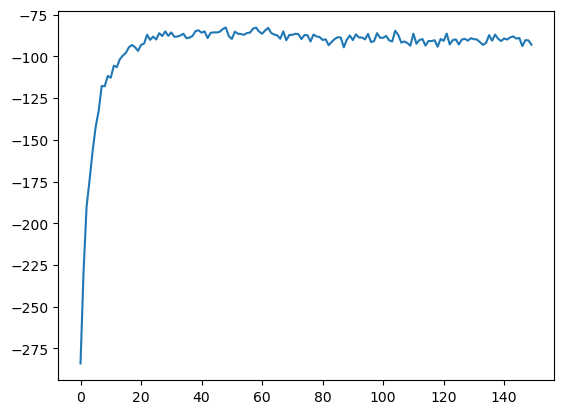

In [10]:
plt.plot(logs)
plt.show()

In [13]:
agent.save('Best_acrobot')

In [21]:
agent.load('Best_acrobot')

In [22]:
env = gym.make('Acrobot-v1')
agent.play(env, trajectory_len)
env.close()

In [13]:
env = gym.make('CartPole-v1')
state_dim = 4
action_n = 2

agent_1 = CEM(state_dim, action_n)
epochs = 150
trajectory_n = 100
trajectory_len = 1500
q_param = 0.8

In [5]:
logs = agent.train(env, epochs, trajectory_len, trajectory_n, q_param)

  0%|                                                                                          | 0/150 [00:00<?, ?it/s]C:\Users\Egor\anaconda3\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Egor\AppData\Local\Temp\ipykernel_17784\319988974.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  elite_states = torch.FloatTensor(elite_states)
  1%|▌                                                                                 | 1/150 [00:00<01:09,  2.13it/s]

epoch = 0, 
 total reward = 19.44


  1%|█                                                                                 | 2/150 [00:01<01:19,  1.85it/s]

epoch = 1, 
 total reward = 23.22


  2%|█▋                                                                                | 3/150 [00:01<01:23,  1.76it/s]

epoch = 2, 
 total reward = 25.95


  3%|██▏                                                                               | 4/150 [00:02<01:11,  2.03it/s]

epoch = 3, 
 total reward = 29.64


  3%|██▋                                                                               | 5/150 [00:02<01:06,  2.17it/s]

epoch = 4, 
 total reward = 33.83


  4%|███▎                                                                              | 6/150 [00:03<01:42,  1.41it/s]

epoch = 5, 
 total reward = 37.74


  5%|███▊                                                                              | 7/150 [00:05<02:31,  1.06s/it]

epoch = 6, 
 total reward = 43.33


  5%|████▎                                                                             | 8/150 [00:07<03:09,  1.34s/it]

epoch = 7, 
 total reward = 48.5


  6%|████▉                                                                             | 9/150 [00:09<03:49,  1.63s/it]

epoch = 8, 
 total reward = 52.13


  7%|█████▍                                                                           | 10/150 [00:11<03:39,  1.57s/it]

epoch = 9, 
 total reward = 47.52


  7%|█████▉                                                                           | 11/150 [00:12<03:54,  1.68s/it]

epoch = 10, 
 total reward = 51.57


  8%|██████▍                                                                          | 12/150 [00:15<04:13,  1.84s/it]

epoch = 11, 
 total reward = 55.66


  9%|███████                                                                          | 13/150 [00:17<04:30,  1.98s/it]

epoch = 12, 
 total reward = 57.67


  9%|███████▌                                                                         | 14/150 [00:19<04:22,  1.93s/it]

epoch = 13, 
 total reward = 58.48


 10%|████████                                                                         | 15/150 [00:21<04:40,  2.07s/it]

epoch = 14, 
 total reward = 60.59


 11%|████████▋                                                                        | 16/150 [00:23<04:46,  2.13s/it]

epoch = 15, 
 total reward = 62.76


 11%|█████████▏                                                                       | 17/150 [00:26<04:38,  2.10s/it]

epoch = 16, 
 total reward = 62.2


 12%|█████████▋                                                                       | 18/150 [00:28<04:52,  2.22s/it]

epoch = 17, 
 total reward = 65.48


 13%|██████████▎                                                                      | 19/150 [00:31<05:02,  2.31s/it]

epoch = 18, 
 total reward = 64.3


 13%|██████████▊                                                                      | 20/150 [00:33<05:21,  2.47s/it]

epoch = 19, 
 total reward = 70.09


 14%|███████████▎                                                                     | 21/150 [00:37<05:48,  2.70s/it]

epoch = 20, 
 total reward = 67.38


 15%|███████████▉                                                                     | 22/150 [00:39<05:21,  2.51s/it]

epoch = 21, 
 total reward = 66.79


 15%|████████████▍                                                                    | 23/150 [00:42<05:54,  2.79s/it]

epoch = 22, 
 total reward = 71.49


 16%|████████████▉                                                                    | 24/150 [00:45<06:12,  2.96s/it]

epoch = 23, 
 total reward = 69.77


 17%|█████████████▌                                                                   | 25/150 [00:48<05:41,  2.73s/it]

epoch = 24, 
 total reward = 71.53


 17%|██████████████                                                                   | 26/150 [00:51<05:47,  2.80s/it]

epoch = 25, 
 total reward = 69.39


 18%|██████████████▌                                                                  | 27/150 [00:53<05:17,  2.58s/it]

epoch = 26, 
 total reward = 68.39


 19%|███████████████                                                                  | 28/150 [00:56<05:29,  2.70s/it]

epoch = 27, 
 total reward = 67.75


 19%|███████████████▋                                                                 | 29/150 [00:59<05:42,  2.83s/it]

epoch = 28, 
 total reward = 68.76


 20%|████████████████▏                                                                | 30/150 [01:01<05:32,  2.77s/it]

epoch = 29, 
 total reward = 70.05


 21%|████████████████▋                                                                | 31/150 [01:04<05:17,  2.67s/it]

epoch = 30, 
 total reward = 73.36


 21%|█████████████████▎                                                               | 32/150 [01:06<04:56,  2.51s/it]

epoch = 31, 
 total reward = 72.38


 22%|█████████████████▊                                                               | 33/150 [01:08<04:33,  2.34s/it]

epoch = 32, 
 total reward = 68.74


 23%|██████████████████▎                                                              | 34/150 [01:10<04:31,  2.34s/it]

epoch = 33, 
 total reward = 73.03


 23%|██████████████████▉                                                              | 35/150 [01:13<04:55,  2.57s/it]

epoch = 34, 
 total reward = 75.92


 24%|███████████████████▍                                                             | 36/150 [01:17<05:27,  2.88s/it]

epoch = 35, 
 total reward = 79.14


 25%|███████████████████▉                                                             | 37/150 [01:20<05:40,  3.01s/it]

epoch = 36, 
 total reward = 78.19


 25%|████████████████████▌                                                            | 38/150 [01:24<05:49,  3.12s/it]

epoch = 37, 
 total reward = 76.04


 26%|█████████████████████                                                            | 39/150 [01:26<05:27,  2.95s/it]

epoch = 38, 
 total reward = 79.17


 27%|█████████████████████▌                                                           | 40/150 [01:28<04:57,  2.71s/it]

epoch = 39, 
 total reward = 72.69


 27%|██████████████████████▏                                                          | 41/150 [01:30<04:34,  2.52s/it]

epoch = 40, 
 total reward = 74.36


 28%|██████████████████████▋                                                          | 42/150 [01:33<04:43,  2.62s/it]

epoch = 41, 
 total reward = 76.08


 29%|███████████████████████▏                                                         | 43/150 [01:36<04:52,  2.74s/it]

epoch = 42, 
 total reward = 78.32


 29%|███████████████████████▊                                                         | 44/150 [01:39<04:49,  2.73s/it]

epoch = 43, 
 total reward = 76.3


 30%|████████████████████████▎                                                        | 45/150 [01:42<04:43,  2.70s/it]

epoch = 44, 
 total reward = 74.21


 31%|████████████████████████▊                                                        | 46/150 [01:45<04:44,  2.73s/it]

epoch = 45, 
 total reward = 76.25


 31%|█████████████████████████▍                                                       | 47/150 [01:47<04:35,  2.67s/it]

epoch = 46, 
 total reward = 74.34


 32%|█████████████████████████▉                                                       | 48/150 [01:49<04:25,  2.61s/it]

epoch = 47, 
 total reward = 82.45


 33%|██████████████████████████▍                                                      | 49/150 [01:52<04:19,  2.57s/it]

epoch = 48, 
 total reward = 79.15


 33%|███████████████████████████                                                      | 50/150 [01:55<04:37,  2.78s/it]

epoch = 49, 
 total reward = 81.29


 34%|███████████████████████████▌                                                     | 51/150 [01:58<04:31,  2.74s/it]

epoch = 50, 
 total reward = 81.04


 35%|████████████████████████████                                                     | 52/150 [02:01<04:50,  2.96s/it]

epoch = 51, 
 total reward = 86.11


 35%|████████████████████████████▌                                                    | 53/150 [02:05<05:08,  3.19s/it]

epoch = 52, 
 total reward = 81.8


 36%|█████████████████████████████▏                                                   | 54/150 [02:08<05:07,  3.20s/it]

epoch = 53, 
 total reward = 79.83


 37%|█████████████████████████████▋                                                   | 55/150 [02:12<05:09,  3.26s/it]

epoch = 54, 
 total reward = 77.64


 37%|██████████████████████████████▏                                                  | 56/150 [02:15<05:06,  3.26s/it]

epoch = 55, 
 total reward = 77.63


 38%|██████████████████████████████▊                                                  | 57/150 [02:19<05:11,  3.35s/it]

epoch = 56, 
 total reward = 78.8


 39%|███████████████████████████████▎                                                 | 58/150 [02:21<04:39,  3.04s/it]

epoch = 57, 
 total reward = 79.04


 39%|███████████████████████████████▊                                                 | 59/150 [02:25<04:57,  3.26s/it]

epoch = 58, 
 total reward = 81.57


 40%|████████████████████████████████▍                                                | 60/150 [02:27<04:36,  3.07s/it]

epoch = 59, 
 total reward = 80.32


 41%|████████████████████████████████▉                                                | 61/150 [02:31<04:38,  3.13s/it]

epoch = 60, 
 total reward = 78.58


 41%|█████████████████████████████████▍                                               | 62/150 [02:34<04:39,  3.18s/it]

epoch = 61, 
 total reward = 78.27


 42%|██████████████████████████████████                                               | 63/150 [02:37<04:37,  3.19s/it]

epoch = 62, 
 total reward = 78.68


 43%|██████████████████████████████████▌                                              | 64/150 [02:40<04:33,  3.18s/it]

epoch = 63, 
 total reward = 75.5


 43%|███████████████████████████████████                                              | 65/150 [02:44<04:39,  3.29s/it]

epoch = 64, 
 total reward = 81.5


 44%|███████████████████████████████████▋                                             | 66/150 [02:47<04:36,  3.29s/it]

epoch = 65, 
 total reward = 77.62


 45%|████████████████████████████████████▏                                            | 67/150 [02:50<04:37,  3.34s/it]

epoch = 66, 
 total reward = 77.4


 45%|████████████████████████████████████▋                                            | 68/150 [02:54<04:33,  3.33s/it]

epoch = 67, 
 total reward = 78.92


 46%|█████████████████████████████████████▎                                           | 69/150 [02:57<04:37,  3.43s/it]

epoch = 68, 
 total reward = 84.91


 47%|█████████████████████████████████████▊                                           | 70/150 [03:00<04:21,  3.27s/it]

epoch = 69, 
 total reward = 77.68


 47%|██████████████████████████████████████▎                                          | 71/150 [03:04<04:17,  3.27s/it]

epoch = 70, 
 total reward = 82.56


 48%|██████████████████████████████████████▉                                          | 72/150 [03:07<04:07,  3.18s/it]

epoch = 71, 
 total reward = 85.04


 49%|███████████████████████████████████████▍                                         | 73/150 [03:09<03:58,  3.10s/it]

epoch = 72, 
 total reward = 90.52


 49%|███████████████████████████████████████▉                                         | 74/150 [03:12<03:52,  3.06s/it]

epoch = 73, 
 total reward = 84.35


 50%|████████████████████████████████████████▌                                        | 75/150 [03:16<03:53,  3.12s/it]

epoch = 74, 
 total reward = 92.58


 51%|█████████████████████████████████████████                                        | 76/150 [03:19<03:53,  3.16s/it]

epoch = 75, 
 total reward = 95.08


 51%|█████████████████████████████████████████▌                                       | 77/150 [03:22<03:43,  3.07s/it]

epoch = 76, 
 total reward = 92.69


 52%|██████████████████████████████████████████                                       | 78/150 [03:26<04:03,  3.38s/it]

epoch = 77, 
 total reward = 95.57


 53%|██████████████████████████████████████████▋                                      | 79/150 [03:30<04:07,  3.49s/it]

epoch = 78, 
 total reward = 98.61


 53%|███████████████████████████████████████████▏                                     | 80/150 [03:32<03:46,  3.23s/it]

epoch = 79, 
 total reward = 81.61


 54%|███████████████████████████████████████████▋                                     | 81/150 [03:36<03:43,  3.24s/it]

epoch = 80, 
 total reward = 93.75


 55%|████████████████████████████████████████████▎                                    | 82/150 [03:38<03:25,  3.02s/it]

epoch = 81, 
 total reward = 99.39


 55%|████████████████████████████████████████████▊                                    | 83/150 [03:42<03:35,  3.22s/it]

epoch = 82, 
 total reward = 96.02


 56%|█████████████████████████████████████████████▎                                   | 84/150 [03:45<03:33,  3.24s/it]

epoch = 83, 
 total reward = 91.61


 57%|█████████████████████████████████████████████▉                                   | 85/150 [03:48<03:18,  3.05s/it]

epoch = 84, 
 total reward = 95.13


 57%|██████████████████████████████████████████████▍                                  | 86/150 [03:51<03:20,  3.13s/it]

epoch = 85, 
 total reward = 91.47


 58%|██████████████████████████████████████████████▉                                  | 87/150 [03:53<03:03,  2.91s/it]

epoch = 86, 
 total reward = 95.55


 59%|███████████████████████████████████████████████▌                                 | 88/150 [03:56<02:55,  2.83s/it]

epoch = 87, 
 total reward = 97.55


 59%|████████████████████████████████████████████████                                 | 89/150 [03:59<02:56,  2.89s/it]

epoch = 88, 
 total reward = 93.26


 60%|████████████████████████████████████████████████▌                                | 90/150 [04:02<03:03,  3.06s/it]

epoch = 89, 
 total reward = 98.63


 61%|█████████████████████████████████████████████████▏                               | 91/150 [04:05<02:53,  2.94s/it]

epoch = 90, 
 total reward = 91.59


 61%|█████████████████████████████████████████████████▋                               | 92/150 [04:09<03:05,  3.20s/it]

epoch = 91, 
 total reward = 105.28


 62%|██████████████████████████████████████████████████▏                              | 93/150 [04:12<03:08,  3.30s/it]

epoch = 92, 
 total reward = 102.46


 63%|██████████████████████████████████████████████████▊                              | 94/150 [04:17<03:22,  3.61s/it]

epoch = 93, 
 total reward = 106.07


 63%|███████████████████████████████████████████████████▎                             | 95/150 [04:20<03:16,  3.58s/it]

epoch = 94, 
 total reward = 104.26


 64%|███████████████████████████████████████████████████▊                             | 96/150 [04:24<03:19,  3.70s/it]

epoch = 95, 
 total reward = 98.56


 65%|████████████████████████████████████████████████████▍                            | 97/150 [04:28<03:15,  3.68s/it]

epoch = 96, 
 total reward = 97.77


 65%|████████████████████████████████████████████████████▉                            | 98/150 [04:33<03:27,  3.99s/it]

epoch = 97, 
 total reward = 107.68


 66%|█████████████████████████████████████████████████████▍                           | 99/150 [04:37<03:22,  3.96s/it]

epoch = 98, 
 total reward = 103.75


 67%|█████████████████████████████████████████████████████▎                          | 100/150 [04:41<03:27,  4.14s/it]

epoch = 99, 
 total reward = 102.96


 67%|█████████████████████████████████████████████████████▊                          | 101/150 [04:45<03:12,  3.93s/it]

epoch = 100, 
 total reward = 110.2


 68%|██████████████████████████████████████████████████████▍                         | 102/150 [04:49<03:14,  4.05s/it]

epoch = 101, 
 total reward = 108.35


 69%|██████████████████████████████████████████████████████▉                         | 103/150 [04:53<03:11,  4.07s/it]

epoch = 102, 
 total reward = 97.4


 69%|███████████████████████████████████████████████████████▍                        | 104/150 [04:57<03:03,  3.99s/it]

epoch = 103, 
 total reward = 111.91


 70%|████████████████████████████████████████████████████████                        | 105/150 [04:59<02:34,  3.44s/it]

epoch = 104, 
 total reward = 109.6


 71%|████████████████████████████████████████████████████████▌                       | 106/150 [05:03<02:44,  3.73s/it]

epoch = 105, 
 total reward = 104.51


 71%|█████████████████████████████████████████████████████████                       | 107/150 [05:07<02:45,  3.85s/it]

epoch = 106, 
 total reward = 100.91


 72%|█████████████████████████████████████████████████████████▌                      | 108/150 [05:11<02:43,  3.89s/it]

epoch = 107, 
 total reward = 105.07


 73%|██████████████████████████████████████████████████████████▏                     | 109/150 [05:14<02:26,  3.58s/it]

epoch = 108, 
 total reward = 103.31


 73%|██████████████████████████████████████████████████████████▋                     | 110/150 [05:18<02:19,  3.49s/it]

epoch = 109, 
 total reward = 110.97


 74%|███████████████████████████████████████████████████████████▏                    | 111/150 [05:22<02:24,  3.71s/it]

epoch = 110, 
 total reward = 101.53


 75%|███████████████████████████████████████████████████████████▋                    | 112/150 [05:26<02:31,  3.98s/it]

epoch = 111, 
 total reward = 108.11


 75%|████████████████████████████████████████████████████████████▎                   | 113/150 [05:30<02:25,  3.92s/it]

epoch = 112, 
 total reward = 101.2


 76%|████████████████████████████████████████████████████████████▊                   | 114/150 [05:34<02:16,  3.80s/it]

epoch = 113, 
 total reward = 105.51


 77%|█████████████████████████████████████████████████████████████▎                  | 115/150 [05:37<02:11,  3.76s/it]

epoch = 114, 
 total reward = 110.33


 77%|█████████████████████████████████████████████████████████████▊                  | 116/150 [05:41<02:04,  3.65s/it]

epoch = 115, 
 total reward = 115.69


 78%|██████████████████████████████████████████████████████████████▍                 | 117/150 [05:45<02:04,  3.79s/it]

epoch = 116, 
 total reward = 116.66


 79%|██████████████████████████████████████████████████████████████▉                 | 118/150 [05:48<01:58,  3.70s/it]

epoch = 117, 
 total reward = 113.27


 79%|███████████████████████████████████████████████████████████████▍                | 119/150 [05:52<01:51,  3.61s/it]

epoch = 118, 
 total reward = 110.06


 80%|████████████████████████████████████████████████████████████████                | 120/150 [05:56<01:50,  3.67s/it]

epoch = 119, 
 total reward = 116.04


 81%|████████████████████████████████████████████████████████████████▌               | 121/150 [05:59<01:43,  3.57s/it]

epoch = 120, 
 total reward = 111.57


 81%|█████████████████████████████████████████████████████████████████               | 122/150 [06:03<01:42,  3.65s/it]

epoch = 121, 
 total reward = 125.77


 82%|█████████████████████████████████████████████████████████████████▌              | 123/150 [06:06<01:38,  3.63s/it]

epoch = 122, 
 total reward = 117.99


 83%|██████████████████████████████████████████████████████████████████▏             | 124/150 [06:10<01:36,  3.70s/it]

epoch = 123, 
 total reward = 120.89


 83%|██████████████████████████████████████████████████████████████████▋             | 125/150 [06:14<01:31,  3.67s/it]

epoch = 124, 
 total reward = 125.91


 84%|███████████████████████████████████████████████████████████████████▏            | 126/150 [06:18<01:29,  3.73s/it]

epoch = 125, 
 total reward = 119.45


 85%|███████████████████████████████████████████████████████████████████▋            | 127/150 [06:21<01:25,  3.73s/it]

epoch = 126, 
 total reward = 128.36


 85%|████████████████████████████████████████████████████████████████████▎           | 128/150 [06:25<01:22,  3.73s/it]

epoch = 127, 
 total reward = 117.07


 86%|████████████████████████████████████████████████████████████████████▊           | 129/150 [06:29<01:18,  3.73s/it]

epoch = 128, 
 total reward = 125.3


 87%|█████████████████████████████████████████████████████████████████████▎          | 130/150 [06:33<01:13,  3.69s/it]

epoch = 129, 
 total reward = 112.75


 87%|█████████████████████████████████████████████████████████████████████▊          | 131/150 [06:38<01:19,  4.17s/it]

epoch = 130, 
 total reward = 119.3


 88%|██████████████████████████████████████████████████████████████████████▍         | 132/150 [06:41<01:12,  4.03s/it]

epoch = 131, 
 total reward = 124.27


 89%|██████████████████████████████████████████████████████████████████████▉         | 133/150 [06:46<01:09,  4.06s/it]

epoch = 132, 
 total reward = 128.09


 89%|███████████████████████████████████████████████████████████████████████▍        | 134/150 [06:49<01:02,  3.90s/it]

epoch = 133, 
 total reward = 115.46


 90%|████████████████████████████████████████████████████████████████████████        | 135/150 [06:53<01:00,  4.00s/it]

epoch = 134, 
 total reward = 124.13


 91%|████████████████████████████████████████████████████████████████████████▌       | 136/150 [06:57<00:55,  3.96s/it]

epoch = 135, 
 total reward = 122.43


 91%|█████████████████████████████████████████████████████████████████████████       | 137/150 [07:01<00:51,  3.94s/it]

epoch = 136, 
 total reward = 126.72


 92%|█████████████████████████████████████████████████████████████████████████▌      | 138/150 [07:05<00:46,  3.84s/it]

epoch = 137, 
 total reward = 121.29


 93%|██████████████████████████████████████████████████████████████████████████▏     | 139/150 [07:09<00:42,  3.86s/it]

epoch = 138, 
 total reward = 123.91


 93%|██████████████████████████████████████████████████████████████████████████▋     | 140/150 [07:13<00:38,  3.87s/it]

epoch = 139, 
 total reward = 127.96


 94%|███████████████████████████████████████████████████████████████████████████▏    | 141/150 [07:16<00:34,  3.84s/it]

epoch = 140, 
 total reward = 122.85


 95%|███████████████████████████████████████████████████████████████████████████▋    | 142/150 [07:20<00:30,  3.86s/it]

epoch = 141, 
 total reward = 119.79


 95%|████████████████████████████████████████████████████████████████████████████▎   | 143/150 [07:24<00:27,  3.91s/it]

epoch = 142, 
 total reward = 131.47


 96%|████████████████████████████████████████████████████████████████████████████▊   | 144/150 [07:28<00:22,  3.80s/it]

epoch = 143, 
 total reward = 122.55


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 145/150 [07:32<00:19,  3.86s/it]

epoch = 144, 
 total reward = 126.16


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 146/150 [07:36<00:15,  3.83s/it]

epoch = 145, 
 total reward = 127.43


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 147/150 [07:40<00:12,  4.04s/it]

epoch = 146, 
 total reward = 141.32


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 148/150 [07:44<00:07,  3.96s/it]

epoch = 147, 
 total reward = 128.62


 99%|███████████████████████████████████████████████████████████████████████████████▍| 149/150 [07:48<00:04,  4.02s/it]

epoch = 148, 
 total reward = 137.31


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [07:53<00:00,  3.16s/it]

epoch = 149, 
 total reward = 153.26


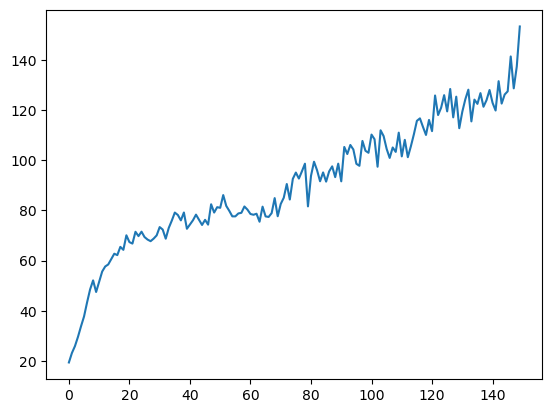

In [6]:
plt.plot(logs)
plt.show()

In [37]:
agent.save('Model_CartPole-v1')

In [17]:
agent_1.load('Model_CartPole-v1')

In [19]:
env = gym.make('CartPole-v1')
agent_1.play(env, trajectory_len)
env.close()

In [3]:
class CEM(nn.Module):
    def __init__(self, state_dim, action_n):
        super().__init__()
        self.state_dim = state_dim
        self.action_n = action_n

        self.network = nn.Sequential(
                            nn.Linear(self.state_dim, 64),
                            #nn.Tanh(),
                            #nn.Linear(512, 256),
                            nn.ReLU(),
                            nn.Linear(64, self.action_n),
                            nn.Softmax() )
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=0.01)
        self.loss = nn.CrossEntropyLoss()
        
        
    def forward(self, state):
        return self.network(state)
        
    def get_action(self, state):
        state = torch.FloatTensor(state)
        action_prob = self.forward(state).detach().numpy()
        action = np.random.choice(np.arange(action_n), p=action_prob)
        
        return action
    
    def update_policy(self, elite_trajectories):
        elite_states =[]
        elite_actions = []
        
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        
        elite_states = torch.FloatTensor(elite_states)
        elite_actions = torch.LongTensor(elite_actions)
        
        loss = self.loss(self.forward(elite_states), elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        
    def get_trajectory(self, env, trajectory_len, vizualize=False):
        trajectory = {'states': [], 'actions': [], 'total_reward': 0}
        
        state = env.reset()
        for i in range(trajectory_len):
            trajectory['states'].append(state)
            
            action = self.get_action(state)
            trajectory['actions'].append(action)
            state, reward, done, _ = env.step(action)
            
            trajectory['total_reward'] += reward
            
            if done:
                break
                
            if vizualize:
                env.render()
                time.sleep(0.05)
                
        return trajectory
            
    def get_elite_trajectories(self, trajectories, q_param):
        total_rewards = [trj['total_reward'] for trj in trajectories]
        quantile = np.quantile(total_rewards, q=q_param)
        return [trajectory for trajectory in trajectories if trajectory['total_reward'] >= quantile]
    
    
    def train(self, env, epochs, trajectory_len, trajectory_n, q_param, learning_rate=0.01):
        
        history = []
        
        for i in tqdm(range(epochs)):
            trajectories = [self.get_trajectory(env, trajectory_len) for _ in range(trajectory_n)]
            
            mean_total_reward = np.mean([trj['total_reward'] for trj in trajectories])
            history.append(mean_total_reward)
            
            elite = self.get_elite_trajectories(trajectories, q_param)
            
            if len(elite) > 0:
                self.update_policy(elite)
                
            print(f'epoch = {i}, \n total reward = {mean_total_reward}')
            
        return history
    
            
    def play(self, env, trajectory_len):
        self.get_trajectory(env, trajectory_len, vizualize=True)
        
    def save(self, path):
        torch.save(self.network, path)
        
    def load(self, path):
        self.network = torch.load(path)
        self.network.eval()
    

In [11]:
env = gym.make("LunarLander-v2")

state_dim = env.observation_space.shape[0]
action_n = env.action_space.n

epochs = 150
trajectory_len = 500
trajectory_n = 150
q_param = 0.5

agent = CEM(state_dim, action_n)

In [12]:
logs = agent.train(env, epochs, trajectory_len, trajectory_n, q_param)

  0%|                                                                                          | 0/150 [00:00<?, ?it/s]C:\Users\Egor\anaconda3\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Users\Egor\AppData\Local\Temp\ipykernel_15052\2801060935.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  elite_states = torch.FloatTensor(elite_states)
  1%|▌                                                                                 | 1/150 [00:13<32:38, 13.15s/it]

epoch = 0, 
 total reward = -213.15992839546735


  1%|█                                                                                 | 2/150 [00:24<30:14, 12.26s/it]

epoch = 1, 
 total reward = -203.73217699682235


  2%|█▋                                                                                | 3/150 [00:35<28:36, 11.68s/it]

epoch = 2, 
 total reward = -179.91533834663483


  3%|██▏                                                                               | 4/150 [00:46<27:40, 11.38s/it]

epoch = 3, 
 total reward = -173.64565848385158


  3%|██▋                                                                               | 5/150 [00:57<27:01, 11.18s/it]

epoch = 4, 
 total reward = -152.23632869539216


  4%|███▎                                                                              | 6/150 [01:06<25:23, 10.58s/it]

epoch = 5, 
 total reward = -159.52568718937107


  5%|███▊                                                                              | 7/150 [01:16<24:11, 10.15s/it]

epoch = 6, 
 total reward = -159.04222089580765


  5%|████▎                                                                             | 8/150 [01:25<23:45, 10.04s/it]

epoch = 7, 
 total reward = -155.63515249614724


  6%|████▉                                                                             | 9/150 [01:35<23:12,  9.87s/it]

epoch = 8, 
 total reward = -165.03524865699882


  7%|█████▍                                                                           | 10/150 [01:44<22:08,  9.49s/it]

epoch = 9, 
 total reward = -157.98998076503645


  7%|█████▉                                                                           | 11/150 [01:53<22:06,  9.54s/it]

epoch = 10, 
 total reward = -169.46818051975347


  8%|██████▍                                                                          | 12/150 [02:02<21:11,  9.22s/it]

epoch = 11, 
 total reward = -198.88548051348332


  9%|███████                                                                          | 13/150 [02:10<20:36,  9.02s/it]

epoch = 12, 
 total reward = -240.2293390683913


  9%|███████▌                                                                         | 14/150 [02:19<20:01,  8.83s/it]

epoch = 13, 
 total reward = -293.14067810708445


 10%|████████                                                                         | 15/150 [02:27<19:42,  8.76s/it]

epoch = 14, 
 total reward = -373.5526496714425


 11%|████████▋                                                                        | 16/150 [02:36<19:30,  8.74s/it]

epoch = 15, 
 total reward = -423.71295153279624


 11%|█████████▏                                                                       | 17/150 [02:45<19:26,  8.77s/it]

epoch = 16, 
 total reward = -482.9523167822772


 12%|█████████▋                                                                       | 18/150 [02:54<19:26,  8.84s/it]

epoch = 17, 
 total reward = -514.019323378498


 13%|██████████▎                                                                      | 19/150 [03:03<19:28,  8.92s/it]

epoch = 18, 
 total reward = -550.5224486939092


 13%|██████████▊                                                                      | 20/150 [03:11<18:41,  8.63s/it]

epoch = 19, 
 total reward = -558.7597359605282


 14%|███████████▎                                                                     | 21/150 [03:19<18:25,  8.57s/it]

epoch = 20, 
 total reward = -564.8697226296397


 15%|███████████▉                                                                     | 22/150 [03:28<18:27,  8.65s/it]

epoch = 21, 
 total reward = -577.6146001522685


 15%|████████████▍                                                                    | 23/150 [03:36<18:03,  8.53s/it]

epoch = 22, 
 total reward = -580.262873346419


 16%|████████████▉                                                                    | 24/150 [03:45<17:54,  8.52s/it]

epoch = 23, 
 total reward = -589.781207524804


 17%|█████████████▌                                                                   | 25/150 [03:53<17:28,  8.39s/it]

epoch = 24, 
 total reward = -591.8427340290056


 17%|██████████████                                                                   | 26/150 [04:01<17:15,  8.35s/it]

epoch = 25, 
 total reward = -587.2000674424268


 18%|██████████████▌                                                                  | 27/150 [04:09<17:00,  8.30s/it]

epoch = 26, 
 total reward = -588.9437906975062


 19%|███████████████                                                                  | 28/150 [04:17<16:30,  8.12s/it]

epoch = 27, 
 total reward = -565.6172228451933


 19%|███████████████▋                                                                 | 29/150 [04:26<16:35,  8.23s/it]

epoch = 28, 
 total reward = -597.0903914892203


 20%|████████████████▏                                                                | 30/150 [04:34<16:48,  8.41s/it]

epoch = 29, 
 total reward = -575.0119739732571


 21%|████████████████▋                                                                | 31/150 [04:42<16:18,  8.22s/it]

epoch = 30, 
 total reward = -593.0805459505038


 21%|█████████████████▎                                                               | 32/150 [04:50<15:47,  8.03s/it]

epoch = 31, 
 total reward = -593.8206406788304


 22%|█████████████████▊                                                               | 33/150 [04:57<15:13,  7.81s/it]

epoch = 32, 
 total reward = -571.1995775997495


 23%|██████████████████▎                                                              | 34/150 [05:05<15:03,  7.79s/it]

epoch = 33, 
 total reward = -570.1195726720139


 23%|██████████████████▉                                                              | 35/150 [05:14<15:24,  8.04s/it]

epoch = 34, 
 total reward = -592.846830273214


 24%|███████████████████▍                                                             | 36/150 [05:21<15:12,  8.01s/it]

epoch = 35, 
 total reward = -567.9213061932131


 25%|███████████████████▉                                                             | 37/150 [05:30<15:13,  8.08s/it]

epoch = 36, 
 total reward = -577.1024570246977


 25%|████████████████████▌                                                            | 38/150 [05:38<15:13,  8.16s/it]

epoch = 37, 
 total reward = -612.0894016778014


 26%|█████████████████████                                                            | 39/150 [05:46<14:49,  8.02s/it]

epoch = 38, 
 total reward = -566.2901961757827


 27%|█████████████████████▌                                                           | 40/150 [05:54<14:51,  8.10s/it]

epoch = 39, 
 total reward = -578.1987086782315


 27%|██████████████████████▏                                                          | 41/150 [06:02<14:53,  8.20s/it]

epoch = 40, 
 total reward = -589.5451799791445


 28%|██████████████████████▋                                                          | 42/150 [06:11<14:45,  8.20s/it]

epoch = 41, 
 total reward = -573.7876489125335


 29%|███████████████████████▏                                                         | 43/150 [06:18<14:20,  8.05s/it]

epoch = 42, 
 total reward = -580.7481161377746


 29%|███████████████████████▊                                                         | 44/150 [06:26<14:12,  8.04s/it]

epoch = 43, 
 total reward = -568.6455806541492


 30%|████████████████████████▎                                                        | 45/150 [06:35<14:24,  8.23s/it]

epoch = 44, 
 total reward = -602.504675457142


 31%|████████████████████████▊                                                        | 46/150 [06:43<14:08,  8.16s/it]

epoch = 45, 
 total reward = -575.9262576064903


 31%|█████████████████████████▍                                                       | 47/150 [06:51<13:49,  8.05s/it]

epoch = 46, 
 total reward = -577.9011669581158


 32%|█████████████████████████▉                                                       | 48/150 [06:59<13:49,  8.13s/it]

epoch = 47, 
 total reward = -571.6857338288762


 33%|██████████████████████████▍                                                      | 49/150 [07:08<14:05,  8.37s/it]

epoch = 48, 
 total reward = -571.5545926779117


 33%|███████████████████████████                                                      | 50/150 [07:16<13:53,  8.33s/it]

epoch = 49, 
 total reward = -571.1086376814739


 34%|███████████████████████████▌                                                     | 51/150 [07:25<13:47,  8.36s/it]

epoch = 50, 
 total reward = -586.2484892332599


 35%|████████████████████████████                                                     | 52/150 [07:34<13:55,  8.53s/it]

epoch = 51, 
 total reward = -618.0234693837249


 35%|████████████████████████████▌                                                    | 53/150 [07:41<13:02,  8.07s/it]

epoch = 52, 
 total reward = -560.1386535326059


 36%|█████████████████████████████▏                                                   | 54/150 [07:49<13:04,  8.17s/it]

epoch = 53, 
 total reward = -577.3132331191704


 37%|█████████████████████████████▋                                                   | 55/150 [07:57<12:55,  8.17s/it]

epoch = 54, 
 total reward = -573.7578651467815


 37%|██████████████████████████████▏                                                  | 56/150 [08:06<12:51,  8.21s/it]

epoch = 55, 
 total reward = -561.4608662528797


 38%|██████████████████████████████▊                                                  | 57/150 [08:14<13:02,  8.41s/it]

epoch = 56, 
 total reward = -582.7626526826735


 39%|███████████████████████████████▎                                                 | 58/150 [08:22<12:28,  8.14s/it]

epoch = 57, 
 total reward = -556.4098309952252


 39%|███████████████████████████████▊                                                 | 59/150 [08:31<12:35,  8.30s/it]

epoch = 58, 
 total reward = -564.428140623243


 40%|████████████████████████████████▍                                                | 60/150 [08:39<12:36,  8.41s/it]

epoch = 59, 
 total reward = -582.3210724349962


 41%|████████████████████████████████▉                                                | 61/150 [08:48<12:40,  8.55s/it]

epoch = 60, 
 total reward = -570.2367135576521


 41%|█████████████████████████████████▍                                               | 62/150 [08:56<12:25,  8.47s/it]

epoch = 61, 
 total reward = -594.1037908033079


 42%|██████████████████████████████████                                               | 63/150 [09:05<12:15,  8.46s/it]

epoch = 62, 
 total reward = -572.6057187578264


 43%|██████████████████████████████████▌                                              | 64/150 [09:13<12:11,  8.51s/it]

epoch = 63, 
 total reward = -582.5173625316642


 43%|███████████████████████████████████                                              | 65/150 [09:22<12:04,  8.53s/it]

epoch = 64, 
 total reward = -596.1724739118714


 44%|███████████████████████████████████▋                                             | 66/150 [09:30<11:46,  8.41s/it]

epoch = 65, 
 total reward = -565.9671277036922


 45%|████████████████████████████████████▏                                            | 67/150 [09:38<11:25,  8.26s/it]

epoch = 66, 
 total reward = -561.7940909761966


 45%|████████████████████████████████████▋                                            | 68/150 [09:46<11:11,  8.19s/it]

epoch = 67, 
 total reward = -556.2381127893566


 46%|█████████████████████████████████████▎                                           | 69/150 [09:55<11:16,  8.35s/it]

epoch = 68, 
 total reward = -572.8441997278586


 47%|█████████████████████████████████████▊                                           | 70/150 [10:03<10:59,  8.24s/it]

epoch = 69, 
 total reward = -576.4977931624439


 47%|██████████████████████████████████████▎                                          | 71/150 [10:10<10:20,  7.86s/it]

epoch = 70, 
 total reward = -556.5005140278605


 48%|██████████████████████████████████████▉                                          | 72/150 [10:18<10:28,  8.06s/it]

epoch = 71, 
 total reward = -566.9604044391675


 49%|███████████████████████████████████████▍                                         | 73/150 [10:26<10:18,  8.04s/it]

epoch = 72, 
 total reward = -566.8575141824351


 49%|███████████████████████████████████████▉                                         | 74/150 [10:35<10:17,  8.13s/it]

epoch = 73, 
 total reward = -586.977756961639


 50%|████████████████████████████████████████▌                                        | 75/150 [10:43<10:11,  8.16s/it]

epoch = 74, 
 total reward = -583.5045349655564


 51%|█████████████████████████████████████████                                        | 76/150 [10:51<09:59,  8.10s/it]

epoch = 75, 
 total reward = -572.2224599248414


 51%|█████████████████████████████████████████▌                                       | 77/150 [10:59<09:58,  8.19s/it]

epoch = 76, 
 total reward = -590.0901678438105


 52%|██████████████████████████████████████████                                       | 78/150 [11:07<09:50,  8.20s/it]

epoch = 77, 
 total reward = -583.1741616683955


 53%|██████████████████████████████████████████▋                                      | 79/150 [11:15<09:37,  8.13s/it]

epoch = 78, 
 total reward = -570.6877198593658


 53%|███████████████████████████████████████████▏                                     | 80/150 [11:23<09:14,  7.92s/it]

epoch = 79, 
 total reward = -540.77390729378


 54%|███████████████████████████████████████████▋                                     | 81/150 [11:31<09:15,  8.05s/it]

epoch = 80, 
 total reward = -582.179461753947


 55%|████████████████████████████████████████████▎                                    | 82/150 [11:40<09:15,  8.16s/it]

epoch = 81, 
 total reward = -566.1031805718442


 55%|████████████████████████████████████████████▊                                    | 83/150 [11:48<09:11,  8.23s/it]

epoch = 82, 
 total reward = -585.111973499904


 56%|█████████████████████████████████████████████▎                                   | 84/150 [11:55<08:46,  7.98s/it]

epoch = 83, 
 total reward = -575.2920325970236


 57%|█████████████████████████████████████████████▉                                   | 85/150 [12:03<08:30,  7.86s/it]

epoch = 84, 
 total reward = -577.3319453921448


 57%|██████████████████████████████████████████████▍                                  | 86/150 [12:11<08:25,  7.90s/it]

epoch = 85, 
 total reward = -569.2900886242747


 58%|██████████████████████████████████████████████▉                                  | 87/150 [12:19<08:19,  7.93s/it]

epoch = 86, 
 total reward = -583.7653581363867


 59%|███████████████████████████████████████████████▌                                 | 88/150 [12:27<08:11,  7.93s/it]

epoch = 87, 
 total reward = -574.3581362522879


 59%|████████████████████████████████████████████████                                 | 89/150 [12:35<08:04,  7.94s/it]

epoch = 88, 
 total reward = -575.8148412063304


 60%|████████████████████████████████████████████████▌                                | 90/150 [12:44<08:11,  8.19s/it]

epoch = 89, 
 total reward = -591.5553196991957


 61%|█████████████████████████████████████████████████▏                               | 91/150 [12:51<07:52,  8.01s/it]

epoch = 90, 
 total reward = -580.615511695214


 61%|█████████████████████████████████████████████████▋                               | 92/150 [13:00<07:57,  8.24s/it]

epoch = 91, 
 total reward = -583.2827705455812


 62%|██████████████████████████████████████████████████▏                              | 93/150 [13:08<07:49,  8.24s/it]

epoch = 92, 
 total reward = -597.9357703749696


 63%|██████████████████████████████████████████████████▊                              | 94/150 [13:16<07:33,  8.10s/it]

epoch = 93, 
 total reward = -585.5092557730986


 63%|███████████████████████████████████████████████████▎                             | 95/150 [13:24<07:24,  8.07s/it]

epoch = 94, 
 total reward = -567.1921194736071


 64%|███████████████████████████████████████████████████▊                             | 96/150 [13:32<07:15,  8.07s/it]

epoch = 95, 
 total reward = -571.5159829312757


 65%|████████████████████████████████████████████████████▍                            | 97/150 [13:39<06:52,  7.78s/it]

epoch = 96, 
 total reward = -579.4022251696716


 65%|████████████████████████████████████████████████████▉                            | 98/150 [13:45<06:18,  7.27s/it]

epoch = 97, 
 total reward = -576.1883675037988


 66%|█████████████████████████████████████████████████████▍                           | 99/150 [13:52<05:55,  6.96s/it]

epoch = 98, 
 total reward = -563.9172745759721


 67%|█████████████████████████████████████████████████████▎                          | 100/150 [13:58<05:40,  6.80s/it]

epoch = 99, 
 total reward = -553.1277952328869


 67%|█████████████████████████████████████████████████████▊                          | 101/150 [14:04<05:22,  6.58s/it]

epoch = 100, 
 total reward = -560.5575865014011


 68%|██████████████████████████████████████████████████████▍                         | 102/150 [14:09<04:46,  5.97s/it]

epoch = 101, 
 total reward = -565.3434302343157


 69%|██████████████████████████████████████████████████████▉                         | 103/150 [14:16<05:06,  6.52s/it]

epoch = 102, 
 total reward = -572.488859300553


 69%|███████████████████████████████████████████████████████▍                        | 104/150 [14:23<05:02,  6.57s/it]

epoch = 103, 
 total reward = -583.319658034711


 70%|████████████████████████████████████████████████████████                        | 105/150 [14:30<04:59,  6.66s/it]

epoch = 104, 
 total reward = -565.4302484953424


 71%|████████████████████████████████████████████████████████▌                       | 106/150 [14:36<04:41,  6.40s/it]

epoch = 105, 
 total reward = -590.8680605027155


 71%|█████████████████████████████████████████████████████████                       | 107/150 [14:42<04:32,  6.33s/it]

epoch = 106, 
 total reward = -586.1667861246601


 72%|█████████████████████████████████████████████████████████▌                      | 108/150 [14:49<04:29,  6.42s/it]

epoch = 107, 
 total reward = -597.1299662017187


 73%|██████████████████████████████████████████████████████████▏                     | 109/150 [14:56<04:31,  6.62s/it]

epoch = 108, 
 total reward = -592.1456350935412


 73%|██████████████████████████████████████████████████████████▋                     | 110/150 [15:02<04:22,  6.57s/it]

epoch = 109, 
 total reward = -569.8602257129054


 74%|███████████████████████████████████████████████████████████▏                    | 111/150 [15:08<04:03,  6.25s/it]

epoch = 110, 
 total reward = -584.5716312644136


 75%|███████████████████████████████████████████████████████████▋                    | 112/150 [15:13<03:49,  6.03s/it]

epoch = 111, 
 total reward = -589.3456251169404


 75%|████████████████████████████████████████████████████████████▎                   | 113/150 [15:18<03:32,  5.74s/it]

epoch = 112, 
 total reward = -570.3022505194924


 76%|████████████████████████████████████████████████████████████▊                   | 114/150 [15:24<03:23,  5.66s/it]

epoch = 113, 
 total reward = -593.7821140491318


 77%|█████████████████████████████████████████████████████████████▎                  | 115/150 [15:29<03:14,  5.56s/it]

epoch = 114, 
 total reward = -573.5599697979206


 77%|█████████████████████████████████████████████████████████████▊                  | 116/150 [15:35<03:08,  5.55s/it]

epoch = 115, 
 total reward = -602.4170810402053


 78%|██████████████████████████████████████████████████████████████▍                 | 117/150 [15:40<03:03,  5.56s/it]

epoch = 116, 
 total reward = -554.1734916607002


 79%|██████████████████████████████████████████████████████████████▉                 | 118/150 [15:45<02:55,  5.50s/it]

epoch = 117, 
 total reward = -596.9123461102834


 79%|███████████████████████████████████████████████████████████████▍                | 119/150 [15:51<02:52,  5.56s/it]

epoch = 118, 
 total reward = -575.5647809092951


 80%|████████████████████████████████████████████████████████████████                | 120/150 [15:56<02:42,  5.43s/it]

epoch = 119, 
 total reward = -574.6181229632774


 81%|████████████████████████████████████████████████████████████████▌               | 121/150 [16:02<02:40,  5.54s/it]

epoch = 120, 
 total reward = -566.9587087639372


 81%|█████████████████████████████████████████████████████████████████               | 122/150 [16:08<02:37,  5.62s/it]

epoch = 121, 
 total reward = -573.8943684589887


 82%|█████████████████████████████████████████████████████████████████▌              | 123/150 [16:14<02:35,  5.77s/it]

epoch = 122, 
 total reward = -579.4026747974862


 83%|██████████████████████████████████████████████████████████████████▏             | 124/150 [16:20<02:33,  5.92s/it]

epoch = 123, 
 total reward = -579.3892220988561


 83%|██████████████████████████████████████████████████████████████████▋             | 125/150 [16:26<02:29,  5.96s/it]

epoch = 124, 
 total reward = -577.3504727255743


 84%|███████████████████████████████████████████████████████████████████▏            | 126/150 [16:32<02:18,  5.79s/it]

epoch = 125, 
 total reward = -586.5356326038515


 85%|███████████████████████████████████████████████████████████████████▋            | 127/150 [16:37<02:11,  5.70s/it]

epoch = 126, 
 total reward = -582.236982497971


 85%|████████████████████████████████████████████████████████████████████▎           | 128/150 [16:43<02:08,  5.84s/it]

epoch = 127, 
 total reward = -617.8596551892063


 86%|████████████████████████████████████████████████████████████████████▊           | 129/150 [16:49<02:04,  5.91s/it]

epoch = 128, 
 total reward = -588.593732200908


 87%|█████████████████████████████████████████████████████████████████████▎          | 130/150 [16:56<02:00,  6.04s/it]

epoch = 129, 
 total reward = -569.179462719467


 87%|█████████████████████████████████████████████████████████████████████▊          | 131/150 [17:02<01:55,  6.10s/it]

epoch = 130, 
 total reward = -597.66565439218


 88%|██████████████████████████████████████████████████████████████████████▍         | 132/150 [17:09<01:54,  6.37s/it]

epoch = 131, 
 total reward = -537.5121569040914


 89%|██████████████████████████████████████████████████████████████████████▉         | 133/150 [17:16<01:50,  6.53s/it]

epoch = 132, 
 total reward = -565.1797277346046


 89%|███████████████████████████████████████████████████████████████████████▍        | 134/150 [17:23<01:46,  6.66s/it]

epoch = 133, 
 total reward = -571.9985982081994


 90%|████████████████████████████████████████████████████████████████████████        | 135/150 [17:29<01:38,  6.59s/it]

epoch = 134, 
 total reward = -589.4686570487544


 91%|████████████████████████████████████████████████████████████████████████▌       | 136/150 [17:36<01:34,  6.75s/it]

epoch = 135, 
 total reward = -588.6007365872938


 91%|█████████████████████████████████████████████████████████████████████████       | 137/150 [17:43<01:27,  6.74s/it]

epoch = 136, 
 total reward = -551.1395512153689


 92%|█████████████████████████████████████████████████████████████████████████▌      | 138/150 [17:49<01:16,  6.35s/it]

epoch = 137, 
 total reward = -609.1657331784309


 93%|██████████████████████████████████████████████████████████████████████████▏     | 139/150 [17:55<01:08,  6.25s/it]

epoch = 138, 
 total reward = -599.4683767305581


 93%|██████████████████████████████████████████████████████████████████████████▋     | 140/150 [18:01<01:01,  6.19s/it]

epoch = 139, 
 total reward = -546.3150447943679


 94%|███████████████████████████████████████████████████████████████████████████▏    | 141/150 [18:07<00:57,  6.33s/it]

epoch = 140, 
 total reward = -570.6552749394965


 95%|███████████████████████████████████████████████████████████████████████████▋    | 142/150 [18:14<00:50,  6.32s/it]

epoch = 141, 
 total reward = -564.4076765150072


 95%|████████████████████████████████████████████████████████████████████████████▎   | 143/150 [18:20<00:44,  6.42s/it]

epoch = 142, 
 total reward = -572.518456662311


 96%|████████████████████████████████████████████████████████████████████████████▊   | 144/150 [18:25<00:35,  5.97s/it]

epoch = 143, 
 total reward = -566.4831964618897


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 145/150 [18:33<00:31,  6.38s/it]

epoch = 144, 
 total reward = -584.5072907263353


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 146/150 [18:39<00:25,  6.40s/it]

epoch = 145, 
 total reward = -574.7842193445028


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 147/150 [18:45<00:19,  6.35s/it]

epoch = 146, 
 total reward = -575.372730340631


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 148/150 [18:52<00:12,  6.36s/it]

epoch = 147, 
 total reward = -580.2250776683082


 99%|███████████████████████████████████████████████████████████████████████████████▍| 149/150 [18:59<00:06,  6.77s/it]

epoch = 148, 
 total reward = -592.4580408977026


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [19:06<00:00,  7.64s/it]

epoch = 149, 
 total reward = -574.0501795029572


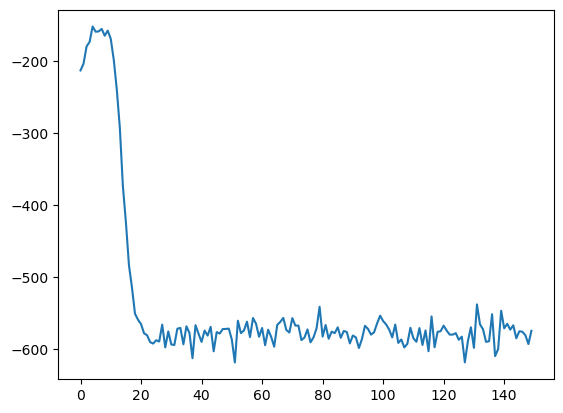

In [13]:
plt.plot(logs)
plt.show()

In [14]:
agent.save('Lunar_Lander')

In [16]:
agent.load('Lunar_Lander')

In [20]:
env = gym.make("LunarLander-v2")
agent.play(env, trajectory_len)
env.close()

In [21]:
class CEM(nn.Module):
    def __init__(self, state_dim, action_n):
        super().__init__()
        self.state_dim = state_dim
        self.action_n = action_n

        self.network = nn.Sequential(
                            nn.Linear(self.state_dim, 64),
                            #nn.Tanh(),
                            #nn.Linear(512, 256),
                            nn.ReLU(),
                            nn.Linear(64, self.action_n),
                            nn.Softmax() )
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=0.01)
        self.loss = nn.CrossEntropyLoss()
        
        self.uniform = 1/action_n #np.ones()/action_n
        
    def forward(self, state):
        return self.network(state)
        
    def get_action(self, state):
        state = torch.FloatTensor(state)
        action_prob = self.forward(state).detach().numpy()
        action_prob = 0.7*action_prob + 0.3*self.uniform       #!!!!!!
        action = np.random.choice(np.arange(action_n), p=action_prob)
        
        return action
    
    def update_policy(self, elite_trajectories):
        elite_states =[]
        elite_actions = []
        
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        
        elite_states = torch.FloatTensor(elite_states)
        elite_actions = torch.LongTensor(elite_actions)
        
        loss = self.loss(self.forward(elite_states), elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        
    def get_trajectory(self, env, trajectory_len, vizualize=False):
        trajectory = {'states': [], 'actions': [], 'total_reward': 0}
        
        state = env.reset()
        for i in range(trajectory_len):
            trajectory['states'].append(state)
            
            action = self.get_action(state)
            trajectory['actions'].append(action)
            state, reward, done, _ = env.step(action)
            
            trajectory['total_reward'] += reward
            
            if done:
                break
                
            if vizualize:
                env.render()
                time.sleep(0.05)
                
        return trajectory
            
    def get_elite_trajectories(self, trajectories, q_param):
        total_rewards = [trj['total_reward'] for trj in trajectories]
        quantile = np.quantile(total_rewards, q=q_param)
        return [trajectory for trajectory in trajectories if trajectory['total_reward'] >= quantile]
    
    
    def train(self, env, epochs, trajectory_len, trajectory_n, q_param, learning_rate=0.01):
        
        history = []
        
        for i in tqdm(range(epochs)):
            trajectories = [self.get_trajectory(env, trajectory_len) for _ in range(trajectory_n)]
            
            mean_total_reward = np.mean([trj['total_reward'] for trj in trajectories])
            history.append(mean_total_reward)
            
            elite = self.get_elite_trajectories(trajectories, q_param)
            
            if len(elite) > 0:
                self.update_policy(elite)
                
            print(f'epoch = {i}, \n total reward = {mean_total_reward}')
            
        return history
    
            
    def play(self, env, trajectory_len):
        self.get_trajectory(env, trajectory_len, vizualize=True)
        
    def save(self, path):
        torch.save(self.network, path)
        
    def load(self, path):
        self.network = torch.load(path)
        self.network.eval()
    

In [22]:
env = gym.make("LunarLander-v2")

state_dim = env.observation_space.shape[0]
action_n = env.action_space.n

epochs = 250
trajectory_len = 500
trajectory_n = 150
q_param = 0.5

agent = CEM(state_dim, action_n)

In [23]:
logs = agent.train(env, epochs, trajectory_len, trajectory_n, q_param)

  0%|▎                                                                                 | 1/250 [00:09<38:44,  9.34s/it]

epoch = 0, 
 total reward = -181.99952443605227


  1%|▋                                                                                 | 2/250 [00:20<43:47, 10.59s/it]

epoch = 1, 
 total reward = -169.9899862171015


  1%|▉                                                                                 | 3/250 [00:32<45:01, 10.94s/it]

epoch = 2, 
 total reward = -165.19846627781905


  2%|█▎                                                                                | 4/250 [00:43<46:12, 11.27s/it]

epoch = 3, 
 total reward = -178.40382887993738


  2%|█▋                                                                                | 5/250 [00:56<48:15, 11.82s/it]

epoch = 4, 
 total reward = -203.2528710125136


  2%|█▉                                                                                | 6/250 [01:10<50:40, 12.46s/it]

epoch = 5, 
 total reward = -236.29058987398244


  3%|██▎                                                                               | 7/250 [01:24<52:49, 13.04s/it]

epoch = 6, 
 total reward = -241.58696654894055


  3%|██▌                                                                               | 8/250 [01:39<54:24, 13.49s/it]

epoch = 7, 
 total reward = -276.0600663721219


  4%|██▉                                                                               | 9/250 [01:56<59:35, 14.83s/it]

epoch = 8, 
 total reward = -310.5962730207768


  4%|███▏                                                                           | 10/250 [02:14<1:02:49, 15.70s/it]

epoch = 9, 
 total reward = -357.37930802173736


  4%|███▍                                                                           | 11/250 [02:31<1:03:43, 16.00s/it]

epoch = 10, 
 total reward = -444.03535339257564


  5%|███▊                                                                           | 12/250 [02:47<1:04:11, 16.18s/it]

epoch = 11, 
 total reward = -491.38555860809225


  5%|████                                                                           | 13/250 [03:06<1:06:45, 16.90s/it]

epoch = 12, 
 total reward = -506.63806976027047


  6%|████▍                                                                          | 14/250 [03:23<1:07:16, 17.10s/it]

epoch = 13, 
 total reward = -523.9373953645154


  6%|████▋                                                                          | 15/250 [03:42<1:08:42, 17.54s/it]

epoch = 14, 
 total reward = -573.2929472087359


  6%|█████                                                                          | 16/250 [04:01<1:10:00, 17.95s/it]

epoch = 15, 
 total reward = -576.0832080623666


  7%|█████▎                                                                         | 17/250 [04:21<1:11:48, 18.49s/it]

epoch = 16, 
 total reward = -555.5369854494412


  7%|█████▋                                                                         | 18/250 [04:38<1:10:27, 18.22s/it]

epoch = 17, 
 total reward = -630.6900873304719


  8%|██████                                                                         | 19/250 [04:57<1:10:54, 18.42s/it]

epoch = 18, 
 total reward = -609.3716355832066


  8%|██████▎                                                                        | 20/250 [05:16<1:10:57, 18.51s/it]

epoch = 19, 
 total reward = -589.2579276461724


  8%|██████▋                                                                        | 21/250 [05:34<1:10:27, 18.46s/it]

epoch = 20, 
 total reward = -607.667045422236


  9%|██████▉                                                                        | 22/250 [05:54<1:11:49, 18.90s/it]

epoch = 21, 
 total reward = -598.1679669875357


  9%|███████▎                                                                       | 23/250 [06:14<1:12:25, 19.14s/it]

epoch = 22, 
 total reward = -599.0535720142672


 10%|███████▌                                                                       | 24/250 [06:30<1:08:27, 18.17s/it]

epoch = 23, 
 total reward = -579.1872176990508


 10%|███████▉                                                                       | 25/250 [06:45<1:05:05, 17.36s/it]

epoch = 24, 
 total reward = -592.020825580304


 10%|████████▏                                                                      | 26/250 [07:01<1:03:27, 17.00s/it]

epoch = 25, 
 total reward = -569.3034366410832


 11%|████████▌                                                                      | 27/250 [07:17<1:01:55, 16.66s/it]

epoch = 26, 
 total reward = -608.1688393161417


 11%|████████▊                                                                      | 28/250 [07:36<1:03:33, 17.18s/it]

epoch = 27, 
 total reward = -576.1948834284049


 12%|█████████▏                                                                     | 29/250 [07:53<1:03:16, 17.18s/it]

epoch = 28, 
 total reward = -564.0592566013939


 12%|█████████▍                                                                     | 30/250 [08:11<1:03:45, 17.39s/it]

epoch = 29, 
 total reward = -585.3829771336773


 12%|█████████▊                                                                     | 31/250 [08:29<1:04:17, 17.61s/it]

epoch = 30, 
 total reward = -557.0013909670425


 13%|██████████                                                                     | 32/250 [08:46<1:03:17, 17.42s/it]

epoch = 31, 
 total reward = -620.0413675192841


 13%|██████████▋                                                                      | 33/250 [08:57<56:02, 15.50s/it]

epoch = 32, 
 total reward = -620.6531902968368


 14%|███████████                                                                      | 34/250 [09:16<59:34, 16.55s/it]

epoch = 33, 
 total reward = -607.614089944289


 14%|███████████                                                                    | 35/250 [09:34<1:00:44, 16.95s/it]

epoch = 34, 
 total reward = -598.4935574313939


 14%|███████████▋                                                                     | 36/250 [09:46<55:35, 15.59s/it]

epoch = 35, 
 total reward = -647.1166465930544


 15%|███████████▋                                                                   | 37/250 [10:09<1:02:40, 17.65s/it]

epoch = 36, 
 total reward = -609.3761359698116


 15%|████████████                                                                   | 38/250 [10:27<1:02:50, 17.79s/it]

epoch = 37, 
 total reward = -646.1092911668824


 16%|████████████▎                                                                  | 39/250 [10:43<1:01:11, 17.40s/it]

epoch = 38, 
 total reward = -571.141538133288


 16%|████████████▋                                                                  | 40/250 [11:00<1:00:14, 17.21s/it]

epoch = 39, 
 total reward = -616.4149197717365


 16%|█████████████▎                                                                   | 41/250 [11:15<57:34, 16.53s/it]

epoch = 40, 
 total reward = -589.6262669909607


 17%|█████████████▌                                                                   | 42/250 [11:33<58:54, 16.99s/it]

epoch = 41, 
 total reward = -634.4848444627746


 17%|█████████████▉                                                                   | 43/250 [11:48<56:50, 16.47s/it]

epoch = 42, 
 total reward = -600.5596080063731


 18%|██████████████▎                                                                  | 44/250 [11:59<50:28, 14.70s/it]

epoch = 43, 
 total reward = -579.207536788348


 18%|██████████████▌                                                                  | 45/250 [12:18<54:58, 16.09s/it]

epoch = 44, 
 total reward = -611.6805549710506


 18%|██████████████▉                                                                  | 46/250 [12:38<58:10, 17.11s/it]

epoch = 45, 
 total reward = -609.844334165365


 19%|███████████████▏                                                                 | 47/250 [12:55<58:08, 17.19s/it]

epoch = 46, 
 total reward = -588.2448391424388


 19%|███████████████▌                                                                 | 48/250 [13:06<51:32, 15.31s/it]

epoch = 47, 
 total reward = -584.2710568312751


 20%|███████████████▉                                                                 | 49/250 [13:22<51:54, 15.49s/it]

epoch = 48, 
 total reward = -593.2536609348476


 20%|████████████████▏                                                                | 50/250 [13:39<53:43, 16.12s/it]

epoch = 49, 
 total reward = -594.7167013925001


 20%|████████████████▌                                                                | 51/250 [14:01<58:56, 17.77s/it]

epoch = 50, 
 total reward = -594.4681988184618


 21%|████████████████▍                                                              | 52/250 [14:21<1:01:10, 18.54s/it]

epoch = 51, 
 total reward = -589.2422294680912


 21%|█████████████████▏                                                               | 53/250 [14:39<59:31, 18.13s/it]

epoch = 52, 
 total reward = -584.2777451178391


 22%|█████████████████▍                                                               | 54/250 [14:54<57:02, 17.46s/it]

epoch = 53, 
 total reward = -597.6505432045898


 22%|█████████████████▊                                                               | 55/250 [15:11<55:31, 17.09s/it]

epoch = 54, 
 total reward = -602.4250823098615


 22%|██████████████████▏                                                              | 56/250 [15:28<55:23, 17.13s/it]

epoch = 55, 
 total reward = -602.9658450210321


 23%|██████████████████▍                                                              | 57/250 [15:44<54:01, 16.80s/it]

epoch = 56, 
 total reward = -608.0396378328134


 23%|██████████████████▊                                                              | 58/250 [16:01<54:05, 16.90s/it]

epoch = 57, 
 total reward = -574.6691313865288


 24%|███████████████████                                                              | 59/250 [16:20<55:48, 17.53s/it]

epoch = 58, 
 total reward = -580.016286197605


 24%|███████████████████▍                                                             | 60/250 [16:38<56:10, 17.74s/it]

epoch = 59, 
 total reward = -592.0410842228237


 24%|███████████████████▊                                                             | 61/250 [16:56<55:31, 17.63s/it]

epoch = 60, 
 total reward = -581.5987158820315


 25%|████████████████████                                                             | 62/250 [17:14<55:40, 17.77s/it]

epoch = 61, 
 total reward = -620.5041171191672


 25%|████████████████████▍                                                            | 63/250 [17:31<54:40, 17.54s/it]

epoch = 62, 
 total reward = -609.2819896323457


 26%|████████████████████▋                                                            | 64/250 [17:45<51:14, 16.53s/it]

epoch = 63, 
 total reward = -556.3438845161696


 26%|█████████████████████                                                            | 65/250 [18:01<50:55, 16.52s/it]

epoch = 64, 
 total reward = -563.9242736604524


 26%|█████████████████████▍                                                           | 66/250 [18:13<45:53, 14.96s/it]

epoch = 65, 
 total reward = -602.1141570836307


 27%|█████████████████████▋                                                           | 67/250 [18:28<46:00, 15.09s/it]

epoch = 66, 
 total reward = -554.9181163126717


 27%|██████████████████████                                                           | 68/250 [18:38<40:35, 13.38s/it]

epoch = 67, 
 total reward = -562.2276430843027


 28%|██████████████████████▎                                                          | 69/250 [18:54<43:20, 14.37s/it]

epoch = 68, 
 total reward = -614.390116643721


 28%|██████████████████████▋                                                          | 70/250 [19:11<45:02, 15.01s/it]

epoch = 69, 
 total reward = -553.5468668883739


 28%|███████████████████████                                                          | 71/250 [19:25<44:04, 14.77s/it]

epoch = 70, 
 total reward = -584.4503581302107


 29%|███████████████████████▎                                                         | 72/250 [19:42<45:56, 15.49s/it]

epoch = 71, 
 total reward = -617.0991647722014


 29%|███████████████████████▋                                                         | 73/250 [19:58<45:38, 15.47s/it]

epoch = 72, 
 total reward = -609.9204392408772


 30%|███████████████████████▉                                                         | 74/250 [20:13<45:11, 15.41s/it]

epoch = 73, 
 total reward = -610.9547998720005


 30%|████████████████████████▎                                                        | 75/250 [20:29<45:32, 15.62s/it]

epoch = 74, 
 total reward = -586.6870003323822


 30%|████████████████████████▌                                                        | 76/250 [20:45<45:38, 15.74s/it]

epoch = 75, 
 total reward = -597.1171523801713


 31%|████████████████████████▉                                                        | 77/250 [20:57<42:11, 14.63s/it]

epoch = 76, 
 total reward = -613.3738499605254


 31%|█████████████████████████▎                                                       | 78/250 [21:11<41:16, 14.40s/it]

epoch = 77, 
 total reward = -579.3366982602885


 32%|█████████████████████████▌                                                       | 79/250 [21:25<40:48, 14.32s/it]

epoch = 78, 
 total reward = -589.6786199047034


 32%|█████████████████████████▉                                                       | 80/250 [21:39<40:30, 14.30s/it]

epoch = 79, 
 total reward = -613.533912135419


 32%|██████████████████████████▏                                                      | 81/250 [21:53<39:56, 14.18s/it]

epoch = 80, 
 total reward = -571.8919299227762


 33%|██████████████████████████▌                                                      | 82/250 [22:07<39:18, 14.04s/it]

epoch = 81, 
 total reward = -618.2275200716956


 33%|██████████████████████████▉                                                      | 83/250 [22:24<41:41, 14.98s/it]

epoch = 82, 
 total reward = -623.936916169745


 34%|███████████████████████████▏                                                     | 84/250 [22:42<44:10, 15.97s/it]

epoch = 83, 
 total reward = -642.5792108143421


 34%|███████████████████████████▌                                                     | 85/250 [22:58<43:47, 15.92s/it]

epoch = 84, 
 total reward = -597.0097907397757


 34%|███████████████████████████▊                                                     | 86/250 [23:15<44:06, 16.14s/it]

epoch = 85, 
 total reward = -605.9159052784462


 35%|████████████████████████████▏                                                    | 87/250 [23:32<45:10, 16.63s/it]

epoch = 86, 
 total reward = -611.3484804828776


 35%|████████████████████████████▌                                                    | 88/250 [23:42<38:48, 14.37s/it]

epoch = 87, 
 total reward = -544.7810400967684


 36%|████████████████████████████▊                                                    | 89/250 [23:57<39:25, 14.69s/it]

epoch = 88, 
 total reward = -625.7494138035674


 36%|█████████████████████████████▏                                                   | 90/250 [24:11<38:44, 14.53s/it]

epoch = 89, 
 total reward = -570.6884128259508


 36%|█████████████████████████████▍                                                   | 91/250 [24:25<38:13, 14.42s/it]

epoch = 90, 
 total reward = -575.8785182079413


 37%|█████████████████████████████▊                                                   | 92/250 [24:40<37:59, 14.43s/it]

epoch = 91, 
 total reward = -580.2268954199706


 37%|██████████████████████████████▏                                                  | 93/250 [24:55<38:16, 14.63s/it]

epoch = 92, 
 total reward = -565.6923855529351


 38%|██████████████████████████████▍                                                  | 94/250 [25:07<35:58, 13.84s/it]

epoch = 93, 
 total reward = -641.416274530609


 38%|██████████████████████████████▊                                                  | 95/250 [25:18<33:35, 13.01s/it]

epoch = 94, 
 total reward = -619.9518800848266


 38%|███████████████████████████████                                                  | 96/250 [25:33<34:36, 13.48s/it]

epoch = 95, 
 total reward = -608.8059265263577


 39%|███████████████████████████████▍                                                 | 97/250 [25:49<36:28, 14.30s/it]

epoch = 96, 
 total reward = -627.1124712004098


 39%|███████████████████████████████▊                                                 | 98/250 [26:02<35:18, 13.94s/it]

epoch = 97, 
 total reward = -604.1313015543295


 40%|████████████████████████████████                                                 | 99/250 [26:13<33:12, 13.19s/it]

epoch = 98, 
 total reward = -605.539917018499


 40%|████████████████████████████████                                                | 100/250 [26:30<35:37, 14.25s/it]

epoch = 99, 
 total reward = -621.1096262770556


 40%|████████████████████████████████▎                                               | 101/250 [26:45<35:41, 14.37s/it]

epoch = 100, 
 total reward = -593.699355650716


 41%|████████████████████████████████▋                                               | 102/250 [27:00<36:10, 14.66s/it]

epoch = 101, 
 total reward = -596.9380826445314


 41%|████████████████████████████████▉                                               | 103/250 [27:17<37:48, 15.43s/it]

epoch = 102, 
 total reward = -607.5137105305078


 42%|█████████████████████████████████▎                                              | 104/250 [27:32<37:07, 15.26s/it]

epoch = 103, 
 total reward = -536.8180175420221


 42%|█████████████████████████████████▌                                              | 105/250 [27:47<36:57, 15.29s/it]

epoch = 104, 
 total reward = -583.9971703962174


 42%|█████████████████████████████████▉                                              | 106/250 [27:59<34:04, 14.20s/it]

epoch = 105, 
 total reward = -594.3678990360702


 43%|██████████████████████████████████▏                                             | 107/250 [28:16<36:07, 15.16s/it]

epoch = 106, 
 total reward = -627.4897447435422


 43%|██████████████████████████████████▌                                             | 108/250 [28:32<35:48, 15.13s/it]

epoch = 107, 
 total reward = -583.088723720665


 44%|██████████████████████████████████▉                                             | 109/250 [28:46<35:09, 14.96s/it]

epoch = 108, 
 total reward = -602.0140940569463


 44%|███████████████████████████████████▏                                            | 110/250 [28:58<32:51, 14.08s/it]

epoch = 109, 
 total reward = -598.4707276209318


 44%|███████████████████████████████████▌                                            | 111/250 [29:14<33:32, 14.48s/it]

epoch = 110, 
 total reward = -590.0077190260196


 45%|███████████████████████████████████▊                                            | 112/250 [29:28<33:35, 14.61s/it]

epoch = 111, 
 total reward = -572.4605298332373


 45%|████████████████████████████████████▏                                           | 113/250 [29:43<33:00, 14.46s/it]

epoch = 112, 
 total reward = -575.2151624479483


 46%|████████████████████████████████████▍                                           | 114/250 [29:59<34:09, 15.07s/it]

epoch = 113, 
 total reward = -604.9238547934982


 46%|████████████████████████████████████▊                                           | 115/250 [30:13<33:27, 14.87s/it]

epoch = 114, 
 total reward = -577.7780081321275


 46%|█████████████████████████████████████                                           | 116/250 [30:27<32:36, 14.60s/it]

epoch = 115, 
 total reward = -568.966429747407


 47%|█████████████████████████████████████▍                                          | 117/250 [30:40<31:03, 14.01s/it]

epoch = 116, 
 total reward = -595.5485348835363


 47%|█████████████████████████████████████▊                                          | 118/250 [30:56<31:46, 14.44s/it]

epoch = 117, 
 total reward = -576.3130636815275


 48%|██████████████████████████████████████                                          | 119/250 [31:10<31:15, 14.32s/it]

epoch = 118, 
 total reward = -590.4248964136117


 48%|██████████████████████████████████████▍                                         | 120/250 [31:19<28:09, 13.00s/it]

epoch = 119, 
 total reward = -553.6837885145701


 48%|██████████████████████████████████████▋                                         | 121/250 [31:35<29:42, 13.82s/it]

epoch = 120, 
 total reward = -596.6473325669463


 49%|███████████████████████████████████████                                         | 122/250 [31:51<30:51, 14.47s/it]

epoch = 121, 
 total reward = -579.5115985523698


 49%|███████████████████████████████████████▎                                        | 123/250 [32:06<30:54, 14.60s/it]

epoch = 122, 
 total reward = -554.5256377668695


 50%|███████████████████████████████████████▋                                        | 124/250 [32:22<31:39, 15.07s/it]

epoch = 123, 
 total reward = -619.6488413941101


 50%|████████████████████████████████████████                                        | 125/250 [32:39<32:29, 15.60s/it]

epoch = 124, 
 total reward = -627.5239822380399


 50%|████████████████████████████████████████▎                                       | 126/250 [32:55<32:29, 15.72s/it]

epoch = 125, 
 total reward = -610.7637776202646


 51%|████████████████████████████████████████▋                                       | 127/250 [33:12<32:47, 15.99s/it]

epoch = 126, 
 total reward = -622.2624779156478


 51%|████████████████████████████████████████▉                                       | 128/250 [33:26<31:31, 15.51s/it]

epoch = 127, 
 total reward = -588.4104645198139


 52%|█████████████████████████████████████████▎                                      | 129/250 [33:42<31:46, 15.76s/it]

epoch = 128, 
 total reward = -625.4450798847639


 52%|█████████████████████████████████████████▌                                      | 130/250 [33:57<30:45, 15.38s/it]

epoch = 129, 
 total reward = -582.648388382216


 52%|█████████████████████████████████████████▉                                      | 131/250 [34:14<31:34, 15.92s/it]

epoch = 130, 
 total reward = -632.0880575857602


 53%|██████████████████████████████████████████▏                                     | 132/250 [34:28<30:19, 15.42s/it]

epoch = 131, 
 total reward = -609.799286159413


 53%|██████████████████████████████████████████▌                                     | 133/250 [34:43<29:28, 15.11s/it]

epoch = 132, 
 total reward = -594.8155105722276


 54%|██████████████████████████████████████████▉                                     | 134/250 [35:01<30:59, 16.03s/it]

epoch = 133, 
 total reward = -613.5385951633787


 54%|███████████████████████████████████████████▏                                    | 135/250 [35:17<30:55, 16.13s/it]

epoch = 134, 
 total reward = -591.3793070650454


 54%|███████████████████████████████████████████▌                                    | 136/250 [35:33<30:20, 15.97s/it]

epoch = 135, 
 total reward = -623.1349785246048


 55%|███████████████████████████████████████████▊                                    | 137/250 [35:50<30:28, 16.18s/it]

epoch = 136, 
 total reward = -618.5974322781748


 55%|████████████████████████████████████████████▏                                   | 138/250 [36:05<29:31, 15.82s/it]

epoch = 137, 
 total reward = -610.7636441272699


 56%|████████████████████████████████████████████▍                                   | 139/250 [36:19<28:31, 15.42s/it]

epoch = 138, 
 total reward = -595.015618685791


 56%|████████████████████████████████████████████▊                                   | 140/250 [36:29<25:24, 13.86s/it]

epoch = 139, 
 total reward = -573.0355726330648


 56%|█████████████████████████████████████████████                                   | 141/250 [36:43<25:07, 13.83s/it]

epoch = 140, 
 total reward = -596.7023906753354


 57%|█████████████████████████████████████████████▍                                  | 142/250 [36:57<24:57, 13.87s/it]

epoch = 141, 
 total reward = -585.8094449510162


 57%|█████████████████████████████████████████████▊                                  | 143/250 [37:11<24:41, 13.84s/it]

epoch = 142, 
 total reward = -609.5456594059237


 58%|██████████████████████████████████████████████                                  | 144/250 [37:25<24:26, 13.83s/it]

epoch = 143, 
 total reward = -560.0928347306548


 58%|██████████████████████████████████████████████▍                                 | 145/250 [37:33<21:34, 12.33s/it]

epoch = 144, 
 total reward = -560.349039327252


 58%|██████████████████████████████████████████████▋                                 | 146/250 [37:45<20:58, 12.10s/it]

epoch = 145, 
 total reward = -581.6917756667088


 59%|███████████████████████████████████████████████                                 | 147/250 [38:00<22:06, 12.88s/it]

epoch = 146, 
 total reward = -598.388080860583


 59%|███████████████████████████████████████████████▎                                | 148/250 [38:16<23:40, 13.93s/it]

epoch = 147, 
 total reward = -622.975124051351


 60%|███████████████████████████████████████████████▋                                | 149/250 [38:29<23:00, 13.67s/it]

epoch = 148, 
 total reward = -560.7388773560609


 60%|████████████████████████████████████████████████                                | 150/250 [38:42<22:28, 13.49s/it]

epoch = 149, 
 total reward = -574.4390449791854


 60%|████████████████████████████████████████████████▎                               | 151/250 [38:53<20:41, 12.54s/it]

epoch = 150, 
 total reward = -605.1074326358511


 61%|████████████████████████████████████████████████▋                               | 152/250 [39:02<19:12, 11.76s/it]

epoch = 151, 
 total reward = -583.4807182051376


 61%|████████████████████████████████████████████████▉                               | 153/250 [39:19<21:12, 13.12s/it]

epoch = 152, 
 total reward = -586.6361202507154


 62%|█████████████████████████████████████████████████▎                              | 154/250 [39:37<23:13, 14.52s/it]

epoch = 153, 
 total reward = -622.3954221028272


 62%|█████████████████████████████████████████████████▌                              | 155/250 [39:48<21:38, 13.66s/it]

epoch = 154, 
 total reward = -632.580298992462


 62%|█████████████████████████████████████████████████▉                              | 156/250 [39:59<19:54, 12.71s/it]

epoch = 155, 
 total reward = -574.278239903174


 63%|██████████████████████████████████████████████████▏                             | 157/250 [40:16<21:48, 14.07s/it]

epoch = 156, 
 total reward = -672.4154595799595


 63%|██████████████████████████████████████████████████▌                             | 158/250 [40:33<22:45, 14.84s/it]

epoch = 157, 
 total reward = -614.9625994137199


 64%|██████████████████████████████████████████████████▉                             | 159/250 [40:49<23:24, 15.44s/it]

epoch = 158, 
 total reward = -614.2058685933699


 64%|███████████████████████████████████████████████████▏                            | 160/250 [41:05<23:14, 15.50s/it]

epoch = 159, 
 total reward = -599.5888212388581


 64%|███████████████████████████████████████████████████▌                            | 161/250 [41:16<21:06, 14.23s/it]

epoch = 160, 
 total reward = -592.3433298019683


 65%|███████████████████████████████████████████████████▊                            | 162/250 [41:33<21:53, 14.93s/it]

epoch = 161, 
 total reward = -584.1671015233592


 65%|████████████████████████████████████████████████████▏                           | 163/250 [41:49<21:59, 15.17s/it]

epoch = 162, 
 total reward = -616.1911337615361


 66%|████████████████████████████████████████████████████▍                           | 164/250 [41:59<19:49, 13.83s/it]

epoch = 163, 
 total reward = -593.1784608444442


 66%|████████████████████████████████████████████████████▊                           | 165/250 [42:15<20:29, 14.47s/it]

epoch = 164, 
 total reward = -594.4309596027701


 66%|█████████████████████████████████████████████████████                           | 166/250 [42:30<20:30, 14.65s/it]

epoch = 165, 
 total reward = -587.4547286918888


 67%|█████████████████████████████████████████████████████▍                          | 167/250 [42:41<18:46, 13.57s/it]

epoch = 166, 
 total reward = -611.5286340835823


 67%|█████████████████████████████████████████████████████▊                          | 168/250 [42:53<17:56, 13.12s/it]

epoch = 167, 
 total reward = -669.9064804910877


 68%|██████████████████████████████████████████████████████                          | 169/250 [43:04<16:47, 12.44s/it]

epoch = 168, 
 total reward = -607.1573081015074


 68%|██████████████████████████████████████████████████████▍                         | 170/250 [43:17<16:48, 12.60s/it]

epoch = 169, 
 total reward = -616.7171358974794


 68%|██████████████████████████████████████████████████████▋                         | 171/250 [43:34<18:17, 13.90s/it]

epoch = 170, 
 total reward = -593.6608572858916


 69%|███████████████████████████████████████████████████████                         | 172/250 [43:48<18:03, 13.90s/it]

epoch = 171, 
 total reward = -557.1919412198396


 69%|███████████████████████████████████████████████████████▎                        | 173/250 [44:05<19:06, 14.89s/it]

epoch = 172, 
 total reward = -620.8284279277923


 70%|███████████████████████████████████████████████████████▋                        | 174/250 [44:18<17:56, 14.17s/it]

epoch = 173, 
 total reward = -596.996120998867


 70%|████████████████████████████████████████████████████████                        | 175/250 [44:34<18:32, 14.84s/it]

epoch = 174, 
 total reward = -611.7754571854891


 70%|████████████████████████████████████████████████████████▎                       | 176/250 [44:48<18:05, 14.67s/it]

epoch = 175, 
 total reward = -575.0529089766533


 71%|████████████████████████████████████████████████████████▋                       | 177/250 [45:02<17:18, 14.22s/it]

epoch = 176, 
 total reward = -571.0131262064093


 71%|████████████████████████████████████████████████████████▉                       | 178/250 [45:18<17:44, 14.78s/it]

epoch = 177, 
 total reward = -618.8488924703196


 72%|█████████████████████████████████████████████████████████▎                      | 179/250 [45:32<17:12, 14.54s/it]

epoch = 178, 
 total reward = -594.2724304533544


 72%|█████████████████████████████████████████████████████████▌                      | 180/250 [45:47<17:19, 14.85s/it]

epoch = 179, 
 total reward = -599.6711186968805


 72%|█████████████████████████████████████████████████████████▉                      | 181/250 [45:58<15:38, 13.61s/it]

epoch = 180, 
 total reward = -600.7258196969262


 73%|██████████████████████████████████████████████████████████▏                     | 182/250 [46:14<16:20, 14.42s/it]

epoch = 181, 
 total reward = -600.943196110509


 73%|██████████████████████████████████████████████████████████▌                     | 183/250 [46:30<16:29, 14.77s/it]

epoch = 182, 
 total reward = -578.9162796101585


 74%|██████████████████████████████████████████████████████████▉                     | 184/250 [46:47<16:55, 15.39s/it]

epoch = 183, 
 total reward = -638.0305213172314


 74%|███████████████████████████████████████████████████████████▏                    | 185/250 [47:02<16:47, 15.50s/it]

epoch = 184, 
 total reward = -555.7623268054139


 74%|███████████████████████████████████████████████████████████▌                    | 186/250 [47:21<17:39, 16.55s/it]

epoch = 185, 
 total reward = -622.3587716689535


 75%|███████████████████████████████████████████████████████████▊                    | 187/250 [47:40<17:58, 17.11s/it]

epoch = 186, 
 total reward = -604.9744820500964


 75%|████████████████████████████████████████████████████████████▏                   | 188/250 [47:58<17:56, 17.36s/it]

epoch = 187, 
 total reward = -597.2391296354682


 76%|████████████████████████████████████████████████████████████▍                   | 189/250 [48:09<15:44, 15.48s/it]

epoch = 188, 
 total reward = -616.42851827523


 76%|████████████████████████████████████████████████████████████▊                   | 190/250 [48:23<15:09, 15.16s/it]

epoch = 189, 
 total reward = -587.8492229836019


 76%|█████████████████████████████████████████████████████████████                   | 191/250 [48:40<15:25, 15.69s/it]

epoch = 190, 
 total reward = -646.3509503061805


 77%|█████████████████████████████████████████████████████████████▍                  | 192/250 [48:57<15:30, 16.05s/it]

epoch = 191, 
 total reward = -625.6108832085123


 77%|█████████████████████████████████████████████████████████████▊                  | 193/250 [49:12<14:53, 15.67s/it]

epoch = 192, 
 total reward = -635.4109825353877


 78%|██████████████████████████████████████████████████████████████                  | 194/250 [49:23<13:22, 14.32s/it]

epoch = 193, 
 total reward = -574.6689098336041


 78%|██████████████████████████████████████████████████████████████▍                 | 195/250 [49:36<12:40, 13.84s/it]

epoch = 194, 
 total reward = -545.9254386388899


 78%|██████████████████████████████████████████████████████████████▋                 | 196/250 [49:53<13:17, 14.77s/it]

epoch = 195, 
 total reward = -622.1202695423367


 79%|███████████████████████████████████████████████████████████████                 | 197/250 [50:08<13:17, 15.04s/it]

epoch = 196, 
 total reward = -592.7402188356232


 79%|███████████████████████████████████████████████████████████████▎                | 198/250 [50:24<13:13, 15.27s/it]

epoch = 197, 
 total reward = -571.8045526989798


 80%|███████████████████████████████████████████████████████████████▋                | 199/250 [50:42<13:29, 15.87s/it]

epoch = 198, 
 total reward = -601.0877599921564


 80%|████████████████████████████████████████████████████████████████                | 200/250 [51:01<14:00, 16.81s/it]

epoch = 199, 
 total reward = -620.2310275911593


 80%|████████████████████████████████████████████████████████████████▎               | 201/250 [51:19<14:06, 17.27s/it]

epoch = 200, 
 total reward = -594.5191854492944


 81%|████████████████████████████████████████████████████████████████▋               | 202/250 [51:29<12:03, 15.07s/it]

epoch = 201, 
 total reward = -602.9513694555258


 81%|████████████████████████████████████████████████████████████████▉               | 203/250 [51:45<12:03, 15.40s/it]

epoch = 202, 
 total reward = -592.9810346282238


 82%|█████████████████████████████████████████████████████████████████▎              | 204/250 [51:59<11:26, 14.93s/it]

epoch = 203, 
 total reward = -591.7316390644453


 82%|█████████████████████████████████████████████████████████████████▌              | 205/250 [52:14<11:10, 14.89s/it]

epoch = 204, 
 total reward = -604.3552504981959


 82%|█████████████████████████████████████████████████████████████████▉              | 206/250 [52:29<11:00, 15.01s/it]

epoch = 205, 
 total reward = -631.3430683791919


 83%|██████████████████████████████████████████████████████████████████▏             | 207/250 [52:40<09:54, 13.83s/it]

epoch = 206, 
 total reward = -571.2348310339559


 83%|██████████████████████████████████████████████████████████████████▌             | 208/250 [52:55<10:01, 14.33s/it]

epoch = 207, 
 total reward = -619.9769623799501


 84%|██████████████████████████████████████████████████████████████████▉             | 209/250 [53:08<09:22, 13.72s/it]

epoch = 208, 
 total reward = -631.6722464511091


 84%|███████████████████████████████████████████████████████████████████▏            | 210/250 [53:22<09:12, 13.81s/it]

epoch = 209, 
 total reward = -569.9099276759442


 84%|███████████████████████████████████████████████████████████████████▌            | 211/250 [53:33<08:29, 13.05s/it]

epoch = 210, 
 total reward = -586.8254266381624


 85%|███████████████████████████████████████████████████████████████████▊            | 212/250 [53:44<07:49, 12.36s/it]

epoch = 211, 
 total reward = -599.830895018189


 85%|████████████████████████████████████████████████████████████████████▏           | 213/250 [54:00<08:16, 13.42s/it]

epoch = 212, 
 total reward = -583.8064014234172


 86%|████████████████████████████████████████████████████████████████████▍           | 214/250 [54:19<09:01, 15.05s/it]

epoch = 213, 
 total reward = -638.1892694424602


 86%|████████████████████████████████████████████████████████████████████▊           | 215/250 [54:34<08:50, 15.17s/it]

epoch = 214, 
 total reward = -597.5803415846095


 86%|█████████████████████████████████████████████████████████████████████           | 216/250 [54:51<08:49, 15.58s/it]

epoch = 215, 
 total reward = -654.9382286416217


 87%|█████████████████████████████████████████████████████████████████████▍          | 217/250 [55:07<08:44, 15.88s/it]

epoch = 216, 
 total reward = -568.9090589133561


 87%|█████████████████████████████████████████████████████████████████████▊          | 218/250 [55:25<08:43, 16.35s/it]

epoch = 217, 
 total reward = -617.4048263654129


 88%|██████████████████████████████████████████████████████████████████████          | 219/250 [55:44<08:56, 17.31s/it]

epoch = 218, 
 total reward = -621.2050273890056


 88%|██████████████████████████████████████████████████████████████████████▍         | 220/250 [55:58<08:10, 16.36s/it]

epoch = 219, 
 total reward = -608.413792452278


 88%|██████████████████████████████████████████████████████████████████████▋         | 221/250 [56:12<07:32, 15.59s/it]

epoch = 220, 
 total reward = -565.084245553589


 89%|███████████████████████████████████████████████████████████████████████         | 222/250 [56:28<07:17, 15.63s/it]

epoch = 221, 
 total reward = -564.0620943198926


 89%|███████████████████████████████████████████████████████████████████████▎        | 223/250 [56:44<07:04, 15.73s/it]

epoch = 222, 
 total reward = -612.6489483757321


 90%|███████████████████████████████████████████████████████████████████████▋        | 224/250 [57:01<07:00, 16.17s/it]

epoch = 223, 
 total reward = -609.1406835648186


 90%|████████████████████████████████████████████████████████████████████████        | 225/250 [57:11<05:57, 14.32s/it]

epoch = 224, 
 total reward = -548.7504128626782


 90%|████████████████████████████████████████████████████████████████████████▎       | 226/250 [57:27<05:53, 14.72s/it]

epoch = 225, 
 total reward = -626.3064962904116


 91%|████████████████████████████████████████████████████████████████████████▋       | 227/250 [57:40<05:26, 14.18s/it]

epoch = 226, 
 total reward = -562.4046457130004


 91%|████████████████████████████████████████████████████████████████████████▉       | 228/250 [57:58<05:40, 15.47s/it]

epoch = 227, 
 total reward = -638.7132594631352


 92%|█████████████████████████████████████████████████████████████████████████▎      | 229/250 [58:17<05:47, 16.55s/it]

epoch = 228, 
 total reward = -612.8012013402592


 92%|█████████████████████████████████████████████████████████████████████████▌      | 230/250 [58:34<05:30, 16.52s/it]

epoch = 229, 
 total reward = -589.6158517095229


 92%|█████████████████████████████████████████████████████████████████████████▉      | 231/250 [58:50<05:14, 16.53s/it]

epoch = 230, 
 total reward = -580.1138873535137


 93%|██████████████████████████████████████████████████████████████████████████▏     | 232/250 [59:07<04:59, 16.65s/it]

epoch = 231, 
 total reward = -578.921072163084


 93%|██████████████████████████████████████████████████████████████████████████▌     | 233/250 [59:23<04:38, 16.40s/it]

epoch = 232, 
 total reward = -600.0052067103992


 94%|██████████████████████████████████████████████████████████████████████████▉     | 234/250 [59:39<04:23, 16.44s/it]

epoch = 233, 
 total reward = -571.597227989992


 94%|███████████████████████████████████████████████████████████████████████████▏    | 235/250 [59:57<04:12, 16.86s/it]

epoch = 234, 
 total reward = -632.0227835986888


 94%|█████████████████████████████████████████████████████████████████████████▋    | 236/250 [1:00:15<03:59, 17.10s/it]

epoch = 235, 
 total reward = -644.0955570744255


 95%|█████████████████████████████████████████████████████████████████████████▉    | 237/250 [1:00:31<03:39, 16.92s/it]

epoch = 236, 
 total reward = -618.5866315487518


 95%|██████████████████████████████████████████████████████████████████████████▎   | 238/250 [1:00:47<03:18, 16.57s/it]

epoch = 237, 
 total reward = -606.2210367293654


 96%|██████████████████████████████████████████████████████████████████████████▌   | 239/250 [1:01:01<02:54, 15.90s/it]

epoch = 238, 
 total reward = -578.128975753462


 96%|██████████████████████████████████████████████████████████████████████████▉   | 240/250 [1:01:15<02:32, 15.24s/it]

epoch = 239, 
 total reward = -585.1211499957653


 96%|███████████████████████████████████████████████████████████████████████████▏  | 241/250 [1:01:30<02:15, 15.01s/it]

epoch = 240, 
 total reward = -617.3144906679488


 97%|███████████████████████████████████████████████████████████████████████████▌  | 242/250 [1:01:43<01:56, 14.60s/it]

epoch = 241, 
 total reward = -570.3806448509806


 97%|███████████████████████████████████████████████████████████████████████████▊  | 243/250 [1:02:01<01:48, 15.45s/it]

epoch = 242, 
 total reward = -642.4378902729619


 98%|████████████████████████████████████████████████████████████████████████████▏ | 244/250 [1:02:16<01:32, 15.47s/it]

epoch = 243, 
 total reward = -568.6719305578343


 98%|████████████████████████████████████████████████████████████████████████████▍ | 245/250 [1:02:30<01:14, 14.94s/it]

epoch = 244, 
 total reward = -571.8824719642581


 98%|████████████████████████████████████████████████████████████████████████████▊ | 246/250 [1:02:45<01:00, 15.05s/it]

epoch = 245, 
 total reward = -632.4543479466936


 99%|█████████████████████████████████████████████████████████████████████████████ | 247/250 [1:03:04<00:48, 16.27s/it]

epoch = 246, 
 total reward = -634.045045435265


 99%|█████████████████████████████████████████████████████████████████████████████▍| 248/250 [1:03:22<00:33, 16.84s/it]

epoch = 247, 
 total reward = -621.0219321356828


100%|█████████████████████████████████████████████████████████████████████████████▋| 249/250 [1:03:40<00:17, 17.05s/it]

epoch = 248, 
 total reward = -618.1704368808835


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [1:03:55<00:00, 15.34s/it]

epoch = 249, 
 total reward = -574.3908376063915


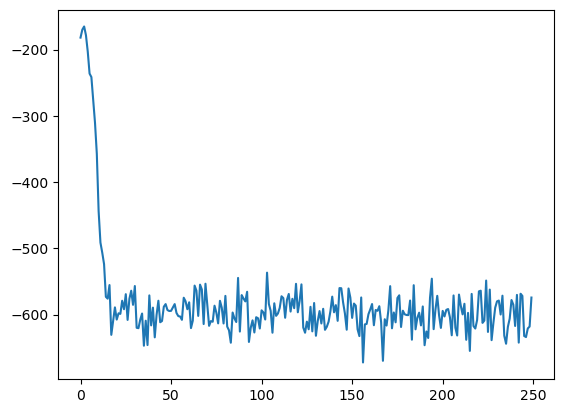

In [24]:
plt.plot(logs)
plt.show()

In [25]:
agent.save('Lunar_Lander')

In [16]:
agent.load('Lunar_Lander')

In [26]:
env = gym.make("LunarLander-v2")
agent.play(env, trajectory_len)
env.close()

### For continuous action space

In [7]:
class CEM(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        self.network = nn.Sequential(
                            nn.Linear(self.state_dim, 100),
                            nn.ReLU(),
                            nn.Linear(100, self.action_dim)
                            )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.008)
        self.loss = nn.MSELoss()
        
        
    def forward(self, state):
        return self.network(state)
        
    def get_action(self, state):
        state = torch.FloatTensor(state)
        action = self.forward(state).detach().numpy() # np.array(self.forward(state).detach())
        
        return action
       
        """
        if abs(action) <= 2:
            return action
        else:
            return np.sign(action)*2
        """
        
    def update_policy(self, elite_trajectories):
        elite_states =[]
        elite_actions = []
        
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        
        elite_states = torch.FloatTensor(elite_states)
        elite_actions = torch.FloatTensor(elite_actions)
        
        loss = self.loss(self.forward(elite_states), elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        
        return loss
        
    def get_trajectory(self, env, trajectory_len, vizualize=False):
        trajectory = {'states': [], 'actions': [], 'total_reward': 0}
        
        state = env.reset()
        for i in range(trajectory_len):
            trajectory['states'].append(state)
            
            action = self.get_action(state)
            trajectory['actions'].append(action)
            state, reward, done, _ = env.step(action)
            
            trajectory['total_reward'] += reward
            
            if done:
                break
                
            if vizualize:
                env.render()
                time.sleep(0.01)
                
        return trajectory
            
    def get_elite_trajectories(self, trajectories, q_param):
        total_rewards = [trj['total_reward'] for trj in trajectories]
        quantile = np.quantile(total_rewards, q=q_param)
        return [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]
    
    
    def train(self, env, epochs, trajectory_len, trajectory_n, q_param, learning_rate=0.01):
        
        rewards = []
        los = []
        
        for i in tqdm(range(epochs)):
            trajectories = [self.get_trajectory(env, trajectory_len) for _ in range(trajectory_n)]
            
            mean_total_reward = np.mean([trj['total_reward'] for trj in trajectories])
            rewards.append(mean_total_reward)
            
            elite = self.get_elite_trajectories(trajectories, q_param)
            
            if len(elite) > 0:
                l = self.update_policy(elite)
                los.append(l)
            
            if i % 10 == 0:
                self.save('checkpoint_1')
            print(f'epoch = {i}, total reward = {mean_total_reward}, loss = {los[i]}')
            
        return rewards, los
    
            
    def play(self, env, trajectory_len):
        self.get_trajectory(env, trajectory_len, vizualize=True)
        
    def save(self, path):
        torch.save(self.network, path)
        
    def load(self, path):
        self.network = torch.load(path)
        self.network.eval()
        

Попробуем использовать gpu (но пулчается медленее)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
class CEM_cuda(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        self.network = nn.Sequential(
                            nn.Linear(self.state_dim, 100),
                            nn.ReLU(),
                            nn.Linear(100, 42),
                            nn.ReLU(),
                            nn.Linear(42, 42),
                            nn.ReLU(),
                            nn.Linear(42, self.action_dim),
                            nn.Tanh()
                            #nn.Linear(42, self.action_dim)
                            )

        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=1)  #lr=0.7
        self.loss = nn.MSELoss()
        
        self.network.to(device)
        
    def forward(self, state):
        x = self.network(state)
        return x  #:gpu tensor     #.cpu().detach().numpy()
        
    def get_action(self, state):
        state = torch.FloatTensor(state).to(device)
        with torch.no_grad():
            action = self.forward(state).cpu().detach().numpy()
            
        return action  #: numpy
    
    def update_policy(self, elite_trajectories):
        elite_states =[]
        elite_actions = []
        
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        
        elite_states = torch.FloatTensor(elite_states).to(device)
        elite_actions = torch.FloatTensor(elite_actions).to(device)
        
        loss = self.loss(self.forward(elite_states), elite_actions)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        
    def get_trajectory(self, env, trajectory_len, vizualize=False):
        trajectory = {'states': [], 'actions': [], 'total_reward': 0}
        
        state = env.reset()
        for i in range(trajectory_len):
            trajectory['states'].append(state)
            
            action = self.get_action(state)
            trajectory['actions'].append(action)
            state, reward, done, _ = env.step(action)
            
            trajectory['total_reward'] += reward
            
            if done:
                break
                
            if vizualize:
                env.render()
                time.sleep(0.05)
                
        return trajectory
            
    def get_elite_trajectories(self, trajectories, q_param):
        total_rewards = [trj['total_reward'] for trj in trajectories]
        quantile = np.quantile(total_rewards, q=q_param)
        return [trajectory for trajectory in trajectories if trajectory['total_reward'] >= quantile]
    
    
    def train(self, env, epochs, trajectory_len, trajectory_n, q_param):
        
        history = []
        
        for i in tqdm(range(epochs)):
            trajectories = [self.get_trajectory(env, trajectory_len) for _ in range(trajectory_n)]
            
            mean_total_reward = np.mean([trj['total_reward'] for trj in trajectories])
            history.append(mean_total_reward)
            
            elite = self.get_elite_trajectories(trajectories, q_param)
            
            if len(elite) > 0:
                self.update_policy(elite)
                
            print(f'epoch = {i}, \ntotal reward = {mean_total_reward}')
            
            if i % 10 == 0:
                self.save('checkpoint')
            
        return history
    
            
    def play(self, env, trajectory_len):
        self.get_trajectory(env, trajectory_len, vizualize=True)
        
    def save(self, path):
        torch.save(self.network, path)
        
    def load(self, path):
        self.network = torch.load(path)
        self.network.eval()
    

In [8]:
env = gym.make("Pendulum-v1")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

epochs = 50
trajectory_len = 200
trajectory_n = 300
q_param = 0.8

agent = CEM_cuda(state_dim, action_dim)

logs = agent.train(env, epochs, trajectory_len, trajectory_n, q_param)

  2%|█▋                                                                                 | 1/50 [01:07<54:59, 67.33s/it]

epoch = 0, 
total reward = -1214.709953698183


  2%|█▌                                                                               | 1/50 [01:13<1:00:08, 73.65s/it]


KeyboardInterrupt: 

In [6]:
env = gym.make('MountainCarContinuous-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

epochs = 55
trajectory_len = 500  #1000
trajectory_n = 250  #500
q_param = 0.8

agent = CEM_cuda(state_dim, action_dim)

logs = agent.train(env, epochs, trajectory_len, trajectory_n, q_param)

  0%|                                                                                           | 0/55 [00:00<?, ?it/s]C:\Users\Egor\AppData\Local\Temp\ipykernel_16224\357503953.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  elite_states = torch.FloatTensor(elite_states).to(device)
  2%|█▍                                                                               | 1/55 [01:39<1:29:55, 99.92s/it]

epoch = 0, 
total reward = -1.341050811556443


  4%|██▉                                                                              | 2/55 [03:16<1:26:27, 97.88s/it]

epoch = 1, 
total reward = -2.354875897519375


  5%|████▍                                                                            | 3/55 [04:50<1:23:16, 96.08s/it]

epoch = 2, 
total reward = -3.36284013390979


  7%|█████▉                                                                           | 4/55 [06:24<1:20:59, 95.29s/it]

epoch = 3, 
total reward = -4.387630075431025


  9%|███████▎                                                                         | 5/55 [07:59<1:19:22, 95.26s/it]

epoch = 4, 
total reward = -4.904226009368916


 11%|████████▊                                                                        | 6/55 [09:32<1:17:10, 94.50s/it]

epoch = 5, 
total reward = -5.150306824465815


 13%|██████████▎                                                                      | 7/55 [11:08<1:16:04, 95.08s/it]

epoch = 6, 
total reward = -5.479522897119348


 15%|███████████▊                                                                     | 8/55 [12:42<1:14:13, 94.75s/it]

epoch = 7, 
total reward = -6.134221346339673


 16%|█████████████▎                                                                   | 9/55 [14:14<1:11:56, 93.85s/it]

epoch = 8, 
total reward = -6.918461062339612


 18%|██████████████▌                                                                 | 10/55 [15:49<1:10:35, 94.12s/it]

epoch = 9, 
total reward = -7.307437358172974


 20%|████████████████                                                                | 11/55 [17:21<1:08:27, 93.35s/it]

epoch = 10, 
total reward = -7.251757003525503


 22%|█████████████████▍                                                              | 12/55 [18:54<1:06:54, 93.36s/it]

epoch = 11, 
total reward = -7.106121002580412


 24%|██████████████████▉                                                             | 13/55 [20:28<1:05:29, 93.55s/it]

epoch = 12, 
total reward = -6.900200484257523


 25%|████████████████████▎                                                           | 14/55 [22:02<1:03:59, 93.64s/it]

epoch = 13, 
total reward = -7.374230027801373


 27%|█████████████████████▊                                                          | 15/55 [23:36<1:02:33, 93.83s/it]

epoch = 14, 
total reward = -7.850238963783366


 29%|███████████████████████▎                                                        | 16/55 [25:10<1:00:58, 93.81s/it]

epoch = 15, 
total reward = -8.243196351685857


 31%|█████████████████████████▎                                                        | 17/55 [26:46<59:46, 94.38s/it]

epoch = 16, 
total reward = -8.37492254534598


 33%|██████████████████████████▊                                                       | 18/55 [28:21<58:21, 94.64s/it]

epoch = 17, 
total reward = -8.278494242194387


 35%|████████████████████████████▎                                                     | 19/55 [29:55<56:38, 94.41s/it]

epoch = 18, 
total reward = -8.191541849207667


 36%|█████████████████████████████▊                                                    | 20/55 [31:31<55:20, 94.88s/it]

epoch = 19, 
total reward = -7.964532175928869


 38%|███████████████████████████████▎                                                  | 21/55 [33:11<54:38, 96.42s/it]

epoch = 20, 
total reward = -7.99835998549585


 40%|████████████████████████████████▊                                                 | 22/55 [34:56<54:29, 99.09s/it]

epoch = 21, 
total reward = -7.7817643927945515


 42%|█████████████████████████████████▊                                               | 23/55 [36:53<55:44, 104.53s/it]

epoch = 22, 
total reward = -7.663238550729251


 44%|███████████████████████████████████▎                                             | 24/55 [38:31<52:59, 102.56s/it]

epoch = 23, 
total reward = -7.7017691984795125


 45%|████████████████████████████████████▊                                            | 25/55 [40:11<50:47, 101.60s/it]

epoch = 24, 
total reward = -7.899651544788832


 47%|██████████████████████████████████████▊                                           | 26/55 [41:35<46:39, 96.53s/it]

epoch = 25, 
total reward = -7.992356430179524


 49%|████████████████████████████████████████▎                                         | 27/55 [43:00<43:25, 93.04s/it]

epoch = 26, 
total reward = -8.28981505040251


 51%|█████████████████████████████████████████▋                                        | 28/55 [44:26<40:55, 90.94s/it]

epoch = 27, 
total reward = -8.579216245478761


 53%|███████████████████████████████████████████▏                                      | 29/55 [45:51<38:40, 89.24s/it]

epoch = 28, 
total reward = -9.216489663098317


 55%|████████████████████████████████████████████▋                                     | 30/55 [47:17<36:40, 88.00s/it]

epoch = 29, 
total reward = -9.844533243792121


 56%|██████████████████████████████████████████████▏                                   | 31/55 [48:40<34:35, 86.50s/it]

epoch = 30, 
total reward = -10.36952518842437


 58%|███████████████████████████████████████████████▋                                  | 32/55 [50:08<33:20, 86.98s/it]

epoch = 31, 
total reward = -10.965003264159684


 60%|█████████████████████████████████████████████████▏                                | 33/55 [51:51<33:40, 91.83s/it]

epoch = 32, 
total reward = -11.332970761223427


 62%|██████████████████████████████████████████████████▋                               | 34/55 [53:30<32:57, 94.15s/it]

epoch = 33, 
total reward = -11.715558912099892


 64%|████████████████████████████████████████████████████▏                             | 35/55 [55:10<31:55, 95.76s/it]

epoch = 34, 
total reward = -12.354673710397297


 65%|█████████████████████████████████████████████████████▋                            | 36/55 [56:45<30:14, 95.49s/it]

epoch = 35, 
total reward = -12.79752128331005


 67%|███████████████████████████████████████████████████████▏                          | 37/55 [58:24<29:01, 96.74s/it]

epoch = 36, 
total reward = -13.59641099235339


 69%|██████████████████████████████████████████████████████▌                        | 38/55 [1:00:15<28:35, 100.88s/it]

epoch = 37, 
total reward = -13.751492343383648


 71%|████████████████████████████████████████████████████████▋                       | 39/55 [1:01:52<26:36, 99.81s/it]

epoch = 38, 
total reward = -13.96480045341733


 73%|█████████████████████████████████████████████████████████▍                     | 40/55 [1:03:36<25:12, 100.86s/it]

epoch = 39, 
total reward = -14.37500759162185


 75%|██████████████████████████████████████████████████████████▉                    | 41/55 [1:05:17<23:33, 100.98s/it]

epoch = 40, 
total reward = -15.105785808390298


 76%|████████████████████████████████████████████████████████████▎                  | 42/55 [1:07:00<22:02, 101.73s/it]

epoch = 41, 
total reward = -16.015595557447835


 78%|██████████████████████████████████████████████████████████████▌                 | 43/55 [1:08:30<19:37, 98.11s/it]

epoch = 42, 
total reward = -17.21028736007166


 80%|████████████████████████████████████████████████████████████████                | 44/55 [1:10:02<17:38, 96.26s/it]

epoch = 43, 
total reward = -18.53583222773767


 82%|█████████████████████████████████████████████████████████████████▍              | 45/55 [1:11:46<16:27, 98.75s/it]

epoch = 44, 
total reward = -19.77232429242164


 84%|██████████████████████████████████████████████████████████████████▉             | 46/55 [1:13:25<14:47, 98.64s/it]

epoch = 45, 
total reward = -20.51335735257053


 85%|████████████████████████████████████████████████████████████████████▎           | 47/55 [1:15:04<13:09, 98.72s/it]

epoch = 46, 
total reward = -21.463030131119353


 87%|█████████████████████████████████████████████████████████████████████▊          | 48/55 [1:16:35<11:15, 96.47s/it]

epoch = 47, 
total reward = -22.059834452156306


 89%|███████████████████████████████████████████████████████████████████████▎        | 49/55 [1:18:13<09:41, 96.86s/it]

epoch = 48, 
total reward = -22.90238088372387


 91%|████████████████████████████████████████████████████████████████████████▋       | 50/55 [1:19:56<08:14, 98.91s/it]

epoch = 49, 
total reward = -24.15332277075189


 93%|██████████████████████████████████████████████████████████████████████████▏     | 51/55 [1:21:35<06:35, 98.75s/it]

epoch = 50, 
total reward = -25.350305586937772


 95%|██████████████████████████████████████████████████████████████████████████▋    | 52/55 [1:23:29<05:09, 103.29s/it]

epoch = 51, 
total reward = -26.669808528453288


 96%|████████████████████████████████████████████████████████████████████████████▏  | 53/55 [1:25:08<03:23, 101.95s/it]

epoch = 52, 
total reward = -27.65595529631203


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 54/55 [1:26:50<01:41, 101.99s/it]

epoch = 53, 
total reward = -28.970696874490947


100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [1:28:28<00:00, 96.52s/it]

epoch = 54, 
total reward = -30.714730201035184


In [5]:
env = gym.make('MountainCarContinuous-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

epochs = 55
trajectory_len = 500  #1000
trajectory_n = 250  #500
q_param = 0.8

agent = CEM_cuda(state_dim, action_dim)

logs = agent.train(env, epochs, trajectory_len, trajectory_n, q_param)

  0%|                                                                                           | 0/55 [00:00<?, ?it/s]C:\Users\Egor\AppData\Local\Temp\ipykernel_2680\1819944865.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  elite_states = torch.FloatTensor(elite_states).to(device)
  2%|█▍                                                                               | 1/55 [01:28<1:19:22, 88.19s/it]

epoch = 0, 
total reward = -0.002062068445478946


  4%|██▉                                                                              | 2/55 [03:03<1:21:38, 92.42s/it]

epoch = 1, 
total reward = -0.0025354789704530225


  5%|████▍                                                                            | 3/55 [04:35<1:19:54, 92.20s/it]

epoch = 2, 
total reward = -0.07927351223335492


  7%|█████▉                                                                           | 4/55 [06:07<1:18:09, 91.96s/it]

epoch = 3, 
total reward = -0.43508693232991846


  9%|███████▎                                                                         | 5/55 [07:46<1:18:57, 94.75s/it]

epoch = 4, 
total reward = -1.5705248142366917


 11%|████████▊                                                                        | 6/55 [09:11<1:14:33, 91.29s/it]

epoch = 5, 
total reward = -3.285431300207747


 13%|██████████▎                                                                      | 7/55 [10:45<1:13:52, 92.33s/it]

epoch = 6, 
total reward = -4.900344318478487


 15%|███████████▊                                                                     | 8/55 [12:17<1:12:12, 92.18s/it]

epoch = 7, 
total reward = -6.804415991281817


 16%|█████████████▎                                                                   | 9/55 [13:45<1:09:34, 90.75s/it]

epoch = 8, 
total reward = -9.07971469750893


 18%|██████████████▌                                                                 | 10/55 [15:23<1:09:48, 93.08s/it]

epoch = 9, 
total reward = -10.217390244760956


 20%|████████████████                                                                | 11/55 [16:47<1:06:07, 90.18s/it]

epoch = 10, 
total reward = -11.720258529767154


 22%|█████████████████▍                                                              | 12/55 [18:16<1:04:24, 89.88s/it]

epoch = 11, 
total reward = -12.54866736912461


 24%|██████████████████▉                                                             | 13/55 [19:57<1:05:21, 93.36s/it]

epoch = 12, 
total reward = -14.361770223906161


 25%|████████████████████▎                                                           | 14/55 [21:28<1:03:13, 92.52s/it]

epoch = 13, 
total reward = -16.21293977661774


 27%|█████████████████████▊                                                          | 15/55 [22:54<1:00:19, 90.48s/it]

epoch = 14, 
total reward = -17.51742825091548


 29%|███████████████████████▊                                                          | 16/55 [24:26<59:08, 90.99s/it]

epoch = 15, 
total reward = -18.113449766422207


 31%|█████████████████████████▎                                                        | 17/55 [25:48<55:58, 88.38s/it]

epoch = 16, 
total reward = -18.15102164736863


 33%|██████████████████████████▊                                                       | 18/55 [27:28<56:38, 91.86s/it]

epoch = 17, 
total reward = -19.60592933946224


 35%|████████████████████████████▎                                                     | 19/55 [28:58<54:45, 91.26s/it]

epoch = 18, 
total reward = -20.76266530043257


 36%|█████████████████████████████▊                                                    | 20/55 [30:31<53:30, 91.72s/it]

epoch = 19, 
total reward = -21.445515015120478


 38%|███████████████████████████████▎                                                  | 21/55 [32:00<51:31, 90.91s/it]

epoch = 20, 
total reward = -20.475772222073


 40%|████████████████████████████████▊                                                 | 22/55 [33:32<50:11, 91.26s/it]

epoch = 21, 
total reward = -20.06257454731115


 42%|██████████████████████████████████▎                                               | 23/55 [35:08<49:27, 92.72s/it]

epoch = 22, 
total reward = -20.683819823838327


 44%|███████████████████████████████████▊                                              | 24/55 [36:40<47:49, 92.56s/it]

epoch = 23, 
total reward = -21.639180931786417


 45%|█████████████████████████████████████▎                                            | 25/55 [38:08<45:35, 91.19s/it]

epoch = 24, 
total reward = -22.94173803497803


 47%|██████████████████████████████████████▊                                           | 26/55 [39:53<46:04, 95.31s/it]

epoch = 25, 
total reward = -24.36150041323348


 49%|████████████████████████████████████████▎                                         | 27/55 [41:32<44:56, 96.29s/it]

epoch = 26, 
total reward = -25.698422067949373


 51%|█████████████████████████████████████████▋                                        | 28/55 [43:14<44:06, 98.02s/it]

epoch = 27, 
total reward = -26.570106094414488


 53%|███████████████████████████████████████████▏                                      | 29/55 [44:54<42:45, 98.68s/it]

epoch = 28, 
total reward = -27.97295839009039


 55%|████████████████████████████████████████████▋                                     | 30/55 [46:37<41:36, 99.87s/it]

epoch = 29, 
total reward = -28.65419618964758


 56%|██████████████████████████████████████████████▏                                   | 31/55 [48:15<39:44, 99.35s/it]

epoch = 30, 
total reward = -29.111530076381506


 58%|███████████████████████████████████████████████▋                                  | 32/55 [49:44<36:55, 96.34s/it]

epoch = 31, 
total reward = -30.072042372822615


 60%|█████████████████████████████████████████████████▏                                | 33/55 [51:28<36:07, 98.50s/it]

epoch = 32, 
total reward = -29.902460410267338


 62%|██████████████████████████████████████████████████▋                               | 34/55 [52:58<33:35, 95.97s/it]

epoch = 33, 
total reward = -29.868896306790578


 64%|████████████████████████████████████████████████████▏                             | 35/55 [54:18<30:27, 91.36s/it]

epoch = 34, 
total reward = -29.760654552156943


 65%|█████████████████████████████████████████████████████▋                            | 36/55 [55:48<28:45, 90.84s/it]

epoch = 35, 
total reward = -29.338567310300395


 67%|███████████████████████████████████████████████████████▏                          | 37/55 [57:08<26:18, 87.67s/it]

epoch = 36, 
total reward = -28.7037154539516


 69%|████████████████████████████████████████████████████████▋                         | 38/55 [58:44<25:31, 90.11s/it]

epoch = 37, 
total reward = -28.051821115856523


 71%|████████████████████████████████████████████████████████▋                       | 39/55 [1:00:15<24:08, 90.53s/it]

epoch = 38, 
total reward = -27.082666281125448


 73%|██████████████████████████████████████████████████████████▏                     | 40/55 [1:01:39<22:07, 88.51s/it]

epoch = 39, 
total reward = -26.290426536596424


 75%|███████████████████████████████████████████████████████████▋                    | 41/55 [1:03:07<20:34, 88.16s/it]

epoch = 40, 
total reward = -26.123770459913068


 76%|█████████████████████████████████████████████████████████████                   | 42/55 [1:04:34<19:03, 87.95s/it]

epoch = 41, 
total reward = -25.53192813737095


 78%|██████████████████████████████████████████████████████████████▌                 | 43/55 [1:06:05<17:47, 88.98s/it]

epoch = 42, 
total reward = -24.390919609252897


 80%|████████████████████████████████████████████████████████████████                | 44/55 [1:07:41<16:39, 90.87s/it]

epoch = 43, 
total reward = -22.78363562492458


 82%|█████████████████████████████████████████████████████████████████▍              | 45/55 [1:09:09<15:00, 90.01s/it]

epoch = 44, 
total reward = -21.407646168879598


 84%|██████████████████████████████████████████████████████████████████▉             | 46/55 [1:10:37<13:25, 89.51s/it]

epoch = 45, 
total reward = -20.452527597561435


 85%|████████████████████████████████████████████████████████████████████▎           | 47/55 [1:12:11<12:06, 90.77s/it]

epoch = 46, 
total reward = -18.821002728210754


 87%|█████████████████████████████████████████████████████████████████████▊          | 48/55 [1:13:40<10:31, 90.23s/it]

epoch = 47, 
total reward = -16.474654983225932


 89%|███████████████████████████████████████████████████████████████████████▎        | 49/55 [1:15:18<09:15, 92.63s/it]

epoch = 48, 
total reward = -14.137502660585982


 91%|████████████████████████████████████████████████████████████████████████▋       | 50/55 [1:16:42<07:30, 90.08s/it]

epoch = 49, 
total reward = -12.495371771371826


 93%|██████████████████████████████████████████████████████████████████████████▏     | 51/55 [1:18:16<06:05, 91.26s/it]

epoch = 50, 
total reward = -11.200223322451482


 95%|███████████████████████████████████████████████████████████████████████████▋    | 52/55 [1:19:55<04:40, 93.57s/it]

epoch = 51, 
total reward = -9.461563190603869


 96%|█████████████████████████████████████████████████████████████████████████████   | 53/55 [1:21:23<03:03, 91.78s/it]

epoch = 52, 
total reward = -8.178866244368127


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 54/55 [1:23:01<01:33, 93.63s/it]

epoch = 53, 
total reward = -7.087277887116894


100%|████████████████████████████████████████████████████████████████████████████████| 55/55 [1:24:33<00:00, 92.25s/it]

epoch = 54, 
total reward = -6.275641875278384


In [ ]:
plt.plot(logs)
plt.grid()
plt.show()

In [13]:
env = gym.make("MountainCarContinuous-v0")
agent.play(env, trajectory_len)
env.close()

C:\Users\Egor\anaconda3\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Изменение режима для потока после его установки невозможно
  warnings.warn(str(err))


In [5]:
#lr=0.3
env = gym.make('MountainCarContinuous-v0')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

epochs = 350
trajectory_len = 999
trajectory_n = 150
q_param = 0.7

agent = CEM(state_dim, action_dim)

In [ ]:
logs = agent.train(env, epochs, trajectory_len, trajectory_n, q_param)

  0%|                                                                                          | 0/350 [00:00<?, ?it/s]

epoch = 0, 
 total reward = -1.0833453383480385


C:\Users\Egor\AppData\Local\Temp\ipykernel_13864\1862638750.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  elite_states = torch.FloatTensor(elite_states)
  0%|▏                                                                               | 1/350 [00:45<4:23:29, 45.30s/it]

epoch = 1, 
 total reward = -0.17338989484768183


  1%|▍                                                                               | 2/350 [01:32<4:30:45, 46.68s/it]

epoch = 2, 
 total reward = -3.33311794878443


  1%|▋                                                                               | 3/350 [02:18<4:26:02, 46.00s/it]

epoch = 3, 
 total reward = -18.436776319796344


  1%|▉                                                                               | 4/350 [03:20<5:02:52, 52.52s/it]

epoch = 4, 
 total reward = -22.933254590255505


  1%|█▏                                                                              | 5/350 [04:15<5:06:16, 53.27s/it]

epoch = 5, 
 total reward = -20.577110608520275


  2%|█▎                                                                              | 6/350 [05:03<4:56:09, 51.66s/it]

epoch = 6, 
 total reward = -24.53081014547263


  2%|█▌                                                                              | 7/350 [05:53<4:51:29, 50.99s/it]

epoch = 7, 
 total reward = -31.359330643540247


  2%|█▊                                                                              | 8/350 [06:48<4:57:33, 52.20s/it]

epoch = 8, 
 total reward = -52.51491153787772


  3%|██                                                                              | 9/350 [07:52<5:18:44, 56.08s/it]

epoch = 9, 
 total reward = -72.68597308590269


  3%|██▎                                                                            | 10/350 [08:58<5:35:26, 59.19s/it]

epoch = 10, 
 total reward = -94.9270651171772


  3%|██▍                                                                            | 11/350 [09:28<4:43:40, 50.21s/it]

epoch = 11, 
 total reward = -54.021481834163566


  3%|██▋                                                                            | 12/350 [10:21<4:47:56, 51.11s/it]

epoch = 12, 
 total reward = -26.678899008237263


  4%|██▉                                                                            | 13/350 [11:23<5:05:00, 54.30s/it]

epoch = 13, 
 total reward = -14.790605312164923


  4%|███▏                                                                           | 14/350 [12:19<5:06:49, 54.79s/it]

epoch = 14, 
 total reward = -6.635134173056752


  4%|███▍                                                                           | 15/350 [13:14<5:06:22, 54.87s/it]

epoch = 15, 
 total reward = -2.8586665280295023


  5%|███▌                                                                           | 16/350 [14:09<5:05:12, 54.83s/it]

epoch = 16, 
 total reward = -0.6564773303303855


  5%|███▊                                                                           | 17/350 [15:07<5:09:18, 55.73s/it]

epoch = 17, 
 total reward = -0.03542252107804674


  5%|████                                                                           | 18/350 [16:09<5:19:13, 57.69s/it]

epoch = 18, 
 total reward = -0.09557303233051608


  5%|████▎                                                                          | 19/350 [17:03<5:11:35, 56.48s/it]

epoch = 19, 
 total reward = -0.5424598117860838


  6%|████▌                                                                          | 20/350 [17:51<4:57:32, 54.10s/it]

epoch = 20, 
 total reward = -1.1899615439642426


  6%|████▋                                                                          | 21/350 [18:31<4:33:39, 49.91s/it]

epoch = 21, 
 total reward = -2.093923856614687


  6%|████▉                                                                          | 22/350 [19:35<4:54:47, 53.93s/it]

epoch = 22, 
 total reward = -2.753446535845284


  7%|█████▏                                                                         | 23/350 [20:30<4:55:58, 54.31s/it]

epoch = 23, 
 total reward = -3.2694733008553643


  7%|█████▍                                                                         | 24/350 [21:17<4:43:03, 52.10s/it]

epoch = 24, 
 total reward = -3.815225425364593


  7%|█████▋                                                                         | 25/350 [22:05<4:35:37, 50.88s/it]

epoch = 25, 
 total reward = -4.5663370444932845


  7%|█████▊                                                                         | 26/350 [22:56<4:34:39, 50.86s/it]

epoch = 26, 
 total reward = -5.30303013242659


  8%|██████                                                                         | 27/350 [23:37<4:18:58, 48.11s/it]

epoch = 27, 
 total reward = -5.435739598300971


  8%|██████▎                                                                        | 28/350 [24:24<4:16:46, 47.85s/it]

epoch = 28, 
 total reward = -5.288670498157558


  8%|██████▌                                                                        | 29/350 [25:06<4:05:53, 45.96s/it]

epoch = 29, 
 total reward = -5.078521679661009


  9%|██████▊                                                                        | 30/350 [25:57<4:13:32, 47.54s/it]

epoch = 30, 
 total reward = -4.838298890475739


  9%|██████▉                                                                        | 31/350 [26:51<4:22:32, 49.38s/it]

epoch = 31, 
 total reward = -4.7842819447063825


  9%|███████▏                                                                       | 32/350 [27:46<4:30:58, 51.13s/it]

epoch = 32, 
 total reward = -4.655699681614157


  9%|███████▍                                                                       | 33/350 [28:34<4:25:40, 50.29s/it]

epoch = 33, 
 total reward = -4.7706982039438754


 10%|███████▋                                                                       | 34/350 [29:20<4:17:51, 48.96s/it]

epoch = 34, 
 total reward = -4.884065635864892


 10%|███████▉                                                                       | 35/350 [29:58<3:59:40, 45.65s/it]

epoch = 35, 
 total reward = -5.02808136817708


 10%|████████▏                                                                      | 36/350 [30:51<4:10:33, 47.88s/it]

epoch = 36, 
 total reward = -5.284165448913933


 11%|████████▎                                                                      | 37/350 [31:33<4:00:36, 46.12s/it]

epoch = 37, 
 total reward = -5.528037537684081


 11%|████████▌                                                                      | 38/350 [32:24<4:06:09, 47.34s/it]

epoch = 38, 
 total reward = -5.581512525592607


 11%|████████▊                                                                      | 39/350 [33:14<4:09:41, 48.17s/it]

epoch = 39, 
 total reward = -5.6146986051657075


 11%|█████████                                                                      | 40/350 [34:04<4:11:56, 48.76s/it]

epoch = 40, 
 total reward = -5.693696087378005


 12%|█████████▎                                                                     | 41/350 [35:04<4:28:47, 52.19s/it]

epoch = 41, 
 total reward = -6.197243368213198


 12%|█████████▍                                                                     | 42/350 [35:54<4:23:58, 51.42s/it]

epoch = 42, 
 total reward = -6.226842916581648


 12%|█████████▋                                                                     | 43/350 [36:56<4:40:32, 54.83s/it]

epoch = 43, 
 total reward = -6.355643182021352


 13%|█████████▉                                                                     | 44/350 [37:42<4:25:33, 52.07s/it]

epoch = 44, 
 total reward = -6.445595576288104


 13%|██████████▏                                                                    | 45/350 [38:30<4:19:04, 50.96s/it]

epoch = 45, 
 total reward = -6.638541312221101


 13%|██████████▍                                                                    | 46/350 [39:39<4:44:28, 56.15s/it]

epoch = 46, 
 total reward = -6.598752559080075


 13%|██████████▌                                                                    | 47/350 [40:33<4:41:06, 55.67s/it]

epoch = 47, 
 total reward = -6.632623440120946


 14%|██████████▊                                                                    | 48/350 [41:17<4:22:54, 52.23s/it]

epoch = 48, 
 total reward = -7.191624768747494


 14%|███████████                                                                    | 49/350 [42:05<4:15:09, 50.86s/it]

epoch = 49, 
 total reward = -7.570264296250564


 14%|███████████▎                                                                   | 50/350 [42:51<4:06:46, 49.36s/it]

epoch = 50, 
 total reward = -8.209782158935816


 15%|███████████▌                                                                   | 51/350 [43:44<4:11:27, 50.46s/it]

epoch = 51, 
 total reward = -8.68488613354029


 15%|███████████▋                                                                   | 52/350 [44:31<4:05:52, 49.50s/it]

epoch = 52, 
 total reward = -9.143214806174434


 15%|███████████▉                                                                   | 53/350 [45:16<3:58:00, 48.08s/it]

epoch = 53, 
 total reward = -9.728751713178722


 15%|████████████▏                                                                  | 54/350 [46:05<3:59:17, 48.51s/it]

epoch = 54, 
 total reward = -10.182830604039285


 16%|████████████▍                                                                  | 55/350 [47:00<4:07:54, 50.42s/it]

epoch = 55, 
 total reward = -10.46996064402253


 16%|████████████▋                                                                  | 56/350 [47:55<4:13:19, 51.70s/it]

epoch = 56, 
 total reward = -10.719476811286917


 16%|████████████▊                                                                  | 57/350 [48:49<4:15:29, 52.32s/it]

epoch = 57, 
 total reward = -11.265302182715732


 17%|█████████████                                                                  | 58/350 [49:35<4:05:14, 50.39s/it]

epoch = 58, 
 total reward = -11.783770594052102


 17%|█████████████▎                                                                 | 59/350 [50:28<4:07:57, 51.12s/it]

epoch = 59, 
 total reward = -12.31663676611614


 17%|█████████████▌                                                                 | 60/350 [51:23<4:13:02, 52.35s/it]

epoch = 60, 
 total reward = -13.542064272286517


 17%|█████████████▊                                                                 | 61/350 [52:14<4:09:57, 51.89s/it]

epoch = 61, 
 total reward = -14.731285062809947


 18%|█████████████▉                                                                 | 62/350 [53:03<4:05:08, 51.07s/it]

epoch = 62, 
 total reward = -14.57700508981443


 18%|██████████████▏                                                                | 63/350 [53:46<3:52:33, 48.62s/it]

epoch = 63, 
 total reward = -13.844502763842451


 18%|██████████████▍                                                                | 64/350 [54:36<3:54:50, 49.27s/it]

epoch = 64, 
 total reward = -14.05102005077358


 19%|██████████████▋                                                                | 65/350 [55:31<4:02:14, 51.00s/it]

epoch = 65, 
 total reward = -12.738728631184435


 19%|██████████████▉                                                                | 66/350 [56:18<3:54:20, 49.51s/it]

epoch = 66, 
 total reward = -12.248555002524267


 19%|███████████████                                                                | 67/350 [57:03<3:48:32, 48.45s/it]

epoch = 67, 
 total reward = -12.351204627415248


 19%|███████████████▎                                                               | 68/350 [57:51<3:46:08, 48.12s/it]

epoch = 68, 
 total reward = -12.493243076708998


 20%|███████████████▌                                                               | 69/350 [58:41<3:47:40, 48.61s/it]

epoch = 69, 
 total reward = -12.641871214922801


 20%|███████████████▊                                                               | 70/350 [59:34<3:53:33, 50.05s/it]

epoch = 70, 
 total reward = -12.776238245002702


 20%|███████████████▌                                                             | 71/350 [1:00:23<3:50:51, 49.65s/it]

epoch = 71, 
 total reward = -14.21581538700293


 21%|███████████████▊                                                             | 72/350 [1:01:12<3:49:52, 49.61s/it]

epoch = 72, 
 total reward = -15.665096674023589


 21%|████████████████                                                             | 73/350 [1:02:08<3:57:02, 51.34s/it]

epoch = 73, 
 total reward = -17.061896155904357


 21%|████████████████▎                                                            | 74/350 [1:02:58<3:54:55, 51.07s/it]

epoch = 74, 
 total reward = -17.506623357014952


 21%|████████████████▌                                                            | 75/350 [1:03:45<3:47:55, 49.73s/it]

epoch = 75, 
 total reward = -17.092328124382366


 22%|████████████████▋                                                            | 76/350 [1:04:36<3:49:00, 50.15s/it]

epoch = 76, 
 total reward = -16.646163939788014


 22%|████████████████▉                                                            | 77/350 [1:05:26<3:48:25, 50.20s/it]

epoch = 77, 
 total reward = -16.26116816867044


 22%|█████████████████▏                                                           | 78/350 [1:06:15<3:45:18, 49.70s/it]

epoch = 78, 
 total reward = -15.242150246954582


 23%|█████████████████▍                                                           | 79/350 [1:07:08<3:49:45, 50.87s/it]

epoch = 79, 
 total reward = -14.273134433500655


 23%|█████████████████▌                                                           | 80/350 [1:08:07<3:59:06, 53.13s/it]

epoch = 80, 
 total reward = -13.331815964863049


 23%|█████████████████▊                                                           | 81/350 [1:08:57<3:55:04, 52.43s/it]

epoch = 81, 
 total reward = -12.574949563415206


 23%|██████████████████                                                           | 82/350 [1:09:46<3:48:27, 51.15s/it]

epoch = 82, 
 total reward = -11.888307800273413


 24%|██████████████████▎                                                          | 83/350 [1:10:30<3:37:59, 48.99s/it]

epoch = 83, 
 total reward = -11.165317614578374


 24%|██████████████████▍                                                          | 84/350 [1:11:25<3:45:47, 50.93s/it]

epoch = 84, 
 total reward = -10.5442410049831


 24%|██████████████████▋                                                          | 85/350 [1:12:13<3:41:17, 50.10s/it]

epoch = 85, 
 total reward = -10.032447460268822


 25%|██████████████████▉                                                          | 86/350 [1:13:05<3:43:18, 50.75s/it]

epoch = 86, 
 total reward = -9.887618645232209


 25%|███████████████████▏                                                         | 87/350 [1:13:51<3:36:07, 49.31s/it]

epoch = 87, 
 total reward = -9.858773635235195


 25%|███████████████████▎                                                         | 88/350 [1:14:42<3:37:17, 49.76s/it]

epoch = 88, 
 total reward = -9.636113778591799


 25%|███████████████████▌                                                         | 89/350 [1:15:17<3:16:33, 45.19s/it]

epoch = 89, 
 total reward = -9.2835930013628


 26%|███████████████████▊                                                         | 90/350 [1:15:52<3:02:55, 42.21s/it]

epoch = 90, 
 total reward = -8.447944418744855


 26%|████████████████████                                                         | 91/350 [1:16:43<3:13:11, 44.76s/it]

epoch = 91, 
 total reward = -7.872331715783445


 26%|████████████████████▏                                                        | 92/350 [1:17:33<3:20:07, 46.54s/it]

epoch = 92, 
 total reward = -7.117992451229064


 27%|████████████████████▍                                                        | 93/350 [1:18:25<3:25:43, 48.03s/it]

epoch = 93, 
 total reward = -6.482857569612117


 27%|████████████████████▋                                                        | 94/350 [1:19:21<3:35:45, 50.57s/it]

epoch = 94, 
 total reward = -5.962718337568546


 27%|████████████████████▉                                                        | 95/350 [1:20:10<3:33:01, 50.12s/it]

epoch = 95, 
 total reward = -5.4751057623387


 27%|█████████████████████                                                        | 96/350 [1:20:55<3:25:17, 48.50s/it]

epoch = 96, 
 total reward = -5.085592257503395


 28%|█████████████████████▎                                                       | 97/350 [1:21:44<3:24:41, 48.54s/it]

epoch = 97, 
 total reward = -4.814745503836832


 28%|█████████████████████▌                                                       | 98/350 [1:22:30<3:20:29, 47.73s/it]

epoch = 98, 
 total reward = -4.582551449005783


 28%|█████████████████████▊                                                       | 99/350 [1:23:22<3:24:58, 49.00s/it]

epoch = 99, 
 total reward = -4.336237976827623


 29%|█████████████████████▋                                                      | 100/350 [1:24:09<3:22:01, 48.49s/it]

epoch = 100, 
 total reward = -3.843817522527614


 29%|█████████████████████▉                                                      | 101/350 [1:24:59<3:23:41, 49.08s/it]

epoch = 101, 
 total reward = -3.4954288714978574


 29%|██████████████████████▏                                                     | 102/350 [1:25:52<3:26:40, 50.00s/it]

epoch = 102, 
 total reward = -3.2442167203722434


 29%|██████████████████████▎                                                     | 103/350 [1:26:47<3:32:45, 51.68s/it]

epoch = 103, 
 total reward = -3.0703949137541646


 30%|██████████████████████▌                                                     | 104/350 [1:27:46<3:40:42, 53.83s/it]

epoch = 104, 
 total reward = -3.034113002184433


 30%|██████████████████████▊                                                     | 105/350 [1:28:40<3:40:38, 54.03s/it]

epoch = 105, 
 total reward = -3.085166544956652


 30%|███████████████████████                                                     | 106/350 [1:29:34<3:39:14, 53.91s/it]

epoch = 106, 
 total reward = -3.096669129916336


 31%|███████████████████████▏                                                    | 107/350 [1:30:23<3:32:19, 52.43s/it]

epoch = 107, 
 total reward = -3.1375724970572705


 31%|███████████████████████▍                                                    | 108/350 [1:31:19<3:35:56, 53.54s/it]

epoch = 108, 
 total reward = -3.1476872571754084


 31%|███████████████████████▋                                                    | 109/350 [1:32:15<3:37:29, 54.15s/it]

epoch = 109, 
 total reward = -3.2233923576821804


 31%|███████████████████████▉                                                    | 110/350 [1:33:08<3:35:46, 53.94s/it]

epoch = 110, 
 total reward = -3.3136396451789882


 32%|████████████████████████                                                    | 111/350 [1:34:01<3:34:02, 53.74s/it]

epoch = 111, 
 total reward = -3.4714325304416715


 32%|████████████████████████▎                                                   | 112/350 [1:34:58<3:35:52, 54.42s/it]

epoch = 112, 
 total reward = -3.5764470562388504


 32%|████████████████████████▌                                                   | 113/350 [1:35:54<3:37:37, 55.10s/it]

epoch = 113, 
 total reward = -3.496467577118119


 33%|████████████████████████▊                                                   | 114/350 [1:36:49<3:36:49, 55.13s/it]

epoch = 114, 
 total reward = -3.3555911010405417


 33%|████████████████████████▉                                                   | 115/350 [1:37:43<3:34:22, 54.73s/it]

epoch = 115, 
 total reward = -3.1938405492545354


 33%|█████████████████████████▏                                                  | 116/350 [1:38:35<3:29:31, 53.72s/it]

epoch = 116, 
 total reward = -3.0034027223907303


 33%|█████████████████████████▍                                                  | 117/350 [1:39:34<3:35:38, 55.53s/it]

epoch = 117, 
 total reward = -2.7805824945637347


 34%|█████████████████████████▌                                                  | 118/350 [1:40:15<3:18:00, 51.21s/it]

epoch = 118, 
 total reward = -2.5704072571837493


 34%|█████████████████████████▊                                                  | 119/350 [1:41:06<3:16:15, 50.98s/it]

epoch = 119, 
 total reward = -2.432030256189985


 34%|██████████████████████████                                                  | 120/350 [1:41:55<3:13:04, 50.37s/it]

epoch = 120, 
 total reward = -2.2551105110699585


 35%|██████████████████████████▎                                                 | 121/350 [1:42:49<3:16:49, 51.57s/it]

epoch = 121, 
 total reward = -2.118076968833881


 35%|██████████████████████████▍                                                 | 122/350 [1:43:48<3:24:22, 53.78s/it]

epoch = 122, 
 total reward = -2.0016534556487606


 35%|██████████████████████████▋                                                 | 123/350 [1:44:38<3:19:34, 52.75s/it]

epoch = 123, 
 total reward = -1.889995010119867


 35%|██████████████████████████▉                                                 | 124/350 [1:45:30<3:17:29, 52.43s/it]

epoch = 124, 
 total reward = -1.7967695846983316


 36%|███████████████████████████▏                                                | 125/350 [1:46:21<3:15:15, 52.07s/it]

epoch = 125, 
 total reward = -1.6984067886857608


 36%|███████████████████████████▎                                                | 126/350 [1:47:21<3:22:43, 54.30s/it]

epoch = 126, 
 total reward = -1.5970408217760106


 36%|███████████████████████████▌                                                | 127/350 [1:48:15<3:22:07, 54.38s/it]

epoch = 127, 
 total reward = -1.5670007936105046


 37%|███████████████████████████▊                                                | 128/350 [1:49:07<3:18:16, 53.59s/it]

epoch = 128, 
 total reward = -1.521592672785334


 37%|████████████████████████████                                                | 129/350 [1:49:57<3:12:50, 52.35s/it]

epoch = 129, 
 total reward = -1.4943529617946247


 37%|████████████████████████████▏                                               | 130/350 [1:50:48<3:10:44, 52.02s/it]

epoch = 130, 
 total reward = -1.4736048308503045


 37%|████████████████████████████▍                                               | 131/350 [1:51:44<3:14:39, 53.33s/it]

epoch = 131, 
 total reward = -1.4417740579193663


 38%|████████████████████████████▋                                               | 132/350 [1:52:34<3:09:28, 52.15s/it]

epoch = 132, 
 total reward = -1.4334179003486038


 38%|████████████████████████████▉                                               | 133/350 [1:53:12<2:53:24, 47.95s/it]

epoch = 133, 
 total reward = -1.4486567460361042


 38%|█████████████████████████████                                               | 134/350 [1:54:07<3:00:35, 50.16s/it]

epoch = 134, 
 total reward = -1.4595754430944858


 39%|█████████████████████████████▎                                              | 135/350 [1:54:44<2:45:54, 46.30s/it]

epoch = 135, 
 total reward = -1.4982596383394449


 39%|█████████████████████████████▌                                              | 136/350 [1:55:42<2:57:30, 49.77s/it]

epoch = 136, 
 total reward = -1.553311256227159


 39%|█████████████████████████████▋                                              | 137/350 [1:56:33<2:58:05, 50.17s/it]

epoch = 137, 
 total reward = -1.5816260250201064


 39%|█████████████████████████████▉                                              | 138/350 [1:57:26<3:00:18, 51.03s/it]

epoch = 138, 
 total reward = -1.5916501547108135


 40%|██████████████████████████████▏                                             | 139/350 [1:58:18<2:59:57, 51.17s/it]

epoch = 139, 
 total reward = -1.6023982944412345


 40%|██████████████████████████████▍                                             | 140/350 [1:59:08<2:58:18, 50.94s/it]

epoch = 140, 
 total reward = -1.5949416295118648


 40%|██████████████████████████████▌                                             | 141/350 [2:00:02<3:00:14, 51.74s/it]

epoch = 141, 
 total reward = -1.5938613992002417


 41%|██████████████████████████████▊                                             | 142/350 [2:00:53<2:58:34, 51.51s/it]

epoch = 142, 
 total reward = -1.640243939843102


 41%|███████████████████████████████                                             | 143/350 [2:01:42<2:55:07, 50.76s/it]

epoch = 143, 
 total reward = -1.653866453030803


 41%|███████████████████████████████▎                                            | 144/350 [2:02:33<2:54:17, 50.76s/it]

epoch = 144, 
 total reward = -1.6438386223191386


 41%|███████████████████████████████▍                                            | 145/350 [2:03:28<2:58:00, 52.10s/it]

epoch = 145, 
 total reward = -1.5629383147138411


 42%|███████████████████████████████▋                                            | 146/350 [2:04:17<2:54:07, 51.21s/it]

epoch = 146, 
 total reward = -1.5147048865000046


 42%|███████████████████████████████▉                                            | 147/350 [2:05:08<2:52:36, 51.01s/it]

epoch = 147, 
 total reward = -1.4724003742838598


 42%|████████████████████████████████▏                                           | 148/350 [2:05:44<2:37:19, 46.73s/it]

epoch = 148, 
 total reward = -1.4155502479937039


 43%|████████████████████████████████▎                                           | 149/350 [2:06:40<2:45:17, 49.34s/it]

epoch = 149, 
 total reward = -1.3258260675838955


 43%|████████████████████████████████▌                                           | 150/350 [2:07:37<2:52:32, 51.76s/it]

epoch = 150, 
 total reward = -1.2692015118201099


 43%|████████████████████████████████▊                                           | 151/350 [2:08:16<2:38:24, 47.76s/it]

epoch = 151, 
 total reward = -1.2206731063697005


 43%|█████████████████████████████████                                           | 152/350 [2:09:08<2:41:42, 49.00s/it]

epoch = 152, 
 total reward = -1.165868559866904


 44%|█████████████████████████████████▏                                          | 153/350 [2:10:00<2:44:14, 50.02s/it]

epoch = 153, 
 total reward = -1.117198425523834


 44%|█████████████████████████████████▍                                          | 154/350 [2:10:43<2:36:16, 47.84s/it]

epoch = 154, 
 total reward = -1.0584620595554053


 44%|█████████████████████████████████▋                                          | 155/350 [2:11:37<2:42:04, 49.87s/it]

epoch = 155, 
 total reward = -1.0267030397231822


 45%|█████████████████████████████████▊                                          | 156/350 [2:12:25<2:38:52, 49.13s/it]

epoch = 156, 
 total reward = -0.980721583599806


 45%|██████████████████████████████████                                          | 157/350 [2:13:14<2:38:21, 49.23s/it]

epoch = 157, 
 total reward = -0.9410868578902417


 45%|██████████████████████████████████▎                                         | 158/350 [2:14:03<2:37:16, 49.15s/it]

epoch = 158, 
 total reward = -0.8926062081134808


 45%|██████████████████████████████████▌                                         | 159/350 [2:14:53<2:37:24, 49.45s/it]

epoch = 159, 
 total reward = -0.849760622587313


 46%|██████████████████████████████████▋                                         | 160/350 [2:15:46<2:40:08, 50.57s/it]

epoch = 160, 
 total reward = -0.8178246873911774


 46%|██████████████████████████████████▉                                         | 161/350 [2:16:39<2:40:56, 51.09s/it]

epoch = 161, 
 total reward = -0.8045276632461037


 46%|███████████████████████████████████▏                                        | 162/350 [2:17:27<2:37:02, 50.12s/it]

epoch = 162, 
 total reward = -0.7947626367401666


 47%|███████████████████████████████████▍                                        | 163/350 [2:18:18<2:37:47, 50.63s/it]

epoch = 163, 
 total reward = -0.7873328701760111


 47%|███████████████████████████████████▌                                        | 164/350 [2:19:16<2:43:08, 52.62s/it]

epoch = 164, 
 total reward = -0.7678595621108661


 47%|███████████████████████████████████▊                                        | 165/350 [2:19:57<2:31:54, 49.27s/it]

epoch = 165, 
 total reward = -0.7538851196243578


 47%|████████████████████████████████████                                        | 166/350 [2:20:34<2:19:25, 45.46s/it]

epoch = 166, 
 total reward = -0.7293900955176021


 48%|████████████████████████████████████▎                                       | 167/350 [2:21:21<2:20:40, 46.12s/it]

epoch = 167, 
 total reward = -0.7168065122359897


 48%|████████████████████████████████████▍                                       | 168/350 [2:22:12<2:24:02, 47.49s/it]

epoch = 168, 
 total reward = -0.6914171423905691


 48%|████████████████████████████████████▋                                       | 169/350 [2:23:04<2:27:00, 48.73s/it]

epoch = 169, 
 total reward = -0.667551093811319


 49%|████████████████████████████████████▉                                       | 170/350 [2:23:58<2:30:59, 50.33s/it]

epoch = 170, 
 total reward = -0.663730996166905


 49%|█████████████████████████████████████▏                                      | 171/350 [2:24:48<2:30:18, 50.39s/it]

epoch = 171, 
 total reward = -0.662253266473381


 49%|█████████████████████████████████████▎                                      | 172/350 [2:25:34<2:25:03, 48.90s/it]

epoch = 172, 
 total reward = -0.6666694480998329


 49%|█████████████████████████████████████▌                                      | 173/350 [2:26:26<2:27:09, 49.88s/it]

epoch = 173, 
 total reward = -0.6913695177099877


 50%|█████████████████████████████████████▊                                      | 174/350 [2:27:03<2:14:47, 45.95s/it]

epoch = 174, 
 total reward = -0.7294853872630446


 50%|██████████████████████████████████████                                      | 175/350 [2:27:56<2:20:37, 48.21s/it]

epoch = 175, 
 total reward = -0.7506218913925619


 50%|██████████████████████████████████████▏                                     | 176/350 [2:28:45<2:20:39, 48.50s/it]

epoch = 176, 
 total reward = -0.7673885058315939


 51%|██████████████████████████████████████▍                                     | 177/350 [2:29:26<2:13:02, 46.14s/it]

epoch = 177, 
 total reward = -0.7805594169124827


 51%|██████████████████████████████████████▋                                     | 178/350 [2:30:05<2:06:19, 44.07s/it]

epoch = 178, 
 total reward = -0.7744986196891678


 51%|██████████████████████████████████████▊                                     | 179/350 [2:30:58<2:12:57, 46.65s/it]

epoch = 179, 
 total reward = -0.7671675879618967


 51%|███████████████████████████████████████                                     | 180/350 [2:31:49<2:16:02, 48.02s/it]

epoch = 180, 
 total reward = -0.7594570230151146


 52%|███████████████████████████████████████▎                                    | 181/350 [2:32:36<2:14:34, 47.78s/it]

epoch = 181, 
 total reward = -0.7685822367600982


 52%|███████████████████████████████████████▌                                    | 182/350 [2:33:25<2:14:11, 47.93s/it]

epoch = 182, 
 total reward = -0.7602491529966348


 52%|███████████████████████████████████████▋                                    | 183/350 [2:34:13<2:13:43, 48.04s/it]

epoch = 183, 
 total reward = -0.7603256755343898


 53%|███████████████████████████████████████▉                                    | 184/350 [2:35:02<2:13:49, 48.37s/it]

epoch = 184, 
 total reward = -0.744394553851655


 53%|████████████████████████████████████████▏                                   | 185/350 [2:35:53<2:15:25, 49.25s/it]

epoch = 185, 
 total reward = -0.7279483937834146


 53%|████████████████████████████████████████▍                                   | 186/350 [2:36:43<2:15:13, 49.48s/it]

epoch = 186, 
 total reward = -0.6934144757406815


 53%|████████████████████████████████████████▌                                   | 187/350 [2:37:30<2:12:26, 48.75s/it]

epoch = 187, 
 total reward = -0.6818845919471066


 54%|████████████████████████████████████████▊                                   | 188/350 [2:38:22<2:13:56, 49.61s/it]

epoch = 188, 
 total reward = -0.6979011761776643


 54%|█████████████████████████████████████████                                   | 189/350 [2:39:16<2:16:43, 50.95s/it]

epoch = 189, 
 total reward = -0.7122281606051205


 54%|█████████████████████████████████████████▎                                  | 190/350 [2:40:09<2:17:42, 51.64s/it]

epoch = 190, 
 total reward = -0.7032559006872006


 55%|█████████████████████████████████████████▍                                  | 191/350 [2:40:50<2:07:55, 48.27s/it]

epoch = 191, 
 total reward = -0.6756085902220551


 55%|█████████████████████████████████████████▋                                  | 192/350 [2:41:38<2:07:10, 48.29s/it]

epoch = 192, 
 total reward = -0.6703734830587119


 55%|█████████████████████████████████████████▉                                  | 193/350 [2:42:30<2:09:19, 49.42s/it]

epoch = 193, 
 total reward = -0.6806307951422176


 55%|██████████████████████████████████████████▏                                 | 194/350 [2:43:27<2:14:01, 51.55s/it]

epoch = 194, 
 total reward = -0.6937947561380752


 56%|██████████████████████████████████████████▎                                 | 195/350 [2:44:15<2:10:37, 50.56s/it]

epoch = 195, 
 total reward = -0.7032804989251998


 56%|██████████████████████████████████████████▌                                 | 196/350 [2:45:02<2:07:04, 49.51s/it]

epoch = 196, 
 total reward = -0.7314182469862955


 56%|██████████████████████████████████████████▊                                 | 197/350 [2:45:48<2:03:16, 48.35s/it]

epoch = 197, 
 total reward = -0.73875779273698


 57%|██████████████████████████████████████████▉                                 | 198/350 [2:46:21<1:51:03, 43.84s/it]

epoch = 198, 
 total reward = -0.7487661041102835


 57%|███████████████████████████████████████████▏                                | 199/350 [2:47:20<2:01:31, 48.29s/it]

epoch = 199, 
 total reward = -0.7550739021098163


 57%|███████████████████████████████████████████▍                                | 200/350 [2:48:16<2:06:52, 50.75s/it]

epoch = 200, 
 total reward = -0.7788058130770095


 57%|███████████████████████████████████████████▋                                | 201/350 [2:48:52<1:55:00, 46.31s/it]

epoch = 201, 
 total reward = -0.8063551977172368


 58%|███████████████████████████████████████████▊                                | 202/350 [2:49:37<1:53:22, 45.97s/it]

epoch = 202, 
 total reward = -0.8360129994049144


 58%|████████████████████████████████████████████                                | 203/350 [2:50:26<1:54:58, 46.93s/it]

epoch = 203, 
 total reward = -0.8920769384893548


 58%|████████████████████████████████████████████▎                               | 204/350 [2:51:25<2:02:31, 50.35s/it]

epoch = 204, 
 total reward = -0.9655507543130161


 59%|████████████████████████████████████████████▌                               | 205/350 [2:52:14<2:00:50, 50.01s/it]

epoch = 205, 
 total reward = -1.0275702918838638


 59%|████████████████████████████████████████████▋                               | 206/350 [2:53:03<1:59:29, 49.79s/it]

epoch = 206, 
 total reward = -1.0949345183001233


 59%|████████████████████████████████████████████▉                               | 207/350 [2:53:49<1:56:00, 48.68s/it]

epoch = 207, 
 total reward = -1.1747262140284775


 59%|█████████████████████████████████████████████▏                              | 208/350 [2:54:23<1:44:45, 44.26s/it]

epoch = 208, 
 total reward = -1.2500793665884065


 60%|█████████████████████████████████████████████▍                              | 209/350 [2:55:08<1:44:19, 44.40s/it]

epoch = 209, 
 total reward = -1.3258105050077271


 60%|█████████████████████████████████████████████▌                              | 210/350 [2:55:48<1:40:25, 43.04s/it]

epoch = 210, 
 total reward = -1.4064158285661752


 60%|█████████████████████████████████████████████▊                              | 211/350 [2:56:21<1:32:32, 39.95s/it]

epoch = 211, 
 total reward = -1.4809248261990298


 61%|██████████████████████████████████████████████                              | 212/350 [2:56:53<1:26:38, 37.67s/it]

epoch = 212, 
 total reward = -1.5498270047549172


 61%|██████████████████████████████████████████████▎                             | 213/350 [2:57:25<1:22:09, 35.98s/it]

epoch = 213, 
 total reward = -1.63294719647325


 61%|██████████████████████████████████████████████▍                             | 214/350 [2:57:58<1:19:21, 35.01s/it]

epoch = 214, 
 total reward = -1.670942678090966


 61%|██████████████████████████████████████████████▋                             | 215/350 [2:58:31<1:17:35, 34.49s/it]

epoch = 215, 
 total reward = -1.6896229226436268


 62%|██████████████████████████████████████████████▉                             | 216/350 [2:59:05<1:16:40, 34.33s/it]

epoch = 216, 
 total reward = -1.721912879602119


 62%|███████████████████████████████████████████████                             | 217/350 [2:59:41<1:17:29, 34.96s/it]

epoch = 217, 
 total reward = -1.7724031500929254


 62%|███████████████████████████████████████████████▎                            | 218/350 [3:00:15<1:15:48, 34.46s/it]

epoch = 218, 
 total reward = -1.7957654144199682


 63%|███████████████████████████████████████████████▌                            | 219/350 [3:00:49<1:14:58, 34.34s/it]

epoch = 219, 
 total reward = -1.81563042989546


 63%|███████████████████████████████████████████████▊                            | 220/350 [3:01:26<1:16:15, 35.20s/it]

epoch = 220, 
 total reward = -1.828104810713741


 63%|███████████████████████████████████████████████▉                            | 221/350 [3:02:00<1:15:17, 35.02s/it]

epoch = 221, 
 total reward = -1.8159129661400115


 63%|████████████████████████████████████████████████▏                           | 222/350 [3:02:36<1:15:07, 35.22s/it]

epoch = 222, 
 total reward = -1.7952859855309218


 64%|████████████████████████████████████████████████▍                           | 223/350 [3:03:10<1:13:57, 34.94s/it]

epoch = 223, 
 total reward = -1.7724842531683507


 64%|████████████████████████████████████████████████▋                           | 224/350 [3:03:47<1:14:25, 35.44s/it]

epoch = 224, 
 total reward = -1.7549948514065359


 64%|████████████████████████████████████████████████▊                           | 225/350 [3:04:26<1:16:13, 36.59s/it]

epoch = 225, 
 total reward = -1.7200416604887323


 65%|█████████████████████████████████████████████████                           | 226/350 [3:05:01<1:14:39, 36.13s/it]

epoch = 226, 
 total reward = -1.6867237213932638


 65%|█████████████████████████████████████████████████▎                          | 227/350 [3:05:36<1:13:13, 35.72s/it]

In [5]:
plt.plot(logs)
plt.grid()
plt.show()

NameError: name 'logs' is not defined

In [8]:
agent.load('checkpoint')

In [10]:
env = gym.make('MountainCarContinuous-v0')
agent.play(env, trajectory_len)
env.close()

[0.12240601]
[0.12241036]
[0.12242234]
[0.12244188]
[0.12246883]
[0.12250298]
[0.12254408]
[0.12259182]
[0.12264584]
[0.12270574]
[0.12277107]
[0.12284134]
[0.12291601]
[0.12299454]
[0.12307633]
[0.12316076]
[0.12324721]
[0.123335]
[0.12342349]
[0.12351201]
[0.1235999]
[0.12368648]
[0.12377111]
[0.12385313]
[0.12393194]
[0.12400694]
[0.12407757]
[0.12414427]
[0.12420772]
[0.12426499]
[0.12431565]
[0.1243593]
[0.12439563]
[0.12442435]
[0.12444513]
[0.12445763]
[0.12446223]
[0.1244589]
[0.12444764]
[0.12442856]
[0.12440176]
[0.12436688]
[0.1243246]
[0.12427526]
[0.12421922]
[0.12415691]
[0.12409193]
[0.12402229]
[0.12394816]
[0.12387007]
[0.12378865]
[0.12370449]
[0.12361823]
[0.12353054]
[0.12344205]
[0.12335345]
[0.1232654]
[0.12317857]
[0.12309361]
[0.12301116]
[0.12293183]
[0.12285623]
[0.12278493]
[0.12271845]
[0.12265731]
[0.12260196]
[0.12255281]
[0.12251024]
[0.12247456]
[0.12244603]
[0.12242488]
[0.12241125]
[0.12240527]
[0.12240696]
[0.12241632]
[0.12243327]
[0.12245771]
[0.122

In [6]:
#lr=0.3
env = gym.make('MountainCarContinuous-v0')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

epochs = 300
trajectory_len = 800
trajectory_n = 100
q_param = 0.5

agent = CEM(state_dim, action_dim)

In [7]:
logs = agent.train(env, epochs, trajectory_len, trajectory_n, q_param)

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

epoch = 0, 
 total reward = -0.4782678087579959


C:\Users\Egor\AppData\Local\Temp\ipykernel_3604\4219340641.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  elite_states = torch.FloatTensor(elite_states)
  0%|▎                                                                               | 1/300 [00:22<1:51:48, 22.44s/it]

epoch = 1, 
 total reward = -0.3971233585214123


  1%|▌                                                                               | 2/300 [00:42<1:45:37, 21.27s/it]

epoch = 2, 
 total reward = -0.44863873027175316


  1%|▊                                                                               | 3/300 [01:03<1:42:59, 20.80s/it]

epoch = 3, 
 total reward = -0.4427356387124633


  1%|█                                                                               | 4/300 [01:24<1:44:09, 21.11s/it]

epoch = 4, 
 total reward = -0.44953664006757615


  2%|█▎                                                                              | 5/300 [01:46<1:44:33, 21.27s/it]

epoch = 5, 
 total reward = -0.4599563930760924


  2%|█▌                                                                              | 6/300 [02:06<1:42:02, 20.82s/it]

epoch = 6, 
 total reward = -0.4851997698613752


  2%|█▊                                                                              | 7/300 [02:25<1:38:48, 20.23s/it]

epoch = 7, 
 total reward = -0.5363021963552176


  3%|██▏                                                                             | 8/300 [02:45<1:38:09, 20.17s/it]

epoch = 8, 
 total reward = -0.6170062946459963


  3%|██▍                                                                             | 9/300 [03:04<1:36:55, 19.98s/it]

epoch = 9, 
 total reward = -0.6955972146483677


  3%|██▋                                                                            | 10/300 [03:25<1:37:21, 20.14s/it]

epoch = 10, 
 total reward = -0.7644299984696385


  4%|██▉                                                                            | 11/300 [03:44<1:36:03, 19.94s/it]

epoch = 11, 
 total reward = -0.8431339938480719


  4%|███▏                                                                           | 12/300 [04:05<1:36:07, 20.03s/it]

epoch = 12, 
 total reward = -0.9010640313619106


  4%|███▍                                                                           | 13/300 [04:24<1:35:18, 19.92s/it]

epoch = 13, 
 total reward = -0.9505083928339971


  5%|███▋                                                                           | 14/300 [04:44<1:35:19, 20.00s/it]

epoch = 14, 
 total reward = -0.9623831620009734


  5%|███▉                                                                           | 15/300 [05:04<1:33:42, 19.73s/it]

epoch = 15, 
 total reward = -0.9875395828037794


  5%|████▏                                                                          | 16/300 [05:23<1:33:00, 19.65s/it]

epoch = 16, 
 total reward = -0.9834684581868894


  6%|████▍                                                                          | 17/300 [05:43<1:33:26, 19.81s/it]

epoch = 17, 
 total reward = -0.9770673199675279


  6%|████▋                                                                          | 18/300 [06:04<1:35:02, 20.22s/it]

epoch = 18, 
 total reward = -0.9615805917571962


  6%|█████                                                                          | 19/300 [06:26<1:37:07, 20.74s/it]

epoch = 19, 
 total reward = -0.9547898420817159


  7%|█████▎                                                                         | 20/300 [06:49<1:39:17, 21.28s/it]

epoch = 20, 
 total reward = -0.9354912001151875


  7%|█████▌                                                                         | 21/300 [07:12<1:42:05, 21.96s/it]

epoch = 21, 
 total reward = -0.9243193026573535


  7%|█████▊                                                                         | 22/300 [07:34<1:40:55, 21.78s/it]

epoch = 22, 
 total reward = -0.9163350989318867


  8%|██████                                                                         | 23/300 [07:56<1:41:50, 22.06s/it]

epoch = 23, 
 total reward = -0.9224041258881721


  8%|██████▎                                                                        | 24/300 [08:18<1:40:37, 21.87s/it]

epoch = 24, 
 total reward = -0.9146528175745539


  8%|██████▌                                                                        | 25/300 [08:38<1:37:36, 21.30s/it]

epoch = 25, 
 total reward = -0.9375878874082221


  9%|██████▊                                                                        | 26/300 [08:58<1:35:09, 20.84s/it]

epoch = 26, 
 total reward = -0.9374568549997778


  9%|███████                                                                        | 27/300 [09:17<1:33:23, 20.52s/it]

epoch = 27, 
 total reward = -0.9654707694468578


  9%|███████▎                                                                       | 28/300 [09:37<1:32:18, 20.36s/it]

epoch = 28, 
 total reward = -1.0156453017627007


 10%|███████▋                                                                       | 29/300 [09:58<1:32:03, 20.38s/it]

epoch = 29, 
 total reward = -1.055695928726048


 10%|███████▉                                                                       | 30/300 [10:18<1:31:46, 20.40s/it]

epoch = 30, 
 total reward = -1.0925520331857919


 10%|████████▏                                                                      | 31/300 [10:40<1:33:15, 20.80s/it]

epoch = 31, 
 total reward = -1.1077933328912046


 11%|████████▍                                                                      | 32/300 [11:02<1:34:25, 21.14s/it]

epoch = 32, 
 total reward = -1.1223791597613373


 11%|████████▋                                                                      | 33/300 [11:24<1:35:05, 21.37s/it]

epoch = 33, 
 total reward = -1.1228608748267903


 11%|████████▉                                                                      | 34/300 [11:47<1:36:56, 21.87s/it]

epoch = 34, 
 total reward = -1.1262522557777717


 12%|█████████▏                                                                     | 35/300 [12:08<1:36:04, 21.75s/it]

epoch = 35, 
 total reward = -1.1124603772080088


 12%|█████████▍                                                                     | 36/300 [12:29<1:34:18, 21.43s/it]

epoch = 36, 
 total reward = -1.145478411610046


 12%|█████████▋                                                                     | 37/300 [12:48<1:30:47, 20.71s/it]

epoch = 37, 
 total reward = -1.1991725424874162


 13%|██████████                                                                     | 38/300 [13:04<1:24:47, 19.42s/it]

epoch = 38, 
 total reward = -1.2833032856702369


 13%|██████████▎                                                                    | 39/300 [13:21<1:20:16, 18.45s/it]

epoch = 39, 
 total reward = -1.3681500292732949


 13%|██████████▌                                                                    | 40/300 [13:38<1:18:24, 18.09s/it]

epoch = 40, 
 total reward = -1.4546193647273475


 14%|██████████▊                                                                    | 41/300 [13:59<1:22:09, 19.03s/it]

epoch = 41, 
 total reward = -1.5345361261093935


 14%|███████████                                                                    | 42/300 [14:23<1:27:45, 20.41s/it]

epoch = 42, 
 total reward = -1.618419686679117


 14%|███████████▎                                                                   | 43/300 [14:46<1:31:22, 21.33s/it]

epoch = 43, 
 total reward = -1.6795745911053623


 15%|███████████▌                                                                   | 44/300 [15:08<1:31:42, 21.49s/it]

epoch = 44, 
 total reward = -1.75048530714756


 15%|███████████▊                                                                   | 45/300 [15:30<1:31:57, 21.64s/it]

epoch = 45, 
 total reward = -1.7945761195548515


 15%|████████████                                                                   | 46/300 [15:53<1:33:16, 22.03s/it]

epoch = 46, 
 total reward = -1.8259316171635378


 16%|████████████▍                                                                  | 47/300 [16:13<1:30:02, 21.35s/it]

epoch = 47, 
 total reward = -1.9358477357924802


 16%|████████████▋                                                                  | 48/300 [16:33<1:27:49, 20.91s/it]

epoch = 48, 
 total reward = -1.9940575051109355


 16%|████████████▉                                                                  | 49/300 [16:53<1:26:24, 20.65s/it]

epoch = 49, 
 total reward = -2.0652451539588963


 17%|█████████████▏                                                                 | 50/300 [17:13<1:25:12, 20.45s/it]

epoch = 50, 
 total reward = -2.1554132427836152


 17%|█████████████▍                                                                 | 51/300 [17:33<1:24:45, 20.42s/it]

epoch = 51, 
 total reward = -2.280187419219658


 17%|█████████████▋                                                                 | 52/300 [17:54<1:24:33, 20.46s/it]

epoch = 52, 
 total reward = -2.378057999363946


 18%|█████████████▉                                                                 | 53/300 [18:14<1:23:59, 20.40s/it]

epoch = 53, 
 total reward = -2.499364225641991


 18%|██████████████▏                                                                | 54/300 [18:37<1:26:22, 21.07s/it]

epoch = 54, 
 total reward = -2.5969083948262757


 18%|██████████████▍                                                                | 55/300 [18:58<1:26:54, 21.28s/it]

epoch = 55, 
 total reward = -2.729614088892784


 19%|██████████████▋                                                                | 56/300 [19:19<1:25:51, 21.11s/it]

epoch = 56, 
 total reward = -2.860400990589743


 19%|███████████████                                                                | 57/300 [19:40<1:25:47, 21.18s/it]

epoch = 57, 
 total reward = -2.973696680939028


 19%|███████████████▎                                                               | 58/300 [20:02<1:26:32, 21.46s/it]

epoch = 58, 
 total reward = -3.051325164034444


 20%|███████████████▌                                                               | 59/300 [20:25<1:27:07, 21.69s/it]

epoch = 59, 
 total reward = -3.0720958284615807


 20%|███████████████▊                                                               | 60/300 [20:43<1:23:09, 20.79s/it]

epoch = 60, 
 total reward = -3.110626797757928


 20%|████████████████                                                               | 61/300 [21:04<1:22:11, 20.63s/it]

epoch = 61, 
 total reward = -3.194838511759573


 21%|████████████████▎                                                              | 62/300 [21:24<1:21:46, 20.61s/it]

epoch = 62, 
 total reward = -3.2739861077033323


 21%|████████████████▌                                                              | 63/300 [21:44<1:20:32, 20.39s/it]

epoch = 63, 
 total reward = -3.331316364115448


 21%|████████████████▊                                                              | 64/300 [22:03<1:18:26, 19.94s/it]

epoch = 64, 
 total reward = -3.411577814887311


 22%|█████████████████                                                              | 65/300 [22:24<1:19:13, 20.23s/it]

epoch = 65, 
 total reward = -3.46150153940554


 22%|█████████████████▍                                                             | 66/300 [22:44<1:18:29, 20.13s/it]

epoch = 66, 
 total reward = -3.517777308222549


 22%|█████████████████▋                                                             | 67/300 [23:04<1:17:56, 20.07s/it]

epoch = 67, 
 total reward = -3.53163948824379


 23%|█████████████████▉                                                             | 68/300 [23:24<1:17:26, 20.03s/it]

epoch = 68, 
 total reward = -3.491853933808908


 23%|██████████████████▏                                                            | 69/300 [23:43<1:16:46, 19.94s/it]

epoch = 69, 
 total reward = -3.3871942005578917


 23%|██████████████████▍                                                            | 70/300 [24:04<1:17:24, 20.20s/it]

epoch = 70, 
 total reward = -3.2996404201122265


 24%|██████████████████▉                                                            | 72/300 [24:46<1:18:37, 20.69s/it]

epoch = 71, 
 total reward = -3.2521712553947837
epoch = 72, 
 total reward = -3.241624200863752


 24%|███████████████████▏                                                           | 73/300 [25:11<1:22:57, 21.93s/it]

epoch = 73, 
 total reward = -3.1545725584365956


 25%|███████████████████▍                                                           | 74/300 [25:36<1:26:14, 22.89s/it]

epoch = 74, 
 total reward = -3.116386231452813


 25%|████████████████████                                                           | 76/300 [26:25<1:27:35, 23.46s/it]

epoch = 75, 
 total reward = -3.0118033841523992
epoch = 76, 
 total reward = -2.9154226524118947


 26%|████████████████████▎                                                          | 77/300 [26:45<1:23:55, 22.58s/it]

epoch = 77, 
 total reward = -2.776298869872101


 26%|████████████████████▌                                                          | 78/300 [27:05<1:20:31, 21.76s/it]

epoch = 78, 
 total reward = -2.6973455837091738


 26%|████████████████████▊                                                          | 79/300 [27:22<1:15:24, 20.47s/it]

epoch = 79, 
 total reward = -2.6085328178536615


 27%|█████████████████████                                                          | 80/300 [27:40<1:11:33, 19.51s/it]

epoch = 80, 
 total reward = -2.4737873570471836


 27%|█████████████████████▎                                                         | 81/300 [27:58<1:09:29, 19.04s/it]

epoch = 81, 
 total reward = -2.3157463830573723


 27%|█████████████████████▌                                                         | 82/300 [28:17<1:09:14, 19.06s/it]

epoch = 82, 
 total reward = -2.1672366450679195


 28%|█████████████████████▊                                                         | 83/300 [28:37<1:09:56, 19.34s/it]

epoch = 83, 
 total reward = -2.008603920017096


 28%|██████████████████████                                                         | 84/300 [28:56<1:09:43, 19.37s/it]

epoch = 84, 
 total reward = -1.894013827023866


 28%|██████████████████████▍                                                        | 85/300 [29:13<1:06:08, 18.46s/it]

epoch = 85, 
 total reward = -1.8116281430248025


 29%|██████████████████████▋                                                        | 86/300 [29:29<1:04:04, 17.96s/it]

epoch = 86, 
 total reward = -1.7570420416591181


 29%|██████████████████████▉                                                        | 87/300 [29:48<1:04:47, 18.25s/it]

epoch = 87, 
 total reward = -1.7011583460027657


 29%|███████████████████████▏                                                       | 88/300 [30:07<1:05:22, 18.50s/it]

epoch = 88, 
 total reward = -1.6699467849311695


 30%|███████████████████████▍                                                       | 89/300 [30:24<1:03:14, 17.98s/it]

epoch = 89, 
 total reward = -1.6150431196273807


 30%|███████████████████████▋                                                       | 90/300 [30:41<1:01:35, 17.60s/it]

epoch = 90, 
 total reward = -1.5555429293030951


 30%|███████████████████████▉                                                       | 91/300 [30:57<1:00:07, 17.26s/it]

epoch = 91, 
 total reward = -1.4906766101653879


 31%|████████████████████████▊                                                        | 92/300 [31:13<58:43, 16.94s/it]

epoch = 92, 
 total reward = -1.4526220321814158


 31%|█████████████████████████                                                        | 93/300 [31:29<57:25, 16.65s/it]

epoch = 93, 
 total reward = -1.3931455234000163


 31%|█████████████████████████▍                                                       | 94/300 [31:46<56:45, 16.53s/it]

epoch = 94, 
 total reward = -1.3443933056581319


 32%|█████████████████████████▋                                                       | 95/300 [32:02<56:19, 16.48s/it]

epoch = 95, 
 total reward = -1.3457090826077718


 32%|█████████████████████████▉                                                       | 96/300 [32:19<56:08, 16.51s/it]

epoch = 96, 
 total reward = -1.3417873390773554


 32%|██████████████████████████▏                                                      | 97/300 [32:36<56:49, 16.80s/it]

epoch = 97, 
 total reward = -1.3154707122985068


 33%|██████████████████████████▍                                                      | 98/300 [32:55<58:17, 17.32s/it]

epoch = 98, 
 total reward = -1.2898762187158548


 33%|██████████████████████████▋                                                      | 99/300 [33:13<58:44, 17.54s/it]

epoch = 99, 
 total reward = -1.2766832778276045


 33%|██████████████████████████                                                    | 100/300 [33:32<1:00:15, 18.08s/it]

epoch = 100, 
 total reward = -1.2672467661933238


 34%|██████████████████████████▎                                                   | 101/300 [33:51<1:01:18, 18.49s/it]

epoch = 101, 
 total reward = -1.2433182527361633


 34%|██████████████████████████▌                                                   | 102/300 [34:11<1:02:18, 18.88s/it]

epoch = 102, 
 total reward = -1.2243269691309826


 34%|██████████████████████████▊                                                   | 103/300 [34:32<1:03:57, 19.48s/it]

epoch = 103, 
 total reward = -1.1912315603511048


 35%|███████████████████████████                                                   | 104/300 [34:52<1:03:38, 19.48s/it]

epoch = 104, 
 total reward = -1.1662673763708087


 35%|███████████████████████████▎                                                  | 105/300 [35:12<1:03:47, 19.63s/it]

epoch = 105, 
 total reward = -1.1470234634985563


 35%|███████████████████████████▌                                                  | 106/300 [35:34<1:06:29, 20.56s/it]

epoch = 106, 
 total reward = -1.1372061828841402


 36%|███████████████████████████▊                                                  | 107/300 [35:55<1:06:10, 20.57s/it]

epoch = 107, 
 total reward = -1.116967000801636


 36%|████████████████████████████                                                  | 108/300 [36:15<1:04:51, 20.27s/it]

epoch = 108, 
 total reward = -1.1064749873361788


 36%|████████████████████████████▎                                                 | 109/300 [36:34<1:04:11, 20.16s/it]

epoch = 109, 
 total reward = -1.0715280523272552


 37%|████████████████████████████▌                                                 | 110/300 [36:56<1:05:20, 20.63s/it]

epoch = 110, 
 total reward = -1.0025477291474183


 37%|████████████████████████████▊                                                 | 111/300 [37:17<1:05:02, 20.65s/it]

epoch = 111, 
 total reward = -0.9564630595523628


 37%|█████████████████████████████                                                 | 112/300 [37:38<1:05:08, 20.79s/it]

epoch = 112, 
 total reward = -0.9248302955149243


 38%|█████████████████████████████▍                                                | 113/300 [38:00<1:05:56, 21.16s/it]

epoch = 113, 
 total reward = -0.91407139461765


 38%|█████████████████████████████▋                                                | 114/300 [38:21<1:05:05, 21.00s/it]

epoch = 114, 
 total reward = -0.9012049736612695


 38%|█████████████████████████████▉                                                | 115/300 [38:42<1:04:42, 20.99s/it]

epoch = 115, 
 total reward = -0.8862888103588032


 39%|██████████████████████████████▏                                               | 116/300 [39:00<1:02:11, 20.28s/it]

epoch = 116, 
 total reward = -0.8526510017465846


 39%|███████████████████████████████▏                                                | 117/300 [39:18<59:14, 19.42s/it]

epoch = 117, 
 total reward = -0.8206905455516517


 39%|███████████████████████████████▍                                                | 118/300 [39:37<58:48, 19.39s/it]

epoch = 118, 
 total reward = -0.7930222814723119


 40%|███████████████████████████████▏                                              | 120/300 [40:20<1:01:03, 20.35s/it]

epoch = 119, 
 total reward = -0.7510266782236747
epoch = 120, 
 total reward = -0.7044096388921659


 40%|███████████████████████████████▍                                              | 121/300 [40:41<1:01:21, 20.57s/it]

epoch = 121, 
 total reward = -0.6564476629967321


 41%|███████████████████████████████▋                                              | 122/300 [41:02<1:01:39, 20.78s/it]

epoch = 122, 
 total reward = -0.625539666873993


 41%|███████████████████████████████▉                                              | 123/300 [41:25<1:03:11, 21.42s/it]

epoch = 123, 
 total reward = -0.6080498308905323


 41%|████████████████████████████████▏                                             | 124/300 [41:47<1:03:13, 21.56s/it]

epoch = 124, 
 total reward = -0.5998189256894995


 42%|████████████████████████████████▌                                             | 125/300 [42:08<1:02:22, 21.39s/it]

epoch = 125, 
 total reward = -0.5974613084664917


 42%|████████████████████████████████▊                                             | 126/300 [42:29<1:02:07, 21.42s/it]

epoch = 126, 
 total reward = -0.594059105729742


 42%|█████████████████████████████████                                             | 127/300 [42:51<1:02:06, 21.54s/it]

epoch = 127, 
 total reward = -0.5920682175703361


 43%|█████████████████████████████████▎                                            | 128/300 [43:13<1:01:58, 21.62s/it]

epoch = 128, 
 total reward = -0.5990563054311274


 43%|█████████████████████████████████▌                                            | 129/300 [43:36<1:02:58, 22.10s/it]

epoch = 129, 
 total reward = -0.6177301001257178


 43%|█████████████████████████████████▊                                            | 130/300 [43:58<1:02:14, 21.97s/it]

epoch = 130, 
 total reward = -0.6462091846274367


 44%|██████████████████████████████████                                            | 131/300 [44:18<1:00:34, 21.50s/it]

epoch = 131, 
 total reward = -0.679319090232419


 44%|██████████████████████████████████▎                                           | 132/300 [44:40<1:00:33, 21.63s/it]

epoch = 132, 
 total reward = -0.7069337256710533


 44%|██████████████████████████████████▌                                           | 133/300 [45:02<1:00:10, 21.62s/it]

epoch = 133, 
 total reward = -0.7225746939554724


 45%|███████████████████████████████████▋                                            | 134/300 [45:21<57:44, 20.87s/it]

epoch = 134, 
 total reward = -0.7347560492357603


 45%|████████████████████████████████████                                            | 135/300 [45:42<57:39, 20.96s/it]

epoch = 135, 
 total reward = -0.7636315912218002


 45%|████████████████████████████████████▎                                           | 136/300 [46:02<56:44, 20.76s/it]

epoch = 136, 
 total reward = -0.7894111108120047


 46%|████████████████████████████████████▌                                           | 137/300 [46:22<55:41, 20.50s/it]

epoch = 137, 
 total reward = -0.8031202372388806


 46%|████████████████████████████████████▊                                           | 138/300 [46:45<57:06, 21.15s/it]

epoch = 138, 
 total reward = -0.7944165453219283


 46%|█████████████████████████████████████                                           | 139/300 [47:06<56:24, 21.02s/it]

epoch = 139, 
 total reward = -0.8072420919759901


 47%|█████████████████████████████████████▎                                          | 140/300 [47:28<57:01, 21.39s/it]

epoch = 140, 
 total reward = -0.8048802010913308


 47%|█████████████████████████████████████▌                                          | 141/300 [47:51<58:21, 22.02s/it]

epoch = 141, 
 total reward = -0.8194222978438256


 47%|█████████████████████████████████████▊                                          | 142/300 [48:11<56:17, 21.38s/it]

epoch = 142, 
 total reward = -0.8329194494302951


 48%|██████████████████████████████████████▏                                         | 143/300 [48:31<54:38, 20.88s/it]

epoch = 143, 
 total reward = -0.836472200939995


 48%|██████████████████████████████████████▍                                         | 144/300 [48:50<53:06, 20.42s/it]

epoch = 144, 
 total reward = -0.825663434020057


 48%|██████████████████████████████████████▋                                         | 145/300 [49:10<51:59, 20.12s/it]

epoch = 145, 
 total reward = -0.8380825989796573


 49%|██████████████████████████████████████▉                                         | 146/300 [49:29<51:00, 19.87s/it]

epoch = 146, 
 total reward = -0.8529970588782405


 49%|███████████████████████████████████████▏                                        | 147/300 [49:48<50:08, 19.67s/it]

epoch = 147, 
 total reward = -0.8698968801556994


 49%|███████████████████████████████████████▍                                        | 148/300 [50:08<50:09, 19.80s/it]

epoch = 148, 
 total reward = -0.8762397099193112


 50%|███████████████████████████████████████▋                                        | 149/300 [50:29<50:17, 19.98s/it]

epoch = 149, 
 total reward = -0.8883029179059666


 50%|████████████████████████████████████████                                        | 150/300 [50:49<50:12, 20.08s/it]

epoch = 150, 
 total reward = -0.8965015260118813


 50%|████████████████████████████████████████▎                                       | 151/300 [51:09<49:47, 20.05s/it]

epoch = 151, 
 total reward = -0.8953835643207404


 51%|████████████████████████████████████████▌                                       | 152/300 [51:29<49:32, 20.09s/it]

epoch = 152, 
 total reward = -0.8631194428343604


 51%|████████████████████████████████████████▊                                       | 153/300 [51:49<48:48, 19.92s/it]

epoch = 153, 
 total reward = -0.8312750639733595


 51%|█████████████████████████████████████████                                       | 154/300 [52:09<48:34, 19.96s/it]

epoch = 154, 
 total reward = -0.7909525130223575


 52%|█████████████████████████████████████████▎                                      | 155/300 [52:28<48:01, 19.87s/it]

epoch = 155, 
 total reward = -0.7394980793792872


 52%|█████████████████████████████████████████▌                                      | 156/300 [52:48<47:30, 19.79s/it]

epoch = 156, 
 total reward = -0.6896431922214723


 52%|█████████████████████████████████████████▊                                      | 157/300 [53:07<46:32, 19.53s/it]

epoch = 157, 
 total reward = -0.6669960590251327


 53%|██████████████████████████████████████████▏                                     | 158/300 [53:27<46:44, 19.75s/it]

epoch = 158, 
 total reward = -0.6586511601164817


 53%|██████████████████████████████████████████▍                                     | 159/300 [53:48<47:04, 20.03s/it]

epoch = 159, 
 total reward = -0.6464296563248613


 53%|██████████████████████████████████████████▋                                     | 160/300 [54:08<46:52, 20.09s/it]

epoch = 160, 
 total reward = -0.6377753731084977


 54%|██████████████████████████████████████████▉                                     | 161/300 [54:29<47:14, 20.39s/it]

epoch = 161, 
 total reward = -0.645138403815966


 54%|███████████████████████████████████████████▏                                    | 162/300 [54:51<48:05, 20.91s/it]

epoch = 162, 
 total reward = -0.6581870874498201


 54%|███████████████████████████████████████████▍                                    | 163/300 [55:14<48:48, 21.38s/it]

epoch = 163, 
 total reward = -0.6831948694209228


 55%|███████████████████████████████████████████▋                                    | 164/300 [55:34<47:36, 21.01s/it]

epoch = 164, 
 total reward = -0.7096689901911409


 55%|████████████████████████████████████████████                                    | 165/300 [55:54<46:36, 20.71s/it]

epoch = 165, 
 total reward = -0.7103914430725902


 55%|████████████████████████████████████████████▎                                   | 166/300 [56:13<45:27, 20.36s/it]

epoch = 166, 
 total reward = -0.7234652353588069


 56%|████████████████████████████████████████████▌                                   | 167/300 [56:34<45:12, 20.39s/it]

epoch = 167, 
 total reward = -0.7389732313024345


 56%|████████████████████████████████████████████▊                                   | 168/300 [56:55<45:03, 20.48s/it]

epoch = 168, 
 total reward = -0.7546884198461767


 56%|█████████████████████████████████████████████                                   | 169/300 [57:16<45:06, 20.66s/it]

epoch = 169, 
 total reward = -0.7814171912957196


 57%|█████████████████████████████████████████████▎                                  | 170/300 [57:36<44:49, 20.69s/it]

epoch = 170, 
 total reward = -0.7934708158201279


 57%|█████████████████████████████████████████████▌                                  | 171/300 [57:56<43:56, 20.44s/it]

epoch = 171, 
 total reward = -0.8087208489382843


 57%|█████████████████████████████████████████████▊                                  | 172/300 [58:15<42:17, 19.82s/it]

epoch = 172, 
 total reward = -0.8004433806734143


 58%|██████████████████████████████████████████████▏                                 | 173/300 [58:33<41:02, 19.39s/it]

epoch = 173, 
 total reward = -0.7922196805006895


 58%|██████████████████████████████████████████████▍                                 | 174/300 [58:53<40:46, 19.41s/it]

epoch = 174, 
 total reward = -0.7717526037455619


 58%|██████████████████████████████████████████████▋                                 | 175/300 [59:13<40:59, 19.67s/it]

epoch = 175, 
 total reward = -0.7624631388359892


 59%|██████████████████████████████████████████████▉                                 | 176/300 [59:33<40:58, 19.82s/it]

epoch = 176, 
 total reward = -0.7789063029902795


 59%|███████████████████████████████████████████████▏                                | 177/300 [59:53<40:33, 19.78s/it]

epoch = 177, 
 total reward = -0.8129239901788781


 59%|██████████████████████████████████████████████▎                               | 178/300 [1:00:13<40:24, 19.87s/it]

epoch = 178, 
 total reward = -0.8255765260744196


 60%|██████████████████████████████████████████████▌                               | 179/300 [1:00:32<39:34, 19.62s/it]

epoch = 179, 
 total reward = -0.8430451594718005


 60%|██████████████████████████████████████████████▊                               | 180/300 [1:00:53<39:53, 19.94s/it]

epoch = 180, 
 total reward = -0.840319140915794


 60%|███████████████████████████████████████████████                               | 181/300 [1:01:13<40:02, 20.19s/it]

epoch = 181, 
 total reward = -0.8051181810496206


 61%|███████████████████████████████████████████████▎                              | 182/300 [1:01:36<41:17, 21.00s/it]

epoch = 182, 
 total reward = -0.740435318750098


 61%|███████████████████████████████████████████████▌                              | 183/300 [1:01:58<41:34, 21.32s/it]

epoch = 183, 
 total reward = -0.6924944719584061


 61%|███████████████████████████████████████████████▊                              | 184/300 [1:02:18<40:30, 20.95s/it]

epoch = 184, 
 total reward = -0.6582412615953028


 62%|████████████████████████████████████████████████                              | 185/300 [1:02:42<41:32, 21.67s/it]

epoch = 185, 
 total reward = -0.63969896909639


 62%|████████████████████████████████████████████████▎                             | 186/300 [1:03:04<41:29, 21.83s/it]

epoch = 186, 
 total reward = -0.6168142553054021


 62%|████████████████████████████████████████████████▌                             | 187/300 [1:03:25<40:35, 21.56s/it]

epoch = 187, 
 total reward = -0.6096313073540554


 63%|████████████████████████████████████████████████▉                             | 188/300 [1:03:45<39:35, 21.21s/it]

epoch = 188, 
 total reward = -0.5918024964069448


 63%|█████████████████████████████████████████████████▏                            | 189/300 [1:04:06<38:49, 20.98s/it]

epoch = 189, 
 total reward = -0.5982653023252376


 63%|█████████████████████████████████████████████████▍                            | 190/300 [1:04:26<38:01, 20.74s/it]

epoch = 190, 
 total reward = -0.6081620694945269


 64%|█████████████████████████████████████████████████▋                            | 191/300 [1:04:46<37:14, 20.50s/it]

epoch = 191, 
 total reward = -0.593574613123491


 64%|█████████████████████████████████████████████████▉                            | 192/300 [1:05:08<37:43, 20.95s/it]

epoch = 192, 
 total reward = -0.5880677638302292


 64%|██████████████████████████████████████████████████▏                           | 193/300 [1:05:29<37:43, 21.15s/it]

epoch = 193, 
 total reward = -0.5673052631491167


 65%|██████████████████████████████████████████████████▍                           | 194/300 [1:05:50<37:11, 21.05s/it]

epoch = 194, 
 total reward = -0.5550849059706245


 65%|██████████████████████████████████████████████████▋                           | 195/300 [1:06:11<36:32, 20.88s/it]

epoch = 195, 
 total reward = -0.5369001635028643


 65%|██████████████████████████████████████████████████▉                           | 196/300 [1:06:31<35:42, 20.60s/it]

epoch = 196, 
 total reward = -0.5138414471178715


 66%|███████████████████████████████████████████████████▏                          | 197/300 [1:06:51<35:08, 20.47s/it]

epoch = 197, 
 total reward = -0.49437758120316283


 66%|███████████████████████████████████████████████████▍                          | 198/300 [1:07:10<34:20, 20.20s/it]

epoch = 198, 
 total reward = -0.46389183714746507


 66%|███████████████████████████████████████████████████▋                          | 199/300 [1:07:31<34:08, 20.28s/it]

epoch = 199, 
 total reward = -0.4315796841306362


 67%|████████████████████████████████████████████████████                          | 200/300 [1:07:51<33:43, 20.24s/it]

epoch = 200, 
 total reward = -0.41107374883592374


 67%|████████████████████████████████████████████████████▎                         | 201/300 [1:08:12<33:57, 20.58s/it]

epoch = 201, 
 total reward = -0.399500470914022


 67%|████████████████████████████████████████████████████▌                         | 202/300 [1:08:34<34:18, 21.00s/it]

epoch = 202, 
 total reward = -0.39350702870475507


 68%|████████████████████████████████████████████████████▊                         | 203/300 [1:08:55<33:47, 20.90s/it]

epoch = 203, 
 total reward = -0.38174204679859564


 68%|█████████████████████████████████████████████████████                         | 204/300 [1:09:15<32:48, 20.50s/it]

epoch = 204, 
 total reward = -0.3739155830916126


 68%|█████████████████████████████████████████████████████▎                        | 205/300 [1:09:35<32:34, 20.57s/it]

epoch = 205, 
 total reward = -0.37045797984874085


 69%|█████████████████████████████████████████████████████▌                        | 206/300 [1:09:56<32:22, 20.66s/it]

epoch = 206, 
 total reward = -0.35313344721605555


 69%|█████████████████████████████████████████████████████▊                        | 207/300 [1:10:16<31:40, 20.44s/it]

epoch = 207, 
 total reward = -0.3329191854146875


 69%|██████████████████████████████████████████████████████                        | 208/300 [1:10:36<31:11, 20.34s/it]

epoch = 208, 
 total reward = -0.3214408085363156


 70%|██████████████████████████████████████████████████████▎                       | 209/300 [1:10:57<30:56, 20.40s/it]

epoch = 209, 
 total reward = -0.31699251979252274


 70%|██████████████████████████████████████████████████████▌                       | 210/300 [1:11:19<31:32, 21.03s/it]

epoch = 210, 
 total reward = -0.3144926131370298


 70%|██████████████████████████████████████████████████████▊                       | 211/300 [1:11:42<32:02, 21.60s/it]

epoch = 211, 
 total reward = -0.31361319978045743


 71%|███████████████████████████████████████████████████████                       | 212/300 [1:12:03<31:11, 21.27s/it]

epoch = 212, 
 total reward = -0.32040810015182836


 71%|███████████████████████████████████████████████████████▍                      | 213/300 [1:12:23<30:18, 20.90s/it]

epoch = 213, 
 total reward = -0.3314596588227876


 71%|███████████████████████████████████████████████████████▋                      | 214/300 [1:12:45<30:43, 21.43s/it]

epoch = 214, 
 total reward = -0.34513780177264786


 72%|███████████████████████████████████████████████████████▉                      | 215/300 [1:13:07<30:30, 21.53s/it]

epoch = 215, 
 total reward = -0.36463256774972236


 72%|████████████████████████████████████████████████████████▏                     | 216/300 [1:13:29<30:22, 21.69s/it]

epoch = 216, 
 total reward = -0.3930146256287712


 72%|████████████████████████████████████████████████████████▍                     | 217/300 [1:13:53<30:46, 22.24s/it]

epoch = 217, 
 total reward = -0.40748742392609033


 73%|████████████████████████████████████████████████████████▋                     | 218/300 [1:14:12<29:13, 21.38s/it]

epoch = 218, 
 total reward = -0.43533053538450533


 73%|████████████████████████████████████████████████████████▉                     | 219/300 [1:14:32<28:24, 21.04s/it]

epoch = 219, 
 total reward = -0.4585268339424228


 73%|█████████████████████████████████████████████████████████▏                    | 220/300 [1:14:53<27:43, 20.79s/it]

epoch = 220, 
 total reward = -0.46099433205547596


 74%|█████████████████████████████████████████████████████████▍                    | 221/300 [1:15:12<26:54, 20.43s/it]

epoch = 221, 
 total reward = -0.47044221305643896


 74%|█████████████████████████████████████████████████████████▋                    | 222/300 [1:15:32<26:12, 20.17s/it]

epoch = 222, 
 total reward = -0.47869663788384087


 74%|█████████████████████████████████████████████████████████▉                    | 223/300 [1:15:52<25:57, 20.23s/it]

epoch = 223, 
 total reward = -0.5034504364179846


 75%|██████████████████████████████████████████████████████████▏                   | 224/300 [1:16:12<25:23, 20.04s/it]

epoch = 224, 
 total reward = -0.5214717353328449


 75%|██████████████████████████████████████████████████████████▌                   | 225/300 [1:16:31<24:54, 19.93s/it]

epoch = 225, 
 total reward = -0.5306415931616388


 75%|██████████████████████████████████████████████████████████▊                   | 226/300 [1:16:51<24:27, 19.83s/it]

epoch = 226, 
 total reward = -0.5403349993798098


 76%|███████████████████████████████████████████████████████████                   | 227/300 [1:17:11<24:16, 19.95s/it]

epoch = 227, 
 total reward = -0.5509932265429008


 76%|███████████████████████████████████████████████████████████▎                  | 228/300 [1:17:31<24:02, 20.04s/it]

epoch = 228, 
 total reward = -0.5638001900290892


 76%|███████████████████████████████████████████████████████████▌                  | 229/300 [1:17:52<23:50, 20.15s/it]

epoch = 229, 
 total reward = -0.568474522464056


 77%|███████████████████████████████████████████████████████████▊                  | 230/300 [1:18:12<23:29, 20.14s/it]

epoch = 230, 
 total reward = -0.5742121598900677


 77%|████████████████████████████████████████████████████████████                  | 231/300 [1:18:33<23:28, 20.41s/it]

epoch = 231, 
 total reward = -0.5880939074406946


 77%|████████████████████████████████████████████████████████████▎                 | 232/300 [1:18:56<23:55, 21.11s/it]

epoch = 232, 
 total reward = -0.5828964735293812


 78%|████████████████████████████████████████████████████████████▊                 | 234/300 [1:19:36<22:34, 20.53s/it]

epoch = 233, 
 total reward = -0.5817476738880493
epoch = 234, 
 total reward = -0.5815694149796641


 78%|█████████████████████████████████████████████████████████████                 | 235/300 [1:19:54<21:15, 19.62s/it]

epoch = 235, 
 total reward = -0.5687162552499949


 79%|█████████████████████████████████████████████████████████████▎                | 236/300 [1:20:13<20:47, 19.48s/it]

epoch = 236, 
 total reward = -0.5632785841672471


 79%|█████████████████████████████████████████████████████████████▌                | 237/300 [1:20:32<20:16, 19.31s/it]

epoch = 237, 
 total reward = -0.5620663990735334


 79%|█████████████████████████████████████████████████████████████▉                | 238/300 [1:20:51<19:46, 19.13s/it]

epoch = 238, 
 total reward = -0.5657096596949951


 80%|██████████████████████████████████████████████████████████████▏               | 239/300 [1:21:10<19:24, 19.09s/it]

epoch = 239, 
 total reward = -0.5859176950390765


 80%|██████████████████████████████████████████████████████████████▍               | 240/300 [1:21:29<19:13, 19.22s/it]

epoch = 240, 
 total reward = -0.60609212750705


 80%|██████████████████████████████████████████████████████████████▋               | 241/300 [1:21:50<19:20, 19.67s/it]

epoch = 241, 
 total reward = -0.611955642619846


 81%|██████████████████████████████████████████████████████████████▉               | 242/300 [1:22:11<19:18, 19.98s/it]

epoch = 242, 
 total reward = -0.6177194434413821


 81%|███████████████████████████████████████████████████████████████▏              | 243/300 [1:22:32<19:21, 20.38s/it]

epoch = 243, 
 total reward = -0.6150049070494112


 81%|███████████████████████████████████████████████████████████████▍              | 244/300 [1:22:54<19:29, 20.89s/it]

epoch = 244, 
 total reward = -0.619000505140598


 82%|███████████████████████████████████████████████████████████████▋              | 245/300 [1:23:14<18:47, 20.51s/it]

epoch = 245, 
 total reward = -0.63178945359517


 82%|███████████████████████████████████████████████████████████████▉              | 246/300 [1:23:35<18:37, 20.70s/it]

epoch = 246, 
 total reward = -0.6471622920038014


 82%|████████████████████████████████████████████████████████████████▏             | 247/300 [1:23:57<18:34, 21.04s/it]

epoch = 247, 
 total reward = -0.6259005784731183


 83%|████████████████████████████████████████████████████████████████▍             | 248/300 [1:24:19<18:30, 21.36s/it]

epoch = 248, 
 total reward = -0.6103286876434427


 83%|████████████████████████████████████████████████████████████████▋             | 249/300 [1:24:39<17:54, 21.08s/it]

epoch = 249, 
 total reward = -0.5728375069341772


 83%|█████████████████████████████████████████████████████████████████             | 250/300 [1:24:59<17:14, 20.69s/it]

epoch = 250, 
 total reward = -0.5552940946238437


 84%|█████████████████████████████████████████████████████████████████▎            | 251/300 [1:25:19<16:47, 20.56s/it]

epoch = 251, 
 total reward = -0.5390150916168748


 84%|█████████████████████████████████████████████████████████████████▌            | 252/300 [1:25:40<16:25, 20.54s/it]

epoch = 252, 
 total reward = -0.5273704705662116


 84%|█████████████████████████████████████████████████████████████████▊            | 253/300 [1:26:00<15:59, 20.42s/it]

epoch = 253, 
 total reward = -0.5262973164534198


 85%|██████████████████████████████████████████████████████████████████            | 254/300 [1:26:21<15:49, 20.64s/it]

epoch = 254, 
 total reward = -0.5366002177840457


 85%|██████████████████████████████████████████████████████████████████▎           | 255/300 [1:26:41<15:23, 20.52s/it]

epoch = 255, 
 total reward = -0.5499058508131103


 85%|██████████████████████████████████████████████████████████████████▌           | 256/300 [1:27:01<14:56, 20.38s/it]

epoch = 256, 
 total reward = -0.5621049360672287


 86%|██████████████████████████████████████████████████████████████████▊           | 257/300 [1:27:21<14:26, 20.16s/it]

epoch = 257, 
 total reward = -0.5626203591163353


 86%|███████████████████████████████████████████████████████████████████           | 258/300 [1:27:41<14:09, 20.24s/it]

epoch = 258, 
 total reward = -0.5702568968130367


 86%|███████████████████████████████████████████████████████████████████▎          | 259/300 [1:28:01<13:46, 20.16s/it]

epoch = 259, 
 total reward = -0.576030724697164


 87%|███████████████████████████████████████████████████████████████████▌          | 260/300 [1:28:21<13:16, 19.91s/it]

epoch = 260, 
 total reward = -0.5590866812307422


 87%|███████████████████████████████████████████████████████████████████▊          | 261/300 [1:28:41<12:57, 19.94s/it]

epoch = 261, 
 total reward = -0.5497516229358306


 87%|████████████████████████████████████████████████████████████████████          | 262/300 [1:29:00<12:37, 19.93s/it]

epoch = 262, 
 total reward = -0.5098193695275985


 88%|████████████████████████████████████████████████████████████████████▍         | 263/300 [1:29:20<12:12, 19.79s/it]

epoch = 263, 
 total reward = -0.47569251976282945


 88%|████████████████████████████████████████████████████████████████████▋         | 264/300 [1:29:40<11:59, 19.99s/it]

epoch = 264, 
 total reward = -0.44110390803987753


 88%|████████████████████████████████████████████████████████████████████▉         | 265/300 [1:30:01<11:43, 20.11s/it]

epoch = 265, 
 total reward = -0.4089202956566075


 89%|█████████████████████████████████████████████████████████████████████▏        | 266/300 [1:30:21<11:28, 20.25s/it]

epoch = 266, 
 total reward = -0.37831062199829935


 89%|█████████████████████████████████████████████████████████████████████▍        | 267/300 [1:30:41<11:05, 20.16s/it]

epoch = 267, 
 total reward = -0.3502302369207907


 89%|█████████████████████████████████████████████████████████████████████▋        | 268/300 [1:31:00<10:30, 19.69s/it]

epoch = 268, 
 total reward = -0.3425911225027623


 90%|█████████████████████████████████████████████████████████████████████▉        | 269/300 [1:31:20<10:11, 19.72s/it]

epoch = 269, 
 total reward = -0.34335713872287044


 90%|██████████████████████████████████████████████████████████████████████▏       | 270/300 [1:31:38<09:38, 19.27s/it]

epoch = 270, 
 total reward = -0.3539040001892779


 90%|██████████████████████████████████████████████████████████████████████▍       | 271/300 [1:31:58<09:24, 19.48s/it]

epoch = 271, 
 total reward = -0.3468373817572317


 91%|██████████████████████████████████████████████████████████████████████▋       | 272/300 [1:32:17<09:02, 19.37s/it]

epoch = 272, 
 total reward = -0.349184818701094


 91%|██████████████████████████████████████████████████████████████████████▉       | 273/300 [1:32:37<08:45, 19.47s/it]

epoch = 273, 
 total reward = -0.3687026175266483


 91%|███████████████████████████████████████████████████████████████████████▏      | 274/300 [1:32:56<08:24, 19.41s/it]

epoch = 274, 
 total reward = -0.39598266027992196


 92%|███████████████████████████████████████████████████████████████████████▌      | 275/300 [1:33:17<08:19, 19.98s/it]

epoch = 275, 
 total reward = -0.4176822543643358


 92%|███████████████████████████████████████████████████████████████████████▊      | 276/300 [1:33:40<08:20, 20.87s/it]

epoch = 276, 
 total reward = -0.4297079589927776


 92%|████████████████████████████████████████████████████████████████████████      | 277/300 [1:34:03<08:13, 21.47s/it]

epoch = 277, 
 total reward = -0.44516771530730226


 93%|████████████████████████████████████████████████████████████████████████▎     | 278/300 [1:34:23<07:40, 20.94s/it]

epoch = 278, 
 total reward = -0.46018675639507456


 93%|████████████████████████████████████████████████████████████████████████▌     | 279/300 [1:34:42<07:09, 20.45s/it]

epoch = 279, 
 total reward = -0.4708081706311419


 93%|████████████████████████████████████████████████████████████████████████▊     | 280/300 [1:35:02<06:42, 20.15s/it]

epoch = 280, 
 total reward = -0.47556356583951803


 94%|█████████████████████████████████████████████████████████████████████████     | 281/300 [1:35:21<06:19, 19.96s/it]

epoch = 281, 
 total reward = -0.4620310285384076


 94%|█████████████████████████████████████████████████████████████████████████▎    | 282/300 [1:35:40<05:53, 19.61s/it]

epoch = 282, 
 total reward = -0.44803189460023596


 94%|█████████████████████████████████████████████████████████████████████████▌    | 283/300 [1:36:00<05:36, 19.78s/it]

epoch = 283, 
 total reward = -0.42745419795492057


 95%|█████████████████████████████████████████████████████████████████████████▊    | 284/300 [1:36:21<05:20, 20.01s/it]

epoch = 284, 
 total reward = -0.4050690734556967


 95%|██████████████████████████████████████████████████████████████████████████    | 285/300 [1:36:40<04:59, 19.95s/it]

epoch = 285, 
 total reward = -0.3881311442080435


 95%|██████████████████████████████████████████████████████████████████████████▎   | 286/300 [1:37:00<04:39, 19.93s/it]

epoch = 286, 
 total reward = -0.37231660961973895


 96%|██████████████████████████████████████████████████████████████████████████▌   | 287/300 [1:37:19<04:15, 19.62s/it]

epoch = 287, 
 total reward = -0.3639322412349478


 96%|██████████████████████████████████████████████████████████████████████████▉   | 288/300 [1:37:38<03:52, 19.37s/it]

epoch = 288, 
 total reward = -0.3715814722533477


 96%|███████████████████████████████████████████████████████████████████████████▏  | 289/300 [1:37:58<03:34, 19.47s/it]

epoch = 289, 
 total reward = -0.38692616989673406


 97%|███████████████████████████████████████████████████████████████████████████▍  | 290/300 [1:38:17<03:13, 19.39s/it]

epoch = 290, 
 total reward = -0.39704477917058173


 97%|███████████████████████████████████████████████████████████████████████████▋  | 291/300 [1:38:38<02:59, 19.91s/it]

epoch = 291, 
 total reward = -0.3950319971713938


 97%|███████████████████████████████████████████████████████████████████████████▉  | 292/300 [1:38:58<02:38, 19.80s/it]

epoch = 292, 
 total reward = -0.3964295450006235


 98%|████████████████████████████████████████████████████████████████████████████▏ | 293/300 [1:39:19<02:22, 20.32s/it]

epoch = 293, 
 total reward = -0.3915094234212983


 98%|████████████████████████████████████████████████████████████████████████████▍ | 294/300 [1:39:40<02:02, 20.44s/it]

epoch = 294, 
 total reward = -0.3974387296725414


 98%|████████████████████████████████████████████████████████████████████████████▋ | 295/300 [1:39:59<01:40, 20.17s/it]

epoch = 295, 
 total reward = -0.4109440794004602


 99%|████████████████████████████████████████████████████████████████████████████▉ | 296/300 [1:40:18<01:19, 19.78s/it]

epoch = 296, 
 total reward = -0.4116600166718955


 99%|█████████████████████████████████████████████████████████████████████████████▏| 297/300 [1:40:39<00:59, 19.94s/it]

epoch = 297, 
 total reward = -0.4034898272260074


 99%|█████████████████████████████████████████████████████████████████████████████▍| 298/300 [1:41:00<00:40, 20.25s/it]

epoch = 298, 
 total reward = -0.3866200850392329


100%|█████████████████████████████████████████████████████████████████████████████▋| 299/300 [1:41:22<00:20, 20.93s/it]

epoch = 299, 
 total reward = -0.38488335464024354


100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [1:41:46<00:00, 20.36s/it]


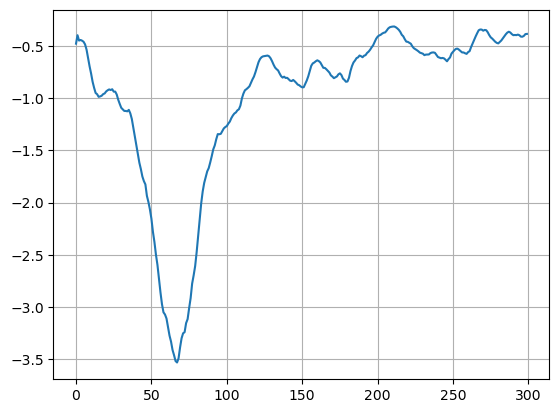

In [8]:
plt.plot(logs)
plt.grid()
plt.show()

In [8]:
agent.load('checkpoint_1')

In [9]:
env = gym.make('MountainCarContinuous-v0')
agent.play(env, trajectory_len)
env.close()

In [8]:
env = gym.make('MountainCarContinuous-v0')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

epochs = 300
trajectory_len = 900
trajectory_n = 150
q_param = 0.7

agent = CEM(state_dim, action_dim)

In [7]:
logs = agent.train(env, epochs, trajectory_len, trajectory_n, q_param)

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

epoch = 0, 
 total reward = -0.22669356491074472


C:\Users\Egor\AppData\Local\Temp\ipykernel_2788\2875173141.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  elite_states = torch.FloatTensor(elite_states)
  0%|▎                                                                               | 1/300 [00:35<2:55:30, 35.22s/it]

epoch = 1, 
 total reward = -0.22645659801219603


  1%|▌                                                                               | 2/300 [01:12<3:01:44, 36.59s/it]

epoch = 2, 
 total reward = -0.22522224101839314


  1%|▊                                                                               | 3/300 [01:48<2:58:47, 36.12s/it]

epoch = 3, 
 total reward = -0.22543645069140866


  1%|█                                                                               | 4/300 [02:26<3:02:44, 37.04s/it]

epoch = 4, 
 total reward = -0.22466623790516224


  2%|█▎                                                                              | 5/300 [03:05<3:05:44, 37.78s/it]

epoch = 5, 
 total reward = -0.22595272754414025


  2%|█▌                                                                              | 6/300 [03:45<3:07:26, 38.25s/it]

epoch = 6, 
 total reward = -0.22448818499128237


  2%|█▊                                                                              | 7/300 [04:19<3:00:47, 37.02s/it]

epoch = 7, 
 total reward = -0.22462950916020877


  3%|██▏                                                                             | 8/300 [04:50<2:51:12, 35.18s/it]

epoch = 8, 
 total reward = -0.22498140180638723


  3%|██▍                                                                             | 9/300 [05:23<2:47:22, 34.51s/it]

epoch = 9, 
 total reward = -0.2259681530678741


  3%|██▋                                                                            | 10/300 [05:58<2:46:23, 34.43s/it]

epoch = 10, 
 total reward = -0.22580271282977643


  4%|██▉                                                                            | 11/300 [06:31<2:45:05, 34.28s/it]

epoch = 11, 
 total reward = -0.22511157626148967


  4%|███▏                                                                           | 12/300 [07:04<2:42:28, 33.85s/it]

epoch = 12, 
 total reward = -0.22545406277429464


  4%|███▍                                                                           | 13/300 [07:37<2:39:35, 33.36s/it]

epoch = 13, 
 total reward = -0.22538045543906265


  5%|███▋                                                                           | 14/300 [08:10<2:39:31, 33.47s/it]

epoch = 14, 
 total reward = -0.22702941667625093


  5%|███▉                                                                           | 15/300 [08:47<2:43:15, 34.37s/it]

epoch = 15, 
 total reward = -0.22540841009069074


  5%|████▏                                                                          | 16/300 [09:22<2:43:36, 34.57s/it]

epoch = 16, 
 total reward = -0.22626339451597186


  6%|████▍                                                                          | 17/300 [09:59<2:46:06, 35.22s/it]

epoch = 17, 
 total reward = -0.22637134000394288


  6%|████▋                                                                          | 18/300 [10:34<2:46:00, 35.32s/it]

epoch = 18, 
 total reward = -0.2261625547622444


  6%|█████                                                                          | 19/300 [11:07<2:42:13, 34.64s/it]

epoch = 19, 
 total reward = -0.225439685500635


  7%|█████▎                                                                         | 20/300 [11:41<2:40:26, 34.38s/it]

epoch = 20, 
 total reward = -0.2272033331795141


  7%|█████▌                                                                         | 21/300 [12:15<2:39:11, 34.23s/it]

epoch = 21, 
 total reward = -0.2278961013412704


  7%|█████▊                                                                         | 22/300 [12:48<2:37:09, 33.92s/it]

epoch = 22, 
 total reward = -0.22678263292589254


  8%|██████                                                                         | 23/300 [13:22<2:36:46, 33.96s/it]

epoch = 23, 
 total reward = -0.22682218696343712


  8%|██████▎                                                                        | 24/300 [13:58<2:39:37, 34.70s/it]

epoch = 24, 
 total reward = -0.22725986752559219


  8%|██████▌                                                                        | 25/300 [14:32<2:37:56, 34.46s/it]

epoch = 25, 
 total reward = -0.22735495100269298


  9%|██████▊                                                                        | 26/300 [15:06<2:36:18, 34.23s/it]

epoch = 26, 
 total reward = -0.2275027781256557


  9%|███████                                                                        | 27/300 [15:40<2:35:51, 34.25s/it]

epoch = 27, 
 total reward = -0.227489428138955


  9%|███████▎                                                                       | 28/300 [16:15<2:35:37, 34.33s/it]

epoch = 28, 
 total reward = -0.22764888974268474


 10%|███████▋                                                                       | 29/300 [16:49<2:34:49, 34.28s/it]

epoch = 29, 
 total reward = -0.22769810232842624


 10%|███████▉                                                                       | 30/300 [17:22<2:32:59, 34.00s/it]

epoch = 30, 
 total reward = -0.22756151159465016


 10%|████████▏                                                                      | 31/300 [17:56<2:31:27, 33.78s/it]

epoch = 31, 
 total reward = -0.2292953997647813


 11%|████████▍                                                                      | 32/300 [18:29<2:30:47, 33.76s/it]

epoch = 32, 
 total reward = -0.22916941819710848


 11%|████████▋                                                                      | 33/300 [19:03<2:29:52, 33.68s/it]

epoch = 33, 
 total reward = -0.22805671624741772


 11%|████████▉                                                                      | 34/300 [19:37<2:30:01, 33.84s/it]

epoch = 34, 
 total reward = -0.22950983297307526


 12%|█████████▏                                                                     | 35/300 [20:15<2:34:59, 35.09s/it]

epoch = 35, 
 total reward = -0.23040342731115146


 12%|█████████▍                                                                     | 36/300 [20:49<2:32:45, 34.72s/it]

epoch = 36, 
 total reward = -0.23033573960205933


 12%|█████████▋                                                                     | 37/300 [21:25<2:33:48, 35.09s/it]

epoch = 37, 
 total reward = -0.2319364784257042


 13%|██████████                                                                     | 38/300 [21:58<2:31:17, 34.65s/it]

epoch = 38, 
 total reward = -0.23133350686948725


 13%|██████████▎                                                                    | 39/300 [22:31<2:28:20, 34.10s/it]

epoch = 39, 
 total reward = -0.23077215658727945


 13%|██████████▌                                                                    | 40/300 [23:03<2:24:28, 33.34s/it]

epoch = 40, 
 total reward = -0.2314955000314214


 14%|██████████▊                                                                    | 41/300 [23:36<2:23:09, 33.16s/it]

epoch = 41, 
 total reward = -0.23041104670374987


 14%|███████████                                                                    | 42/300 [24:08<2:21:34, 32.92s/it]

epoch = 42, 
 total reward = -0.23149028566942073


 14%|███████████▎                                                                   | 43/300 [24:40<2:19:30, 32.57s/it]

epoch = 43, 
 total reward = -0.23060258320069035


 15%|███████████▌                                                                   | 44/300 [25:12<2:18:52, 32.55s/it]

epoch = 44, 
 total reward = -0.2322162867132109


 15%|███████████▊                                                                   | 45/300 [25:48<2:22:45, 33.59s/it]

epoch = 45, 
 total reward = -0.2328508645951026


 15%|████████████                                                                   | 46/300 [26:22<2:22:42, 33.71s/it]

epoch = 46, 
 total reward = -0.2340728827103153


 16%|████████████▍                                                                  | 47/300 [26:56<2:21:43, 33.61s/it]

epoch = 47, 
 total reward = -0.23347149101128545


 16%|████████████▋                                                                  | 48/300 [27:29<2:20:17, 33.40s/it]

epoch = 48, 
 total reward = -0.2338013111784836


 16%|████████████▉                                                                  | 49/300 [28:02<2:19:42, 33.40s/it]

epoch = 49, 
 total reward = -0.2331974306338674


 17%|█████████████▏                                                                 | 50/300 [28:37<2:21:45, 34.02s/it]

epoch = 50, 
 total reward = -0.23289139278299822


 17%|█████████████▍                                                                 | 51/300 [29:15<2:25:29, 35.06s/it]

epoch = 51, 
 total reward = -0.23184932966457567


 17%|█████████████▋                                                                 | 52/300 [29:50<2:25:19, 35.16s/it]

epoch = 52, 
 total reward = -0.23218313278617397


 18%|█████████████▉                                                                 | 53/300 [30:24<2:23:32, 34.87s/it]

epoch = 53, 
 total reward = -0.23203518625055777


 18%|██████████████▏                                                                | 54/300 [30:58<2:21:04, 34.41s/it]

epoch = 54, 
 total reward = -0.23130558022860925


 18%|██████████████▍                                                                | 55/300 [31:31<2:19:33, 34.18s/it]

epoch = 55, 
 total reward = -0.23214681184661184


 19%|██████████████▋                                                                | 56/300 [32:05<2:18:37, 34.09s/it]

epoch = 56, 
 total reward = -0.23253048998165904


 19%|███████████████                                                                | 57/300 [32:38<2:16:16, 33.65s/it]

epoch = 57, 
 total reward = -0.23223299435889633


 19%|███████████████▎                                                               | 58/300 [33:12<2:16:01, 33.73s/it]

epoch = 58, 
 total reward = -0.232550951079938


 20%|███████████████▌                                                               | 59/300 [33:45<2:14:39, 33.53s/it]

epoch = 59, 
 total reward = -0.23223648152556076


 20%|███████████████▊                                                               | 60/300 [34:18<2:14:09, 33.54s/it]

epoch = 60, 
 total reward = -0.2331235566993298


 20%|████████████████                                                               | 61/300 [34:51<2:11:57, 33.13s/it]

epoch = 61, 
 total reward = -0.23378488184586993


 21%|████████████████▎                                                              | 62/300 [35:23<2:10:33, 32.91s/it]

epoch = 62, 
 total reward = -0.23313681081781945


 21%|████████████████▌                                                              | 63/300 [35:59<2:13:30, 33.80s/it]

epoch = 63, 
 total reward = -0.2348807794639911


 21%|████████████████▊                                                              | 64/300 [36:35<2:15:10, 34.37s/it]

epoch = 64, 
 total reward = -0.23466796690504993


 22%|█████████████████                                                              | 65/300 [37:13<2:19:05, 35.51s/it]

epoch = 65, 
 total reward = -0.2351293480142911


 22%|█████████████████▍                                                             | 66/300 [37:49<2:19:14, 35.70s/it]

epoch = 66, 
 total reward = -0.23543902909619543


 22%|█████████████████▋                                                             | 67/300 [38:24<2:17:50, 35.49s/it]

epoch = 67, 
 total reward = -0.2358060260216712


 23%|█████████████████▉                                                             | 68/300 [38:59<2:16:14, 35.23s/it]

epoch = 68, 
 total reward = -0.2372503261578098


 23%|██████████████████▏                                                            | 69/300 [39:32<2:13:00, 34.55s/it]

epoch = 69, 
 total reward = -0.2361686751598012


 23%|██████████████████▍                                                            | 70/300 [40:06<2:12:13, 34.50s/it]

epoch = 70, 
 total reward = -0.23775680767918284


 24%|██████████████████▋                                                            | 71/300 [40:38<2:09:09, 33.84s/it]

epoch = 71, 
 total reward = -0.2370278649654184


 24%|██████████████████▉                                                            | 72/300 [41:15<2:11:26, 34.59s/it]

epoch = 72, 
 total reward = -0.23775093786195658


 24%|███████████████████▏                                                           | 73/300 [41:48<2:09:41, 34.28s/it]

epoch = 73, 
 total reward = -0.23811929157220002


 25%|███████████████████▍                                                           | 74/300 [42:21<2:07:36, 33.88s/it]

epoch = 74, 
 total reward = -0.23823480348544032


 25%|███████████████████▊                                                           | 75/300 [42:54<2:05:35, 33.49s/it]

epoch = 75, 
 total reward = -0.23840143956665955


 25%|████████████████████                                                           | 76/300 [43:28<2:06:13, 33.81s/it]

epoch = 76, 
 total reward = -0.23861956257214417


 26%|████████████████████▌                                                          | 78/300 [44:37<2:06:45, 34.26s/it]

epoch = 77, 
 total reward = -0.23860447030340504
epoch = 78, 
 total reward = -0.23758211195380805


 26%|████████████████████▊                                                          | 79/300 [45:08<2:02:36, 33.29s/it]

epoch = 79, 
 total reward = -0.2369621528236108


 27%|█████████████████████                                                          | 80/300 [45:45<2:05:44, 34.29s/it]

epoch = 80, 
 total reward = -0.23741109533349147


 27%|█████████████████████▎                                                         | 81/300 [46:21<2:07:39, 34.97s/it]

epoch = 81, 
 total reward = -0.23709807532984162


 27%|█████████████████████▌                                                         | 82/300 [46:59<2:10:02, 35.79s/it]

epoch = 82, 
 total reward = -0.2370122041606675


 28%|█████████████████████▊                                                         | 83/300 [47:37<2:11:32, 36.37s/it]

epoch = 83, 
 total reward = -0.23727283881243963


 28%|██████████████████████                                                         | 84/300 [48:12<2:10:03, 36.13s/it]

epoch = 84, 
 total reward = -0.23548506325190321


 28%|██████████████████████▍                                                        | 85/300 [48:46<2:06:37, 35.34s/it]

epoch = 85, 
 total reward = -0.23473292453612904


 29%|██████████████████████▋                                                        | 86/300 [49:18<2:02:34, 34.37s/it]

epoch = 86, 
 total reward = -0.2345120706053685


 29%|██████████████████████▉                                                        | 87/300 [49:50<1:59:30, 33.67s/it]

epoch = 87, 
 total reward = -0.2348828292339247


 29%|███████████████████████▏                                                       | 88/300 [50:23<1:58:03, 33.41s/it]

epoch = 88, 
 total reward = -0.234694315582333


 30%|███████████████████████▍                                                       | 89/300 [50:56<1:57:38, 33.45s/it]

epoch = 89, 
 total reward = -0.23383233356340669


 30%|███████████████████████▋                                                       | 90/300 [51:29<1:56:13, 33.21s/it]

epoch = 90, 
 total reward = -0.23348235602931008


 30%|███████████████████████▉                                                       | 91/300 [52:03<1:56:56, 33.57s/it]

epoch = 91, 
 total reward = -0.232606266131826


 31%|████████████████████████▏                                                      | 92/300 [52:40<1:59:14, 34.40s/it]

epoch = 92, 
 total reward = -0.2334161416904127


 31%|████████████████████████▍                                                      | 93/300 [53:18<2:02:35, 35.53s/it]

epoch = 93, 
 total reward = -0.23254200655477586


 31%|████████████████████████▊                                                      | 94/300 [53:56<2:04:53, 36.37s/it]

epoch = 94, 
 total reward = -0.2315263410178712


 32%|█████████████████████████                                                      | 95/300 [54:35<2:06:13, 36.95s/it]

epoch = 95, 
 total reward = -0.2320809334495135


 32%|█████████████████████████▎                                                     | 96/300 [55:08<2:02:06, 35.91s/it]

epoch = 96, 
 total reward = -0.23148079169573996


 32%|█████████████████████████▌                                                     | 97/300 [55:44<2:01:05, 35.79s/it]

epoch = 97, 
 total reward = -0.23245734962626338


 33%|█████████████████████████▊                                                     | 98/300 [56:17<1:57:43, 34.97s/it]

epoch = 98, 
 total reward = -0.2327629991078723


 33%|██████████████████████████                                                     | 99/300 [56:51<1:56:20, 34.73s/it]

epoch = 99, 
 total reward = -0.23246217327936042


 33%|██████████████████████████                                                    | 100/300 [57:24<1:54:12, 34.26s/it]

epoch = 100, 
 total reward = -0.2333323447220036


 34%|██████████████████████████▌                                                   | 102/300 [58:30<1:49:13, 33.10s/it]

epoch = 101, 
 total reward = -0.23271248853064425
epoch = 102, 
 total reward = -0.23385976129037692


 34%|██████████████████████████▊                                                   | 103/300 [59:03<1:49:05, 33.23s/it]

epoch = 103, 
 total reward = -0.2346685495757789


 35%|███████████████████████████                                                   | 104/300 [59:37<1:49:25, 33.50s/it]

epoch = 104, 
 total reward = -0.2342107510671111


 35%|██████████████████████████▌                                                 | 105/300 [1:00:11<1:49:19, 33.64s/it]

epoch = 105, 
 total reward = -0.23346587832475488


 35%|██████████████████████████▊                                                 | 106/300 [1:00:44<1:47:33, 33.27s/it]

epoch = 106, 
 total reward = -0.2325585215565216


 36%|███████████████████████████                                                 | 107/300 [1:01:16<1:46:16, 33.04s/it]

epoch = 107, 
 total reward = -0.23278542538996608


 36%|███████████████████████████▎                                                | 108/300 [1:01:49<1:45:31, 32.98s/it]

epoch = 108, 
 total reward = -0.23086337954561012


 36%|███████████████████████████▌                                                | 109/300 [1:02:22<1:45:19, 33.09s/it]

epoch = 109, 
 total reward = -0.232402228167358


 37%|███████████████████████████▊                                                | 110/300 [1:02:56<1:44:54, 33.13s/it]

epoch = 110, 
 total reward = -0.2316304342548237


 37%|████████████████████████████                                                | 111/300 [1:03:33<1:48:36, 34.48s/it]

epoch = 111, 
 total reward = -0.23306238605417695


 37%|████████████████████████████▎                                               | 112/300 [1:04:08<1:48:18, 34.57s/it]

epoch = 112, 
 total reward = -0.23154402646209069


 38%|████████████████████████████▋                                               | 113/300 [1:04:42<1:47:25, 34.47s/it]

epoch = 113, 
 total reward = -0.23166688529167753


 38%|████████████████████████████▉                                               | 114/300 [1:05:18<1:47:49, 34.78s/it]

epoch = 114, 
 total reward = -0.232122675006111


 38%|█████████████████████████████▏                                              | 115/300 [1:05:50<1:45:20, 34.16s/it]

epoch = 115, 
 total reward = -0.23313212417328597


 39%|█████████████████████████████▍                                              | 116/300 [1:06:27<1:46:57, 34.88s/it]

epoch = 116, 
 total reward = -0.23243103169665724


 39%|█████████████████████████████▋                                              | 117/300 [1:07:05<1:48:58, 35.73s/it]

epoch = 117, 
 total reward = -0.2333050968979676


 39%|█████████████████████████████▉                                              | 118/300 [1:07:41<1:48:26, 35.75s/it]

epoch = 118, 
 total reward = -0.23317412218061548


 40%|██████████████████████████████▏                                             | 119/300 [1:08:16<1:47:43, 35.71s/it]

epoch = 119, 
 total reward = -0.23306482393519218


 40%|██████████████████████████████▍                                             | 120/300 [1:08:49<1:44:48, 34.93s/it]

epoch = 120, 
 total reward = -0.23273396325395954


 40%|██████████████████████████████▋                                             | 121/300 [1:09:22<1:42:41, 34.42s/it]

epoch = 121, 
 total reward = -0.23377339402965647


 41%|██████████████████████████████▉                                             | 122/300 [1:09:55<1:40:39, 33.93s/it]

epoch = 122, 
 total reward = -0.2320193104264474


 41%|███████████████████████████████▏                                            | 123/300 [1:10:32<1:42:30, 34.75s/it]

epoch = 123, 
 total reward = -0.23140491269639482


 41%|███████████████████████████████▍                                            | 124/300 [1:11:08<1:43:27, 35.27s/it]

epoch = 124, 
 total reward = -0.23209338114210487


 42%|███████████████████████████████▋                                            | 125/300 [1:11:41<1:40:40, 34.52s/it]

epoch = 125, 
 total reward = -0.23216222671347073


 42%|███████████████████████████████▉                                            | 126/300 [1:12:13<1:38:05, 33.82s/it]

epoch = 126, 
 total reward = -0.2324402572008271


 42%|████████████████████████████████▏                                           | 127/300 [1:12:47<1:37:23, 33.78s/it]

epoch = 127, 
 total reward = -0.2328979996814478


 43%|████████████████████████████████▍                                           | 128/300 [1:13:20<1:35:57, 33.48s/it]

epoch = 128, 
 total reward = -0.2325784912039028


 43%|████████████████████████████████▋                                           | 129/300 [1:13:54<1:36:06, 33.72s/it]

epoch = 129, 
 total reward = -0.2320817128032174


 43%|████████████████████████████████▉                                           | 130/300 [1:14:26<1:33:47, 33.10s/it]

epoch = 130, 
 total reward = -0.23092088407757766


 44%|█████████████████████████████████▏                                          | 131/300 [1:14:57<1:32:00, 32.67s/it]

epoch = 131, 
 total reward = -0.22950950318784644


 44%|█████████████████████████████████▍                                          | 132/300 [1:15:31<1:32:24, 33.00s/it]

epoch = 132, 
 total reward = -0.23040508489431127


 44%|█████████████████████████████████▋                                          | 133/300 [1:16:05<1:32:54, 33.38s/it]

epoch = 133, 
 total reward = -0.22967804958311538


 45%|█████████████████████████████████▉                                          | 134/300 [1:16:42<1:35:22, 34.47s/it]

epoch = 134, 
 total reward = -0.23007319679580435


 45%|██████████████████████████████████▏                                         | 135/300 [1:17:16<1:34:16, 34.28s/it]

epoch = 135, 
 total reward = -0.22989435069371117


 45%|██████████████████████████████████▍                                         | 136/300 [1:17:48<1:31:12, 33.37s/it]

epoch = 136, 
 total reward = -0.2287105466120832


 46%|██████████████████████████████████▋                                         | 137/300 [1:18:19<1:29:19, 32.88s/it]

epoch = 137, 
 total reward = -0.22841685939413148


 46%|██████████████████████████████████▉                                         | 138/300 [1:18:51<1:27:50, 32.53s/it]

epoch = 138, 
 total reward = -0.22829549055903095


 46%|███████████████████████████████████▏                                        | 139/300 [1:19:25<1:28:28, 32.97s/it]

epoch = 139, 
 total reward = -0.22778860537558615


 47%|███████████████████████████████████▍                                        | 140/300 [1:19:57<1:26:52, 32.58s/it]

epoch = 140, 
 total reward = -0.22883405436256973


 47%|███████████████████████████████████▋                                        | 141/300 [1:20:30<1:26:38, 32.69s/it]

epoch = 141, 
 total reward = -0.22887833048108538


 47%|███████████████████████████████████▉                                        | 142/300 [1:21:07<1:29:39, 34.05s/it]

epoch = 142, 
 total reward = -0.22936415890743309


 48%|████████████████████████████████████▏                                       | 143/300 [1:21:43<1:30:33, 34.61s/it]

epoch = 143, 
 total reward = -0.22990153205639557


 48%|████████████████████████████████████▍                                       | 144/300 [1:22:18<1:30:20, 34.75s/it]

epoch = 144, 
 total reward = -0.2288142137116513


 48%|████████████████████████████████████▋                                       | 145/300 [1:22:54<1:30:45, 35.13s/it]

epoch = 145, 
 total reward = -0.23010338159139423


 49%|████████████████████████████████████▉                                       | 146/300 [1:23:27<1:28:27, 34.46s/it]

epoch = 146, 
 total reward = -0.2289488652831103


 49%|█████████████████████████████████████▍                                      | 148/300 [1:24:31<1:24:08, 33.21s/it]

epoch = 147, 
 total reward = -0.22949077001983645
epoch = 148, 
 total reward = -0.228631893489918


 50%|█████████████████████████████████████▋                                      | 149/300 [1:24:57<1:18:21, 31.14s/it]

epoch = 149, 
 total reward = -0.22835805737464493


 50%|██████████████████████████████████████                                      | 150/300 [1:25:28<1:17:34, 31.03s/it]

epoch = 150, 
 total reward = -0.2301500466137791


 50%|██████████████████████████████████████▎                                     | 151/300 [1:26:02<1:19:15, 31.92s/it]

epoch = 151, 
 total reward = -0.2308097375539201


 51%|██████████████████████████████████████▌                                     | 152/300 [1:26:35<1:19:35, 32.27s/it]

epoch = 152, 
 total reward = -0.23029610720230603


 51%|██████████████████████████████████████▊                                     | 153/300 [1:27:08<1:19:47, 32.57s/it]

epoch = 153, 
 total reward = -0.22993400440631329


 51%|███████████████████████████████████████                                     | 154/300 [1:27:42<1:20:13, 32.97s/it]

epoch = 154, 
 total reward = -0.23185940544096814


 52%|███████████████████████████████████████▎                                    | 155/300 [1:28:18<1:21:49, 33.86s/it]

epoch = 155, 
 total reward = -0.23125149033114642


 52%|███████████████████████████████████████▌                                    | 156/300 [1:28:52<1:21:01, 33.76s/it]

epoch = 156, 
 total reward = -0.23240667970749154


 52%|███████████████████████████████████████▊                                    | 157/300 [1:29:24<1:19:24, 33.32s/it]

epoch = 157, 
 total reward = -0.2311245884541675


 53%|████████████████████████████████████████                                    | 158/300 [1:29:58<1:19:23, 33.55s/it]

epoch = 158, 
 total reward = -0.2325035773655285


 53%|████████████████████████████████████████▎                                   | 159/300 [1:30:31<1:18:45, 33.51s/it]

epoch = 159, 
 total reward = -0.23202277586530073


 53%|████████████████████████████████████████▌                                   | 160/300 [1:31:05<1:18:08, 33.49s/it]

epoch = 160, 
 total reward = -0.232862521499868


 54%|████████████████████████████████████████▊                                   | 161/300 [1:31:38<1:17:18, 33.37s/it]

epoch = 161, 
 total reward = -0.23326942960160504


 54%|█████████████████████████████████████████                                   | 162/300 [1:32:12<1:17:26, 33.67s/it]

epoch = 162, 
 total reward = -0.23247577931449753


 54%|█████████████████████████████████████████▎                                  | 163/300 [1:32:47<1:17:47, 34.07s/it]

epoch = 163, 
 total reward = -0.23330981554550664


 55%|█████████████████████████████████████████▌                                  | 164/300 [1:33:22<1:18:00, 34.41s/it]

epoch = 164, 
 total reward = -0.23352356060261978


 55%|█████████████████████████████████████████▊                                  | 165/300 [1:33:55<1:16:31, 34.01s/it]

epoch = 165, 
 total reward = -0.23319886404287407


 55%|██████████████████████████████████████████                                  | 166/300 [1:34:28<1:14:42, 33.45s/it]

epoch = 166, 
 total reward = -0.23382769579430326


 56%|██████████████████████████████████████████▎                                 | 167/300 [1:35:01<1:13:55, 33.35s/it]

epoch = 167, 
 total reward = -0.23228639117668337


 56%|██████████████████████████████████████████▌                                 | 168/300 [1:35:35<1:13:48, 33.55s/it]

epoch = 168, 
 total reward = -0.23308832659001505


 56%|██████████████████████████████████████████▊                                 | 169/300 [1:36:11<1:14:53, 34.30s/it]

epoch = 169, 
 total reward = -0.23322571270977874


 57%|███████████████████████████████████████████                                 | 170/300 [1:36:46<1:14:59, 34.61s/it]

epoch = 170, 
 total reward = -0.23275514182259685


 57%|███████████████████████████████████████████▎                                | 171/300 [1:37:21<1:14:18, 34.56s/it]

epoch = 171, 
 total reward = -0.2325902627206604


 57%|███████████████████████████████████████████▌                                | 172/300 [1:37:55<1:13:53, 34.64s/it]

epoch = 172, 
 total reward = -0.23249883653569597


 58%|███████████████████████████████████████████▊                                | 173/300 [1:38:29<1:12:20, 34.18s/it]

epoch = 173, 
 total reward = -0.2322731632354011


 58%|████████████████████████████████████████████                                | 174/300 [1:39:03<1:11:43, 34.16s/it]


KeyboardInterrupt: 

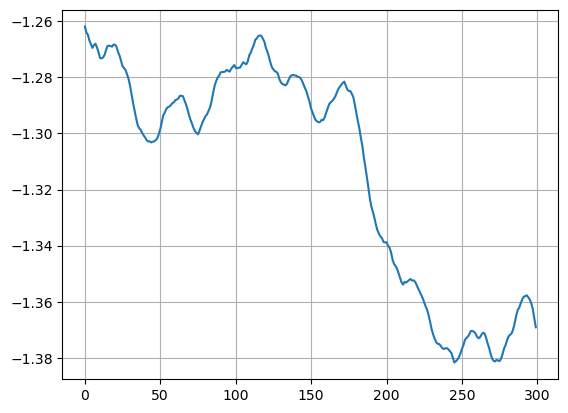

In [11]:
plt.plot(logs)
plt.grid()
plt.show()

In [9]:
env = gym.make('MountainCarContinuous-v0')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

epochs = 300
trajectory_len = 700
trajectory_n = 100
q_param = 0.8

agent = CEM(state_dim, action_dim)

In [10]:
logs = agent.train(env, epochs, trajectory_len, trajectory_n, q_param)

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

epoch = 0, 
 total reward = -1.2618649797960295


C:\Users\Egor\AppData\Local\Temp\ipykernel_14680\1520571983.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  elite_states = torch.FloatTensor(elite_states)
  1%|▌                                                                               | 2/300 [00:35<1:26:11, 17.36s/it]

epoch = 1, 
 total reward = -1.2640389192292987


  1%|▊                                                                               | 3/300 [00:52<1:25:41, 17.31s/it]

epoch = 2, 
 total reward = -1.264825599311936


  1%|█                                                                               | 4/300 [01:10<1:26:24, 17.51s/it]

epoch = 3, 
 total reward = -1.2668901860990913


  2%|█▎                                                                              | 5/300 [01:28<1:26:34, 17.61s/it]

epoch = 4, 
 total reward = -1.2682432283127232


  2%|█▌                                                                              | 6/300 [01:46<1:26:57, 17.75s/it]

epoch = 5, 
 total reward = -1.2694967983312204


  2%|█▊                                                                              | 7/300 [02:02<1:23:52, 17.17s/it]

epoch = 6, 
 total reward = -1.26853179781098


  3%|██▏                                                                             | 8/300 [02:18<1:23:01, 17.06s/it]

epoch = 7, 
 total reward = -1.2680058172448476


  3%|██▍                                                                             | 9/300 [02:35<1:21:28, 16.80s/it]

epoch = 8, 
 total reward = -1.269314201660896
epoch = 9, 
 total reward = -1.27095854684165


  4%|██▉                                                                            | 11/300 [03:08<1:21:15, 16.87s/it]

epoch = 10, 
 total reward = -1.2730607049162552


  4%|███▏                                                                           | 12/300 [03:26<1:21:28, 16.97s/it]

epoch = 11, 
 total reward = -1.2732581145571167


  4%|███▍                                                                           | 13/300 [03:43<1:21:52, 17.12s/it]

epoch = 12, 
 total reward = -1.2729200315522602


  5%|███▋                                                                           | 14/300 [04:01<1:22:11, 17.24s/it]

epoch = 13, 
 total reward = -1.2720843099634


  5%|███▉                                                                           | 15/300 [04:17<1:21:16, 17.11s/it]

epoch = 14, 
 total reward = -1.2703329404052381


  5%|████▏                                                                          | 16/300 [04:37<1:24:01, 17.75s/it]

epoch = 15, 
 total reward = -1.2688111218576057


  6%|████▍                                                                          | 17/300 [04:55<1:24:42, 17.96s/it]

epoch = 16, 
 total reward = -1.2686964616372085


  6%|████▋                                                                          | 18/300 [05:15<1:27:10, 18.55s/it]

epoch = 17, 
 total reward = -1.2688326637907161


  6%|█████                                                                          | 19/300 [05:35<1:28:13, 18.84s/it]

epoch = 18, 
 total reward = -1.2690419044928019


  7%|█████▎                                                                         | 20/300 [05:54<1:29:21, 19.15s/it]

epoch = 19, 
 total reward = -1.2683396055816527


  7%|█████▌                                                                         | 21/300 [06:13<1:28:49, 19.10s/it]

epoch = 20, 
 total reward = -1.2683766706925779


  7%|█████▊                                                                         | 22/300 [06:31<1:26:28, 18.66s/it]

epoch = 21, 
 total reward = -1.269153501727607


  8%|██████                                                                         | 23/300 [06:49<1:25:28, 18.51s/it]

epoch = 22, 
 total reward = -1.2709673652780817


  8%|██████▎                                                                        | 24/300 [07:08<1:25:02, 18.49s/it]

epoch = 23, 
 total reward = -1.2722413899275824


  8%|██████▌                                                                        | 25/300 [07:26<1:24:34, 18.45s/it]

epoch = 24, 
 total reward = -1.274102584957766


  9%|██████▊                                                                        | 26/300 [07:46<1:25:41, 18.77s/it]

epoch = 25, 
 total reward = -1.2760814232108784


  9%|███████                                                                        | 27/300 [08:06<1:28:01, 19.35s/it]

epoch = 26, 
 total reward = -1.2766865738924806


  9%|███████▎                                                                       | 28/300 [08:28<1:31:04, 20.09s/it]

epoch = 27, 
 total reward = -1.277460105104042


 10%|███████▋                                                                       | 29/300 [08:49<1:31:25, 20.24s/it]

epoch = 28, 
 total reward = -1.2789730466454343


 10%|███████▉                                                                       | 30/300 [09:08<1:30:26, 20.10s/it]

epoch = 29, 
 total reward = -1.280665093734723


 10%|████████▏                                                                      | 31/300 [09:28<1:29:48, 20.03s/it]

epoch = 30, 
 total reward = -1.2830944888877422


 11%|████████▍                                                                      | 32/300 [09:51<1:32:42, 20.76s/it]

epoch = 31, 
 total reward = -1.286187297707472


 11%|████████▋                                                                      | 33/300 [10:10<1:30:31, 20.34s/it]

epoch = 32, 
 total reward = -1.2892797553854376


 11%|████████▉                                                                      | 34/300 [10:28<1:26:29, 19.51s/it]

epoch = 33, 
 total reward = -1.2919801859187658


 12%|█████████▏                                                                     | 35/300 [10:48<1:26:45, 19.64s/it]

epoch = 34, 
 total reward = -1.294642965824488


 12%|█████████▍                                                                     | 36/300 [11:10<1:29:40, 20.38s/it]

epoch = 35, 
 total reward = -1.2970308792104976


 12%|█████████▋                                                                     | 37/300 [11:30<1:29:00, 20.30s/it]

epoch = 36, 
 total reward = -1.2981224538150895


 13%|██████████                                                                     | 38/300 [11:53<1:32:09, 21.10s/it]

epoch = 37, 
 total reward = -1.2987037312746117


 13%|██████████▎                                                                    | 39/300 [12:25<1:46:30, 24.49s/it]

epoch = 38, 
 total reward = -1.2998213056478678


 13%|██████████▌                                                                    | 40/300 [12:44<1:39:09, 22.88s/it]

epoch = 39, 
 total reward = -1.3007539884323216


 14%|██████████▊                                                                    | 41/300 [13:04<1:34:33, 21.91s/it]

epoch = 40, 
 total reward = -1.3014387979502267


 14%|███████████                                                                    | 42/300 [13:23<1:30:04, 20.95s/it]

epoch = 41, 
 total reward = -1.302460290896241


 14%|███████████▎                                                                   | 43/300 [13:39<1:23:44, 19.55s/it]

epoch = 42, 
 total reward = -1.3028706300313035


 15%|███████████▌                                                                   | 44/300 [13:57<1:21:22, 19.07s/it]

epoch = 43, 
 total reward = -1.3027939697570232


 15%|███████████▊                                                                   | 45/300 [14:17<1:22:34, 19.43s/it]

epoch = 44, 
 total reward = -1.3031831984752413


 15%|████████████                                                                   | 46/300 [14:34<1:19:30, 18.78s/it]

epoch = 45, 
 total reward = -1.302952415176779


 16%|████████████▍                                                                  | 47/300 [14:48<1:12:22, 17.17s/it]

epoch = 46, 
 total reward = -1.3028076959625714


 16%|████████████▋                                                                  | 48/300 [15:08<1:15:33, 17.99s/it]

epoch = 47, 
 total reward = -1.3023554667560324


 16%|████████████▉                                                                  | 49/300 [15:26<1:15:02, 17.94s/it]

epoch = 48, 
 total reward = -1.3017038804628789


 17%|█████████████▏                                                                 | 50/300 [15:44<1:15:27, 18.11s/it]

epoch = 49, 
 total reward = -1.3002545295057657


 17%|█████████████▍                                                                 | 51/300 [16:06<1:19:59, 19.27s/it]

epoch = 50, 
 total reward = -1.2984425490752358


 17%|█████████████▋                                                                 | 52/300 [16:28<1:23:01, 20.09s/it]

epoch = 51, 
 total reward = -1.2960287511541566


 18%|█████████████▉                                                                 | 53/300 [16:47<1:21:13, 19.73s/it]

epoch = 52, 
 total reward = -1.2934726646619736


 18%|██████████████▏                                                                | 54/300 [17:06<1:19:44, 19.45s/it]

epoch = 53, 
 total reward = -1.2925342229481742


 18%|██████████████▍                                                                | 55/300 [17:23<1:16:39, 18.77s/it]

epoch = 54, 
 total reward = -1.2912440022232488


 19%|██████████████▋                                                                | 56/300 [17:39<1:12:47, 17.90s/it]

epoch = 55, 
 total reward = -1.2906435026041505


 19%|███████████████                                                                | 57/300 [17:56<1:11:53, 17.75s/it]

epoch = 56, 
 total reward = -1.290437915869614


 19%|███████████████▎                                                               | 58/300 [18:08<1:04:50, 16.08s/it]

epoch = 57, 
 total reward = -1.2898941359256932


 20%|███████████████▌                                                               | 59/300 [18:26<1:06:33, 16.57s/it]

epoch = 58, 
 total reward = -1.289198734931512


 20%|███████████████▊                                                               | 60/300 [18:46<1:09:39, 17.41s/it]

epoch = 59, 
 total reward = -1.2888845984006352


 20%|████████████████                                                               | 61/300 [19:04<1:10:22, 17.67s/it]

epoch = 60, 
 total reward = -1.2881208155471557


 21%|████████████████▎                                                              | 62/300 [19:22<1:10:34, 17.79s/it]

epoch = 61, 
 total reward = -1.287906270831884


 21%|████████████████▌                                                              | 63/300 [19:43<1:13:52, 18.70s/it]

epoch = 62, 
 total reward = -1.2874888928180277


 21%|████████████████▊                                                              | 64/300 [19:57<1:08:26, 17.40s/it]

epoch = 63, 
 total reward = -1.2865711642342095


 22%|█████████████████                                                              | 65/300 [20:20<1:14:44, 19.08s/it]

epoch = 64, 
 total reward = -1.2865911699432773


 22%|█████████████████▍                                                             | 66/300 [20:41<1:17:03, 19.76s/it]

epoch = 65, 
 total reward = -1.2867166372750376


 22%|█████████████████▋                                                             | 67/300 [21:01<1:16:00, 19.57s/it]

epoch = 66, 
 total reward = -1.2881856704787058


 23%|█████████████████▉                                                             | 68/300 [21:17<1:11:40, 18.54s/it]

epoch = 67, 
 total reward = -1.289585613701546


 23%|██████████████████▏                                                            | 69/300 [21:33<1:08:30, 17.79s/it]

epoch = 68, 
 total reward = -1.2912805762335822


 23%|██████████████████▍                                                            | 70/300 [21:52<1:09:21, 18.09s/it]

epoch = 69, 
 total reward = -1.293366101330135


 24%|██████████████████▋                                                            | 71/300 [22:11<1:11:07, 18.64s/it]

epoch = 70, 
 total reward = -1.2951069412816818


 24%|██████████████████▉                                                            | 72/300 [22:29<1:09:38, 18.33s/it]

epoch = 71, 
 total reward = -1.2964770964038654


 24%|███████████████████▏                                                           | 73/300 [22:47<1:09:12, 18.29s/it]

epoch = 72, 
 total reward = -1.2980132714538999


 25%|███████████████████▍                                                           | 74/300 [23:03<1:05:41, 17.44s/it]

epoch = 73, 
 total reward = -1.299172194574309


 25%|███████████████████▊                                                           | 75/300 [23:21<1:06:50, 17.82s/it]

epoch = 74, 
 total reward = -1.2997919408827616


 25%|████████████████████                                                           | 76/300 [23:35<1:01:47, 16.55s/it]

epoch = 75, 
 total reward = -1.3003086880973111


 26%|████████████████████▎                                                          | 77/300 [23:56<1:06:29, 17.89s/it]

epoch = 76, 
 total reward = -1.2990429465324727


 26%|████████████████████▌                                                          | 78/300 [24:18<1:10:56, 19.18s/it]

epoch = 77, 
 total reward = -1.2975265839665844


 26%|████████████████████▊                                                          | 79/300 [24:39<1:12:51, 19.78s/it]

epoch = 78, 
 total reward = -1.2959753349467056


 27%|█████████████████████                                                          | 80/300 [24:53<1:05:19, 17.82s/it]

epoch = 79, 
 total reward = -1.2949081360333436


 27%|█████████████████████▎                                                         | 81/300 [25:12<1:06:52, 18.32s/it]

epoch = 80, 
 total reward = -1.2938327772859721


 27%|█████████████████████▌                                                         | 82/300 [25:30<1:05:56, 18.15s/it]

epoch = 81, 
 total reward = -1.293187355883878


 28%|█████████████████████▊                                                         | 83/300 [25:47<1:04:22, 17.80s/it]

epoch = 82, 
 total reward = -1.2918947807428045


 28%|██████████████████████                                                         | 84/300 [26:03<1:02:22, 17.33s/it]

epoch = 83, 
 total reward = -1.2907064528661303


 28%|██████████████████████▍                                                        | 85/300 [26:19<1:00:38, 16.92s/it]

epoch = 84, 
 total reward = -1.2884885399792676


 29%|███████████████████████▏                                                         | 86/300 [26:31<54:55, 15.40s/it]

epoch = 85, 
 total reward = -1.2856378954730103


 29%|███████████████████████▍                                                         | 87/300 [26:47<55:54, 15.75s/it]

epoch = 86, 
 total reward = -1.2830773125193442


 29%|███████████████████████▊                                                         | 88/300 [27:04<56:20, 15.95s/it]

epoch = 87, 
 total reward = -1.281392306870257


 30%|████████████████████████                                                         | 89/300 [27:23<59:14, 16.84s/it]

epoch = 88, 
 total reward = -1.2801225801993734


 30%|███████████████████████▋                                                       | 90/300 [27:41<1:00:19, 17.24s/it]

epoch = 89, 
 total reward = -1.2794248070883822


 30%|████████████████████████▌                                                        | 91/300 [27:53<54:34, 15.67s/it]

epoch = 90, 
 total reward = -1.2782087726115956


 31%|████████████████████████▏                                                      | 92/300 [28:16<1:01:29, 17.74s/it]

epoch = 91, 
 total reward = -1.278133380555107


 31%|████████████████████████▍                                                      | 93/300 [28:38<1:06:23, 19.24s/it]

epoch = 92, 
 total reward = -1.27809286475509


 31%|████████████████████████▊                                                      | 94/300 [28:55<1:03:45, 18.57s/it]

epoch = 93, 
 total reward = -1.277963728757106


 32%|█████████████████████████                                                      | 95/300 [29:12<1:01:33, 18.02s/it]

epoch = 94, 
 total reward = -1.2773261260265603


 32%|█████████████████████████▎                                                     | 96/300 [29:30<1:00:51, 17.90s/it]

epoch = 95, 
 total reward = -1.277643438649305


 32%|██████████████████████████▏                                                      | 97/300 [29:42<55:16, 16.34s/it]

epoch = 96, 
 total reward = -1.277959196591675


 33%|██████████████████████████▍                                                      | 98/300 [29:58<54:44, 16.26s/it]

epoch = 97, 
 total reward = -1.2769530308581942


 33%|██████████████████████████▋                                                      | 99/300 [30:13<53:13, 15.89s/it]

epoch = 98, 
 total reward = -1.2763006463026998


 33%|██████████████████████████▋                                                     | 100/300 [30:29<52:57, 15.89s/it]

epoch = 99, 
 total reward = -1.27560620375343


 34%|██████████████████████████▉                                                     | 101/300 [30:46<53:08, 16.02s/it]

epoch = 100, 
 total reward = -1.2766102574870073


 34%|███████████████████████████▏                                                    | 102/300 [31:02<53:38, 16.25s/it]

epoch = 101, 
 total reward = -1.276746088931822


 34%|███████████████████████████▍                                                    | 103/300 [31:19<53:48, 16.39s/it]

epoch = 102, 
 total reward = -1.276538649215373


 35%|███████████████████████████▋                                                    | 104/300 [31:37<54:47, 16.77s/it]

epoch = 103, 
 total reward = -1.276484378539055


 35%|████████████████████████████                                                    | 105/300 [31:52<52:52, 16.27s/it]

epoch = 104, 
 total reward = -1.2754863688936884


 35%|████████████████████████████▎                                                   | 106/300 [32:14<58:41, 18.15s/it]

epoch = 105, 
 total reward = -1.2746143735429523


 36%|████████████████████████████▌                                                   | 107/300 [32:28<53:52, 16.75s/it]

epoch = 106, 
 total reward = -1.2750112089829342


 36%|████████████████████████████▊                                                   | 108/300 [32:48<57:09, 17.86s/it]

epoch = 107, 
 total reward = -1.2753460198722182


 36%|█████████████████████████████                                                   | 109/300 [33:07<57:29, 18.06s/it]

epoch = 108, 
 total reward = -1.2743510819387405


 37%|█████████████████████████████▎                                                  | 110/300 [33:25<57:16, 18.09s/it]

epoch = 109, 
 total reward = -1.2721157011228534


 37%|█████████████████████████████▌                                                  | 111/300 [33:42<56:06, 17.81s/it]

epoch = 110, 
 total reward = -1.2711609809002307


 37%|█████████████████████████████▊                                                  | 112/300 [33:59<54:55, 17.53s/it]

epoch = 111, 
 total reward = -1.2696895406337756


 38%|██████████████████████████████▏                                                 | 113/300 [34:11<49:34, 15.90s/it]

epoch = 112, 
 total reward = -1.268468363273486


 38%|██████████████████████████████▍                                                 | 114/300 [34:26<48:31, 15.65s/it]

epoch = 113, 
 total reward = -1.2666074209803668


 38%|██████████████████████████████▋                                                 | 115/300 [34:43<49:17, 15.99s/it]

epoch = 114, 
 total reward = -1.2660927437529643


 39%|██████████████████████████████▉                                                 | 116/300 [35:01<50:53, 16.60s/it]

epoch = 115, 
 total reward = -1.2652705798827895


 39%|███████████████████████████████▏                                                | 117/300 [35:19<51:48, 16.99s/it]

epoch = 116, 
 total reward = -1.2650546926918853


 39%|███████████████████████████████▍                                                | 118/300 [35:35<50:34, 16.68s/it]

epoch = 117, 
 total reward = -1.2651887137486835


 40%|███████████████████████████████▋                                                | 119/300 [35:56<54:24, 18.04s/it]

epoch = 118, 
 total reward = -1.2662369117896177


 40%|████████████████████████████████                                                | 120/300 [36:18<57:42, 19.23s/it]

epoch = 119, 
 total reward = -1.2672545200589413


 40%|████████████████████████████████▎                                               | 121/300 [36:37<57:13, 19.18s/it]

epoch = 120, 
 total reward = -1.2694486230998052


 41%|████████████████████████████████▌                                               | 122/300 [36:54<55:08, 18.59s/it]

epoch = 121, 
 total reward = -1.2708358646867588


 41%|████████████████████████████████▊                                               | 123/300 [37:12<53:56, 18.28s/it]

epoch = 122, 
 total reward = -1.2725879756753795


 41%|█████████████████████████████████                                               | 124/300 [37:24<48:05, 16.40s/it]

epoch = 123, 
 total reward = -1.2746912010906504


 42%|█████████████████████████████████▎                                              | 125/300 [37:41<48:03, 16.48s/it]

epoch = 124, 
 total reward = -1.2763801887012105


 42%|█████████████████████████████████▌                                              | 126/300 [37:58<48:55, 16.87s/it]

epoch = 125, 
 total reward = -1.2772012299514883


 42%|█████████████████████████████████▊                                              | 127/300 [38:14<47:41, 16.54s/it]

epoch = 126, 
 total reward = -1.2778586687582756


 43%|██████████████████████████████████▏                                             | 128/300 [38:29<46:16, 16.14s/it]

epoch = 127, 
 total reward = -1.278018541977923


 43%|██████████████████████████████████▍                                             | 129/300 [38:46<46:12, 16.21s/it]

epoch = 128, 
 total reward = -1.2787348558110536


 43%|██████████████████████████████████▋                                             | 130/300 [39:03<46:59, 16.59s/it]

epoch = 129, 
 total reward = -1.2806609402707538


 44%|██████████████████████████████████▉                                             | 131/300 [39:21<47:39, 16.92s/it]

epoch = 130, 
 total reward = -1.2818184508799313


 44%|███████████████████████████████████▏                                            | 132/300 [39:38<47:18, 16.90s/it]

epoch = 131, 
 total reward = -1.2823864161722813


 44%|███████████████████████████████████▍                                            | 133/300 [39:59<50:50, 18.27s/it]

epoch = 132, 
 total reward = -1.2825742634666313


 45%|███████████████████████████████████▋                                            | 134/300 [40:20<52:16, 18.89s/it]

epoch = 133, 
 total reward = -1.282868896092571


 45%|████████████████████████████████████                                            | 135/300 [40:40<53:20, 19.39s/it]

epoch = 134, 
 total reward = -1.282304602261251


 45%|████████████████████████████████████▎                                           | 136/300 [40:57<50:55, 18.63s/it]

epoch = 135, 
 total reward = -1.2809941545676489


 46%|████████████████████████████████████▌                                           | 137/300 [41:11<46:39, 17.18s/it]

epoch = 136, 
 total reward = -1.2798311359301633


 46%|████████████████████████████████████▊                                           | 138/300 [41:28<46:07, 17.08s/it]

epoch = 137, 
 total reward = -1.2792785728363603


 46%|█████████████████████████████████████                                           | 139/300 [41:46<46:30, 17.33s/it]

epoch = 138, 
 total reward = -1.279158271875484


 47%|█████████████████████████████████████▎                                          | 140/300 [42:02<45:47, 17.17s/it]

epoch = 139, 
 total reward = -1.279313854665515


 47%|█████████████████████████████████████▌                                          | 141/300 [42:19<45:21, 17.12s/it]

epoch = 140, 
 total reward = -1.2793538124050334


 47%|█████████████████████████████████████▊                                          | 142/300 [42:37<45:29, 17.28s/it]

epoch = 141, 
 total reward = -1.2797640700783297


 48%|██████████████████████████████████████▏                                         | 143/300 [42:53<44:29, 17.00s/it]

epoch = 142, 
 total reward = -1.2799055904758492


 48%|██████████████████████████████████████▍                                         | 144/300 [43:06<41:05, 15.80s/it]

epoch = 143, 
 total reward = -1.2803111862861138


 48%|██████████████████████████████████████▋                                         | 145/300 [43:23<41:31, 16.07s/it]

epoch = 144, 
 total reward = -1.2812590455508728


 49%|██████████████████████████████████████▉                                         | 146/300 [43:41<42:51, 16.70s/it]

epoch = 145, 
 total reward = -1.2825226999688615


 49%|███████████████████████████████████████▏                                        | 147/300 [44:00<44:16, 17.36s/it]

epoch = 146, 
 total reward = -1.2838740874556587


 49%|███████████████████████████████████████▍                                        | 148/300 [44:13<40:38, 16.04s/it]

epoch = 147, 
 total reward = -1.2852087401346848


 50%|███████████████████████████████████████▋                                        | 149/300 [44:32<42:47, 17.00s/it]

epoch = 148, 
 total reward = -1.2869912409338593


 50%|████████████████████████████████████████                                        | 150/300 [44:50<43:04, 17.23s/it]

epoch = 149, 
 total reward = -1.288782577061031


 50%|████████████████████████████████████████▎                                       | 151/300 [45:07<42:36, 17.16s/it]

epoch = 150, 
 total reward = -1.2911676498846765


 51%|████████████████████████████████████████▌                                       | 152/300 [45:23<41:31, 16.84s/it]

epoch = 151, 
 total reward = -1.2926308176127561


 51%|████████████████████████████████████████▊                                       | 153/300 [45:40<41:07, 16.78s/it]

epoch = 152, 
 total reward = -1.2939867975459949


 51%|█████████████████████████████████████████                                       | 154/300 [45:58<41:50, 17.20s/it]

epoch = 153, 
 total reward = -1.2952326857070053


 52%|█████████████████████████████████████████▎                                      | 155/300 [46:16<41:56, 17.36s/it]

epoch = 154, 
 total reward = -1.2956942721205704


 52%|█████████████████████████████████████████▌                                      | 156/300 [46:33<41:53, 17.45s/it]

epoch = 155, 
 total reward = -1.2960180538002957


 52%|█████████████████████████████████████████▊                                      | 157/300 [46:48<39:23, 16.53s/it]

epoch = 156, 
 total reward = -1.2958924081227639


 53%|██████████████████████████████████████████▏                                     | 158/300 [47:06<40:09, 16.97s/it]

epoch = 157, 
 total reward = -1.2951103605395937


 53%|██████████████████████████████████████████▍                                     | 159/300 [47:23<39:43, 16.91s/it]

epoch = 158, 
 total reward = -1.295294355399806


 53%|██████████████████████████████████████████▋                                     | 160/300 [47:40<39:45, 17.04s/it]

epoch = 159, 
 total reward = -1.2942370845326383


 54%|██████████████████████████████████████████▉                                     | 161/300 [47:59<40:50, 17.63s/it]

epoch = 160, 
 total reward = -1.292573624324091


 54%|███████████████████████████████████████████▏                                    | 162/300 [48:21<43:17, 18.82s/it]

epoch = 161, 
 total reward = -1.2910059633652


 54%|███████████████████████████████████████████▍                                    | 163/300 [48:41<43:46, 19.17s/it]

epoch = 162, 
 total reward = -1.2895373323768065


 55%|███████████████████████████████████████████▋                                    | 164/300 [48:58<42:36, 18.80s/it]

epoch = 163, 
 total reward = -1.2888869139018158


 55%|████████████████████████████████████████████                                    | 165/300 [49:17<42:02, 18.68s/it]

epoch = 164, 
 total reward = -1.288428016513122


 55%|████████████████████████████████████████████▎                                   | 166/300 [49:35<41:12, 18.45s/it]

epoch = 165, 
 total reward = -1.2877113952464176


 56%|████████████████████████████████████████████▌                                   | 167/300 [49:53<40:47, 18.40s/it]

epoch = 166, 
 total reward = -1.2868674692667827


 56%|████████████████████████████████████████████▊                                   | 168/300 [50:07<37:49, 17.20s/it]

epoch = 167, 
 total reward = -1.285520052946428


 56%|█████████████████████████████████████████████                                   | 169/300 [50:25<37:57, 17.38s/it]

epoch = 168, 
 total reward = -1.2841582025078697


 57%|█████████████████████████████████████████████▎                                  | 170/300 [50:44<38:29, 17.77s/it]

epoch = 169, 
 total reward = -1.283378751669398


 57%|█████████████████████████████████████████████▌                                  | 171/300 [51:02<38:04, 17.71s/it]

epoch = 170, 
 total reward = -1.282647744752806


 57%|█████████████████████████████████████████████▊                                  | 172/300 [51:19<37:22, 17.52s/it]

epoch = 171, 
 total reward = -1.281979382790111


 58%|██████████████████████████████████████████████▏                                 | 173/300 [51:36<37:00, 17.48s/it]

epoch = 172, 
 total reward = -1.2815491421423661


 58%|██████████████████████████████████████████████▍                                 | 174/300 [51:57<38:45, 18.46s/it]

epoch = 173, 
 total reward = -1.2829802782116508


 58%|██████████████████████████████████████████████▋                                 | 175/300 [52:17<39:49, 19.12s/it]

epoch = 174, 
 total reward = -1.2843018045210628


 59%|██████████████████████████████████████████████▉                                 | 176/300 [52:38<40:32, 19.62s/it]

epoch = 175, 
 total reward = -1.284861798477661


 59%|███████████████████████████████████████████████▏                                | 177/300 [52:56<38:57, 19.01s/it]

epoch = 176, 
 total reward = -1.2848934701944978


 59%|███████████████████████████████████████████████▍                                | 178/300 [53:09<35:04, 17.25s/it]

epoch = 177, 
 total reward = -1.2858609889177273


 60%|███████████████████████████████████████████████▋                                | 179/300 [53:26<34:46, 17.25s/it]

epoch = 178, 
 total reward = -1.2870649480172545


 60%|████████████████████████████████████████████████                                | 180/300 [53:43<34:15, 17.13s/it]

epoch = 179, 
 total reward = -1.289757717242139


 60%|████████████████████████████████████████████████▎                               | 181/300 [53:59<33:32, 16.91s/it]

epoch = 180, 
 total reward = -1.2927727636793405


 61%|████████████████████████████████████████████████▌                               | 182/300 [54:18<34:03, 17.32s/it]

epoch = 181, 
 total reward = -1.2956070827031518


 61%|████████████████████████████████████████████████▊                               | 183/300 [54:35<34:04, 17.47s/it]

epoch = 182, 
 total reward = -1.298168110313943


 61%|█████████████████████████████████████████████████                               | 184/300 [54:53<33:42, 17.44s/it]

epoch = 183, 
 total reward = -1.3015783379824615


 62%|█████████████████████████████████████████████████▎                              | 185/300 [55:09<32:53, 17.16s/it]

epoch = 184, 
 total reward = -1.304503943908102


 62%|█████████████████████████████████████████████████▌                              | 186/300 [55:25<32:00, 16.85s/it]

epoch = 185, 
 total reward = -1.3085714957527501


 62%|█████████████████████████████████████████████████▊                              | 187/300 [55:40<30:23, 16.14s/it]

epoch = 186, 
 total reward = -1.311951391609595


 63%|██████████████████████████████████████████████████▏                             | 188/300 [55:59<31:51, 17.07s/it]

epoch = 187, 
 total reward = -1.3156235973628128


 63%|██████████████████████████████████████████████████▍                             | 189/300 [56:18<32:34, 17.61s/it]

epoch = 188, 
 total reward = -1.3193639562929556


 63%|██████████████████████████████████████████████████▋                             | 190/300 [56:39<34:22, 18.75s/it]

epoch = 189, 
 total reward = -1.3233122056355942


 64%|██████████████████████████████████████████████████▉                             | 191/300 [56:56<32:56, 18.13s/it]

epoch = 190, 
 total reward = -1.3261063833475026


 64%|███████████████████████████████████████████████████▏                            | 192/300 [57:13<31:49, 17.68s/it]

epoch = 191, 
 total reward = -1.328013461045937


 64%|███████████████████████████████████████████████████▍                            | 193/300 [57:29<30:42, 17.22s/it]

epoch = 192, 
 total reward = -1.3301191542329147


 65%|███████████████████████████████████████████████████▋                            | 194/300 [57:46<30:27, 17.24s/it]

epoch = 193, 
 total reward = -1.3325554799566515


 65%|████████████████████████████████████████████████████                            | 195/300 [58:01<29:03, 16.60s/it]

epoch = 194, 
 total reward = -1.334518528367884


 65%|████████████████████████████████████████████████████▎                           | 196/300 [58:18<28:59, 16.73s/it]

epoch = 195, 
 total reward = -1.335766990246362


 66%|████████████████████████████████████████████████████▌                           | 197/300 [58:36<28:58, 16.88s/it]

epoch = 196, 
 total reward = -1.3367567391643427


 66%|████████████████████████████████████████████████████▊                           | 198/300 [58:53<28:54, 17.01s/it]

epoch = 197, 
 total reward = -1.337327272940305


 66%|█████████████████████████████████████████████████████                           | 199/300 [59:12<29:31, 17.54s/it]

epoch = 198, 
 total reward = -1.3386393270943455


 67%|█████████████████████████████████████████████████████▎                          | 200/300 [59:28<28:41, 17.22s/it]

epoch = 199, 
 total reward = -1.338851665141345


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [59:46<28:41, 17.39s/it]

epoch = 200, 
 total reward = -1.3387890660704673


 67%|████████████████████████████████████████████████████▌                         | 202/300 [1:00:05<29:27, 18.04s/it]

epoch = 201, 
 total reward = -1.339983604551999


 68%|████████████████████████████████████████████████████▊                         | 203/300 [1:00:24<29:18, 18.13s/it]

epoch = 202, 
 total reward = -1.3406852355143086


 68%|█████████████████████████████████████████████████████                         | 204/300 [1:00:44<30:07, 18.82s/it]

epoch = 203, 
 total reward = -1.3423718017195017


 68%|█████████████████████████████████████████████████████▎                        | 205/300 [1:01:01<28:57, 18.29s/it]

epoch = 204, 
 total reward = -1.3449475680626595


 69%|█████████████████████████████████████████████████████▌                        | 206/300 [1:01:19<28:20, 18.09s/it]

epoch = 205, 
 total reward = -1.346521312213059


 69%|█████████████████████████████████████████████████████▊                        | 207/300 [1:01:32<25:38, 16.54s/it]

epoch = 206, 
 total reward = -1.3472508332074205


 69%|██████████████████████████████████████████████████████                        | 208/300 [1:01:48<25:24, 16.57s/it]

epoch = 207, 
 total reward = -1.3481806433833239


 70%|██████████████████████████████████████████████████████▎                       | 209/300 [1:02:04<24:50, 16.37s/it]

epoch = 208, 
 total reward = -1.349798456661604


 70%|██████████████████████████████████████████████████████▌                       | 210/300 [1:02:21<24:40, 16.44s/it]

epoch = 209, 
 total reward = -1.351391275327774


 70%|██████████████████████████████████████████████████████▊                       | 211/300 [1:02:38<24:39, 16.63s/it]

epoch = 210, 
 total reward = -1.3531112541173724


 71%|███████████████████████████████████████████████████████                       | 212/300 [1:02:56<24:59, 17.03s/it]

epoch = 211, 
 total reward = -1.3538793680061196


 71%|███████████████████████████████████████████████████████▍                      | 213/300 [1:03:10<23:15, 16.04s/it]

epoch = 212, 
 total reward = -1.3528970198693948


 71%|███████████████████████████████████████████████████████▋                      | 214/300 [1:03:26<22:55, 15.99s/it]

epoch = 213, 
 total reward = -1.3531483695656996


 72%|███████████████████████████████████████████████████████▉                      | 215/300 [1:03:43<23:09, 16.35s/it]

epoch = 214, 
 total reward = -1.3527072791923158


 72%|████████████████████████████████████████████████████████▏                     | 216/300 [1:04:05<25:10, 17.98s/it]

epoch = 215, 
 total reward = -1.3522353039277113


 72%|████████████████████████████████████████████████████████▍                     | 217/300 [1:04:24<25:14, 18.25s/it]

epoch = 216, 
 total reward = -1.3518885462735595


 73%|████████████████████████████████████████████████████████▋                     | 218/300 [1:04:44<25:39, 18.77s/it]

epoch = 217, 
 total reward = -1.3524474052863327


 73%|████████████████████████████████████████████████████████▉                     | 219/300 [1:05:00<24:33, 18.19s/it]

epoch = 218, 
 total reward = -1.352363168233358


 73%|█████████████████████████████████████████████████████████▏                    | 220/300 [1:05:17<23:45, 17.82s/it]

epoch = 219, 
 total reward = -1.35287160248666


 74%|█████████████████████████████████████████████████████████▍                    | 221/300 [1:05:34<23:11, 17.61s/it]

epoch = 220, 
 total reward = -1.3540296812413235


 74%|█████████████████████████████████████████████████████████▋                    | 222/300 [1:05:51<22:35, 17.37s/it]

epoch = 221, 
 total reward = -1.3552972489846362


 74%|█████████████████████████████████████████████████████████▉                    | 223/300 [1:06:09<22:15, 17.34s/it]

epoch = 222, 
 total reward = -1.3564061684225548


 75%|██████████████████████████████████████████████████████████▏                   | 224/300 [1:06:26<21:59, 17.36s/it]

epoch = 223, 
 total reward = -1.3575392312522305


 75%|██████████████████████████████████████████████████████████▌                   | 225/300 [1:06:43<21:34, 17.27s/it]

epoch = 224, 
 total reward = -1.358720260218644


 75%|██████████████████████████████████████████████████████████▊                   | 226/300 [1:07:00<21:17, 17.26s/it]

epoch = 225, 
 total reward = -1.3601880609435963


 76%|███████████████████████████████████████████████████████████                   | 227/300 [1:07:16<20:25, 16.79s/it]

epoch = 226, 
 total reward = -1.361727894796916


 76%|███████████████████████████████████████████████████████████▎                  | 228/300 [1:07:32<19:53, 16.58s/it]

epoch = 227, 
 total reward = -1.3629357451248858


 76%|███████████████████████████████████████████████████████████▌                  | 229/300 [1:07:50<20:08, 17.01s/it]

epoch = 228, 
 total reward = -1.364911803704997


 77%|███████████████████████████████████████████████████████████▊                  | 230/300 [1:08:11<21:10, 18.16s/it]

epoch = 229, 
 total reward = -1.3673618155206768


 77%|████████████████████████████████████████████████████████████                  | 231/300 [1:08:31<21:29, 18.69s/it]

epoch = 230, 
 total reward = -1.369924666795396


 77%|████████████████████████████████████████████████████████████▎                 | 232/300 [1:08:49<20:59, 18.52s/it]

epoch = 231, 
 total reward = -1.371736129399613


 78%|████████████████████████████████████████████████████████████▌                 | 233/300 [1:09:03<19:05, 17.09s/it]

epoch = 232, 
 total reward = -1.3732761361980577


 78%|████████████████████████████████████████████████████████████▊                 | 234/300 [1:09:20<18:54, 17.19s/it]

epoch = 233, 
 total reward = -1.374462703166899


 78%|█████████████████████████████████████████████████████████████                 | 235/300 [1:09:37<18:41, 17.25s/it]

epoch = 234, 
 total reward = -1.3749491472617401


 79%|█████████████████████████████████████████████████████████████▎                | 236/300 [1:09:54<18:13, 17.09s/it]

epoch = 235, 
 total reward = -1.3750953328952575


 79%|█████████████████████████████████████████████████████████████▌                | 237/300 [1:10:11<17:57, 17.10s/it]

epoch = 236, 
 total reward = -1.3757429191544894


 79%|█████████████████████████████████████████████████████████████▉                | 238/300 [1:10:28<17:33, 16.99s/it]

epoch = 237, 
 total reward = -1.3765471483200522


 80%|██████████████████████████████████████████████████████████████▏               | 239/300 [1:10:44<17:06, 16.82s/it]

epoch = 238, 
 total reward = -1.3768274634542137


 80%|██████████████████████████████████████████████████████████████▍               | 240/300 [1:11:03<17:15, 17.25s/it]

epoch = 239, 
 total reward = -1.3765606058174789


 80%|██████████████████████████████████████████████████████████████▋               | 241/300 [1:11:19<16:44, 17.02s/it]

epoch = 240, 
 total reward = -1.3765067925682177


 81%|██████████████████████████████████████████████████████████████▉               | 242/300 [1:11:35<16:09, 16.72s/it]

epoch = 241, 
 total reward = -1.3769332606021856


 81%|███████████████████████████████████████████████████████████████▏              | 243/300 [1:11:54<16:21, 17.22s/it]

epoch = 242, 
 total reward = -1.377571160476466


 81%|███████████████████████████████████████████████████████████████▍              | 244/300 [1:12:12<16:30, 17.69s/it]

epoch = 243, 
 total reward = -1.3782544621036135


 82%|███████████████████████████████████████████████████████████████▋              | 245/300 [1:12:34<17:21, 18.94s/it]

epoch = 244, 
 total reward = -1.3799388114232327


 82%|███████████████████████████████████████████████████████████████▉              | 246/300 [1:12:52<16:38, 18.49s/it]

epoch = 245, 
 total reward = -1.381634015635003


 82%|████████████████████████████████████████████████████████████████▏             | 247/300 [1:13:08<15:47, 17.88s/it]

epoch = 246, 
 total reward = -1.3812030387646133


 83%|████████████████████████████████████████████████████████████████▍             | 248/300 [1:13:26<15:25, 17.80s/it]

epoch = 247, 
 total reward = -1.3806125730103755


 83%|████████████████████████████████████████████████████████████████▋             | 249/300 [1:13:43<14:52, 17.50s/it]

epoch = 248, 
 total reward = -1.3797913614232946


 83%|█████████████████████████████████████████████████████████████████             | 250/300 [1:13:59<14:18, 17.17s/it]

epoch = 249, 
 total reward = -1.3784551812585457


 84%|█████████████████████████████████████████████████████████████████▎            | 251/300 [1:14:16<14:03, 17.22s/it]

epoch = 250, 
 total reward = -1.376876975482858


 84%|█████████████████████████████████████████████████████████████████▌            | 252/300 [1:14:33<13:45, 17.21s/it]

epoch = 251, 
 total reward = -1.375474018394388


 84%|█████████████████████████████████████████████████████████████████▊            | 253/300 [1:14:50<13:14, 16.91s/it]

epoch = 252, 
 total reward = -1.3736007488931457


 85%|██████████████████████████████████████████████████████████████████            | 254/300 [1:15:06<12:51, 16.77s/it]

epoch = 253, 
 total reward = -1.3729081172022612


 85%|██████████████████████████████████████████████████████████████████▎           | 255/300 [1:15:23<12:42, 16.94s/it]

epoch = 254, 
 total reward = -1.3723946756232486


 85%|██████████████████████████████████████████████████████████████████▌           | 256/300 [1:15:41<12:29, 17.02s/it]

epoch = 255, 
 total reward = -1.371474316666897


 86%|██████████████████████████████████████████████████████████████████▊           | 257/300 [1:16:01<12:52, 17.97s/it]

epoch = 256, 
 total reward = -1.3703932288075797


 86%|███████████████████████████████████████████████████████████████████           | 258/300 [1:16:21<13:02, 18.63s/it]

epoch = 257, 
 total reward = -1.3704164630884534


 86%|███████████████████████████████████████████████████████████████████▎          | 259/300 [1:16:40<12:51, 18.82s/it]

epoch = 258, 
 total reward = -1.3706995528876291


 87%|███████████████████████████████████████████████████████████████████▌          | 260/300 [1:16:58<12:20, 18.50s/it]

epoch = 259, 
 total reward = -1.3713039883893152


 87%|███████████████████████████████████████████████████████████████████▊          | 261/300 [1:17:16<11:57, 18.39s/it]

epoch = 260, 
 total reward = -1.3723949380571243


 87%|████████████████████████████████████████████████████████████████████          | 262/300 [1:17:33<11:25, 18.03s/it]

epoch = 261, 
 total reward = -1.37301068207658


 88%|████████████████████████████████████████████████████████████████████▍         | 263/300 [1:17:50<10:57, 17.76s/it]

epoch = 262, 
 total reward = -1.3726258983238666


 88%|████████████████████████████████████████████████████████████████████▋         | 264/300 [1:18:04<09:56, 16.58s/it]

epoch = 263, 
 total reward = -1.3717231919698625


 88%|████████████████████████████████████████████████████████████████████▉         | 265/300 [1:18:22<09:51, 16.90s/it]

epoch = 264, 
 total reward = -1.371052447868562


 89%|█████████████████████████████████████████████████████████████████████▏        | 266/300 [1:18:38<09:23, 16.58s/it]

epoch = 265, 
 total reward = -1.3712913667505953


 89%|█████████████████████████████████████████████████████████████████████▍        | 267/300 [1:18:55<09:16, 16.85s/it]

epoch = 266, 
 total reward = -1.3727691178873913


 89%|█████████████████████████████████████████████████████████████████████▋        | 268/300 [1:19:13<09:05, 17.04s/it]

epoch = 267, 
 total reward = -1.374711691640761


 90%|█████████████████████████████████████████████████████████████████████▉        | 269/300 [1:19:30<08:49, 17.07s/it]

epoch = 268, 
 total reward = -1.3763761629912974


 90%|██████████████████████████████████████████████████████████████████████▏       | 270/300 [1:19:44<08:04, 16.14s/it]

epoch = 269, 
 total reward = -1.378465338919803


 90%|██████████████████████████████████████████████████████████████████████▍       | 271/300 [1:20:04<08:22, 17.34s/it]

epoch = 270, 
 total reward = -1.3801832392642779


 91%|██████████████████████████████████████████████████████████████████████▋       | 272/300 [1:20:18<07:34, 16.23s/it]

epoch = 271, 
 total reward = -1.3810270788108054


 91%|██████████████████████████████████████████████████████████████████████▉       | 273/300 [1:20:40<08:07, 18.07s/it]

epoch = 272, 
 total reward = -1.3812854366701321


 91%|███████████████████████████████████████████████████████████████████████▏      | 274/300 [1:20:58<07:47, 17.98s/it]

epoch = 273, 
 total reward = -1.3807030432033736


 92%|███████████████████████████████████████████████████████████████████████▌      | 275/300 [1:21:15<07:27, 17.89s/it]

epoch = 274, 
 total reward = -1.3809773659673048


 92%|███████████████████████████████████████████████████████████████████████▊      | 276/300 [1:21:32<06:58, 17.44s/it]

epoch = 275, 
 total reward = -1.3811067795387109


 92%|████████████████████████████████████████████████████████████████████████      | 277/300 [1:21:49<06:35, 17.21s/it]

epoch = 276, 
 total reward = -1.3802784741668734


 93%|████████████████████████████████████████████████████████████████████████▎     | 278/300 [1:22:06<06:20, 17.30s/it]

epoch = 277, 
 total reward = -1.378571096853721


 93%|████████████████████████████████████████████████████████████████████████▌     | 279/300 [1:22:25<06:11, 17.68s/it]

epoch = 278, 
 total reward = -1.3765977959154376


 93%|████████████████████████████████████████████████████████████████████████▊     | 280/300 [1:22:41<05:46, 17.32s/it]

epoch = 279, 
 total reward = -1.375403628417419


 94%|█████████████████████████████████████████████████████████████████████████     | 281/300 [1:23:01<05:43, 18.06s/it]

epoch = 280, 
 total reward = -1.3735540676873044


 94%|█████████████████████████████████████████████████████████████████████████▎    | 282/300 [1:23:18<05:17, 17.64s/it]

epoch = 281, 
 total reward = -1.3722926804671092


 94%|█████████████████████████████████████████████████████████████████████████▌    | 283/300 [1:23:34<04:54, 17.34s/it]

epoch = 282, 
 total reward = -1.3717792393011965


 95%|█████████████████████████████████████████████████████████████████████████▊    | 284/300 [1:23:53<04:45, 17.85s/it]

epoch = 283, 
 total reward = -1.3712410424430928


 95%|██████████████████████████████████████████████████████████████████████████    | 285/300 [1:24:16<04:51, 19.44s/it]

epoch = 284, 
 total reward = -1.3697767376628516


 95%|██████████████████████████████████████████████████████████████████████████▎   | 286/300 [1:24:38<04:41, 20.09s/it]

epoch = 285, 
 total reward = -1.3676178176016842


 96%|██████████████████████████████████████████████████████████████████████████▌   | 287/300 [1:24:55<04:08, 19.11s/it]

epoch = 286, 
 total reward = -1.3649949931461973


 96%|██████████████████████████████████████████████████████████████████████████▉   | 288/300 [1:25:12<03:41, 18.46s/it]

epoch = 287, 
 total reward = -1.362902114001826


 96%|███████████████████████████████████████████████████████████████████████████▏  | 289/300 [1:25:27<03:13, 17.56s/it]

epoch = 288, 
 total reward = -1.3621011715735394


 97%|███████████████████████████████████████████████████████████████████████████▍  | 290/300 [1:25:45<02:55, 17.50s/it]

epoch = 289, 
 total reward = -1.3605428120060987


 97%|███████████████████████████████████████████████████████████████████████████▋  | 291/300 [1:25:58<02:25, 16.19s/it]

epoch = 290, 
 total reward = -1.3591369166117722


 97%|███████████████████████████████████████████████████████████████████████████▉  | 292/300 [1:26:15<02:11, 16.49s/it]

epoch = 291, 
 total reward = -1.3582096770343428


 98%|████████████████████████████████████████████████████████████████████████████▏ | 293/300 [1:26:32<01:57, 16.74s/it]

epoch = 292, 
 total reward = -1.3579883709127087


 98%|████████████████████████████████████████████████████████████████████████████▍ | 294/300 [1:26:51<01:43, 17.27s/it]

epoch = 293, 
 total reward = -1.357680742764233


 98%|████████████████████████████████████████████████████████████████████████████▋ | 295/300 [1:27:06<01:22, 16.57s/it]

epoch = 294, 
 total reward = -1.3583754173727924


 99%|████████████████████████████████████████████████████████████████████████████▉ | 296/300 [1:27:23<01:06, 16.73s/it]

epoch = 295, 
 total reward = -1.3592156379134572


 99%|█████████████████████████████████████████████████████████████████████████████▏| 297/300 [1:27:38<00:49, 16.35s/it]

epoch = 296, 
 total reward = -1.3605526691297984


 99%|█████████████████████████████████████████████████████████████████████████████▍| 298/300 [1:28:00<00:36, 18.08s/it]

epoch = 297, 
 total reward = -1.3625988801493951


100%|█████████████████████████████████████████████████████████████████████████████▋| 299/300 [1:28:20<00:18, 18.69s/it]

epoch = 298, 
 total reward = -1.3658877985155327


100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [1:28:40<00:00, 17.74s/it]

epoch = 299, 
 total reward = -1.369085949034199


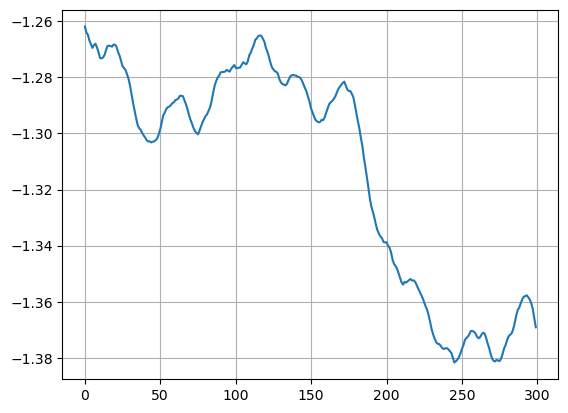

In [11]:
plt.plot(logs)
plt.grid()
plt.show()

In [12]:
env = gym.make('MountainCarContinuous-v0')
agent.play(env, trajectory_len)
env.close()

In [8]:
#lr=0.008
env = gym.make('MountainCarContinuous-v0')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

epochs = 230
trajectory_len = 500
trajectory_n = 150
q_param = 0.6

agent = CEM(state_dim, action_dim)

In [ ]:
logs = agent.train(env, epochs, trajectory_len, trajectory_n, q_param)

  0%|                                                                                          | 0/230 [00:00<?, ?it/s]C:\Users\Egor\AppData\Local\Temp\ipykernel_14052\2924688111.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  elite_states = torch.FloatTensor(elite_states)
  0%|▎                                                                               | 1/230 [00:19<1:13:07, 19.16s/it]

epoch = 0, total reward = -0.9338619079635248, loss = 1.0288067140434407e-18


  1%|▋                                                                                 | 2/230 [00:32<58:52, 15.49s/it]

epoch = 1, total reward = -0.9334185279914289, loss = 1.4654943845642728e-18


  1%|█                                                                                 | 3/230 [00:46<56:29, 14.93s/it]

epoch = 2, total reward = -0.9324545659037473, loss = 1.088018577036671e-18


  2%|█▍                                                                              | 4/230 [01:04<1:01:16, 16.27s/it]

epoch = 3, total reward = -0.9332836760232476, loss = 9.62193238929086e-19


  2%|█▋                                                                              | 5/230 [01:21<1:01:08, 16.30s/it]

epoch = 4, total reward = -0.9342021294427812, loss = 1.613524145444925e-18


  3%|██                                                                              | 6/230 [01:38<1:02:21, 16.70s/it]

epoch = 5, total reward = -0.9342520699419626, loss = 1.3026617096341013e-18


  3%|██▍                                                                             | 7/230 [01:54<1:01:18, 16.50s/it]

epoch = 6, total reward = -0.9342692199797318, loss = 1.088018577036671e-18


  3%|██▊                                                                             | 8/230 [02:13<1:03:29, 17.16s/it]

epoch = 7, total reward = -0.93628679008532, loss = 7.84557598250607e-19


  4%|███▏                                                                            | 9/230 [02:31<1:04:24, 17.49s/it]

epoch = 8, total reward = -0.9367249007272638, loss = 9.177843933829516e-19


  4%|███▍                                                                           | 10/230 [02:49<1:04:47, 17.67s/it]

epoch = 9, total reward = -0.9375501299240322, loss = 1.650531585665088e-18


  5%|███▊                                                                           | 11/230 [03:07<1:05:08, 17.85s/it]

epoch = 10, total reward = -0.9368302007231348, loss = 1.2064423030231314e-18


  5%|████                                                                           | 12/230 [03:26<1:05:33, 18.05s/it]

epoch = 11, total reward = -0.9372313812412388, loss = 1.0214052053198928e-18


  6%|████▍                                                                          | 13/230 [03:44<1:05:34, 18.13s/it]

epoch = 12, total reward = -0.9375736751452793, loss = 1.1546319487534491e-18


  6%|████▊                                                                          | 14/230 [04:00<1:02:52, 17.47s/it]

epoch = 13, total reward = -0.9371511563458601, loss = 8.881784618863365e-19


  7%|█████▎                                                                           | 15/230 [04:13<58:00, 16.19s/it]

epoch = 14, total reward = -0.937110297516681, loss = 1.2508512519668424e-18


  7%|█████▋                                                                           | 16/230 [04:28<56:44, 15.91s/it]

epoch = 15, total reward = -0.9366622628571031, loss = 1.1546319487534491e-18


  7%|█████▉                                                                           | 17/230 [04:45<57:26, 16.18s/it]

epoch = 16, total reward = -0.9368472144900802, loss = 9.103828846594037e-19


  8%|██████▎                                                                          | 18/230 [05:01<56:58, 16.13s/it]

epoch = 17, total reward = -0.937242198723117, loss = 7.84557598250607e-19


  8%|██████▋                                                                          | 19/230 [05:16<55:40, 15.83s/it]

epoch = 18, total reward = -0.9351786084868204, loss = 1.04360962809296e-18


  9%|███████                                                                          | 20/230 [05:30<53:31, 15.29s/it]

epoch = 19, total reward = -0.9352861042447231, loss = 9.103828846594037e-19


  9%|███████▍                                                                         | 21/230 [05:47<54:17, 15.59s/it]

epoch = 20, total reward = -0.9349436682041297, loss = 9.399888161560188e-19


 10%|███████▋                                                                         | 22/230 [06:00<51:42, 14.91s/it]

epoch = 21, total reward = -0.9337392388803583, loss = 9.769962563761818e-19


 10%|████████                                                                         | 23/230 [06:17<53:43, 15.57s/it]

epoch = 22, total reward = -0.9324867980330812, loss = 9.473903248795667e-19


 10%|████████▍                                                                        | 24/230 [06:33<53:20, 15.54s/it]

epoch = 23, total reward = -0.9330196410882159, loss = 7.993605639989145e-19


 11%|████████▊                                                                        | 25/230 [06:48<52:38, 15.41s/it]

epoch = 24, total reward = -0.9326708763527283, loss = 8.807769531627886e-19


 11%|█████████▏                                                                       | 26/230 [07:00<49:11, 14.47s/it]

epoch = 25, total reward = -0.9324417878703796, loss = 1.0658141542636038e-18


 12%|█████████▌                                                                       | 27/230 [07:16<50:26, 14.91s/it]

epoch = 26, total reward = -0.9312246357946755, loss = 7.401487010056843e-19


 12%|█████████▊                                                                       | 28/230 [07:32<50:52, 15.11s/it]

epoch = 27, total reward = -0.9325795332500442, loss = 1.3174646236836206e-18


 13%|██████████▏                                                                      | 29/230 [07:49<53:08, 15.86s/it]

epoch = 28, total reward = -0.9321507033570258, loss = 9.473903248795667e-19


 13%|██████████▌                                                                      | 30/230 [08:05<53:17, 15.99s/it]

epoch = 29, total reward = -0.9319849258693792, loss = 8.807769531627886e-19


 13%|██████████▉                                                                      | 31/230 [08:21<52:30, 15.83s/it]

epoch = 30, total reward = -0.9313715401586432, loss = 8.511709699673851e-19


 14%|███████████▎                                                                     | 32/230 [08:35<50:53, 15.42s/it]

epoch = 31, total reward = -0.9321968965734694, loss = 1.598721127997829e-18


 14%|███████████▌                                                                     | 33/230 [08:50<49:54, 15.20s/it]

epoch = 32, total reward = -0.931658886601038, loss = 7.327471922821364e-19


 15%|███████████▉                                                                     | 34/230 [09:05<49:20, 15.10s/it]

epoch = 33, total reward = -0.9319901182801467, loss = 8.2156503847077e-19


 15%|████████████▎                                                                    | 35/230 [09:19<48:27, 14.91s/it]

epoch = 34, total reward = -0.9327618263730467, loss = 7.697546325022994e-19


 16%|████████████▋                                                                    | 36/230 [09:34<48:17, 14.94s/it]

epoch = 35, total reward = -0.9316555423235346, loss = 8.881784618863365e-19


 16%|█████████████                                                                    | 37/230 [09:48<47:08, 14.65s/it]

epoch = 36, total reward = -0.9322046366058855, loss = 9.399888161560188e-19


 17%|█████████████▍                                                                   | 38/230 [10:02<45:59, 14.37s/it]

epoch = 37, total reward = -0.932252614041034, loss = 9.103828846594037e-19


 17%|█████████████▋                                                                   | 39/230 [10:15<44:35, 14.01s/it]

epoch = 38, total reward = -0.9330497653844424, loss = 8.659739357156927e-19


 17%|██████████████                                                                   | 40/230 [10:33<47:37, 15.04s/it]

epoch = 39, total reward = -0.9328080233570762, loss = 7.623531237787515e-19


 18%|██████████████▍                                                                  | 41/230 [10:48<47:33, 15.10s/it]

epoch = 40, total reward = -0.9341896128785375, loss = 7.401487010056843e-19


 18%|██████████████▊                                                                  | 42/230 [11:03<47:38, 15.20s/it]

epoch = 41, total reward = -0.9330939176280008, loss = 9.177843933829516e-19


 19%|███████████████▏                                                                 | 43/230 [11:22<50:53, 16.33s/it]

epoch = 42, total reward = -0.9334225204647753, loss = 9.325873074324709e-19


 19%|███████████████▍                                                                 | 44/230 [11:40<52:16, 16.86s/it]

epoch = 43, total reward = -0.9332662107752947, loss = 8.437695129426255e-19


 20%|███████████████▊                                                                 | 45/230 [11:57<52:03, 16.88s/it]

epoch = 44, total reward = -0.9334419706475311, loss = 7.105427178102809e-19


 20%|████████████████▏                                                                | 46/230 [12:15<52:02, 16.97s/it]

epoch = 45, total reward = -0.9346535959745695, loss = 9.547918336031146e-19


 20%|████████████████▌                                                                | 47/230 [12:30<50:49, 16.66s/it]

epoch = 46, total reward = -0.9340485949715458, loss = 8.585724786909331e-19


 21%|████████████████▉                                                                | 48/230 [12:46<49:06, 16.19s/it]

epoch = 47, total reward = -0.9341544561301077, loss = 9.69594747652634e-19


 21%|█████████████████▎                                                               | 49/230 [13:02<49:15, 16.33s/it]

epoch = 48, total reward = -0.9349398106691162, loss = 8.2156503847077e-19


 22%|█████████████████▌                                                               | 50/230 [13:18<48:33, 16.19s/it]

epoch = 49, total reward = -0.9355575641463642, loss = 9.473903248795667e-19


 22%|█████████████████▉                                                               | 51/230 [13:34<48:11, 16.15s/it]

epoch = 50, total reward = -0.9355965320009721, loss = 9.399888161560188e-19


 23%|██████████████████▎                                                              | 52/230 [13:50<47:24, 15.98s/it]

epoch = 51, total reward = -0.9356283410176616, loss = 8.067620727224625e-19


 23%|██████████████████▋                                                              | 53/230 [14:05<46:56, 15.91s/it]

epoch = 52, total reward = -0.9346568856001719, loss = 1.088018577036671e-18


 23%|███████████████████                                                              | 54/230 [14:22<46:52, 15.98s/it]

epoch = 53, total reward = -0.9347103901979771, loss = 1.0584126455400558e-18


 24%|███████████████████▎                                                             | 55/230 [14:37<46:18, 15.88s/it]

epoch = 54, total reward = -0.9353109847752618, loss = 9.251859021064995e-19


 24%|███████████████████▋                                                             | 56/230 [14:53<45:44, 15.77s/it]

epoch = 55, total reward = -0.9351897607805412, loss = 8.2156503847077e-19


 25%|████████████████████                                                             | 57/230 [15:10<46:31, 16.14s/it]

epoch = 56, total reward = -0.9355837467995006, loss = 7.623531237787515e-19


 25%|████████████████████▍                                                            | 58/230 [15:30<49:32, 17.28s/it]

epoch = 57, total reward = -0.9347346223599392, loss = 8.511709699673851e-19


 26%|████████████████████▊                                                            | 59/230 [15:49<50:55, 17.87s/it]

epoch = 58, total reward = -0.9349632138611359, loss = 8.659739357156927e-19


 26%|█████████████████████▏                                                           | 60/230 [16:09<52:25, 18.50s/it]

epoch = 59, total reward = -0.9337691439013373, loss = 7.919591069741549e-19


 27%|█████████████████████▍                                                           | 61/230 [16:29<53:03, 18.84s/it]

epoch = 60, total reward = -0.933305747995158, loss = 1.7171449573818661e-18


 27%|█████████████████████▊                                                           | 62/230 [16:48<53:27, 19.09s/it]

epoch = 61, total reward = -0.9347447973676928, loss = 9.103828846594037e-19


 27%|██████████████████████▏                                                          | 63/230 [17:07<53:06, 19.08s/it]

epoch = 62, total reward = -0.9342383756212916, loss = 7.179442265338288e-19


 28%|██████████████████████▌                                                          | 64/230 [17:26<52:27, 18.96s/it]

epoch = 63, total reward = -0.9322186233676987, loss = 1.1768363715265163e-18


 28%|██████████████████████▉                                                          | 65/230 [17:45<52:31, 19.10s/it]

epoch = 64, total reward = -0.9330640285883195, loss = 8.141635297472221e-19


 29%|███████████████████████▏                                                         | 66/230 [18:05<52:53, 19.35s/it]

epoch = 65, total reward = -0.9318477085158253, loss = 9.029813759358557e-19


 29%|███████████████████████▌                                                         | 67/230 [18:26<53:47, 19.80s/it]

epoch = 66, total reward = -0.9317417224306627, loss = 9.473903248795667e-19


 30%|███████████████████████▉                                                         | 68/230 [18:46<53:16, 19.73s/it]

epoch = 67, total reward = -0.9314480645359633, loss = 9.399888161560188e-19


 30%|████████████████████████▎                                                        | 69/230 [19:05<52:27, 19.55s/it]

epoch = 68, total reward = -0.9310485816212368, loss = 8.881784618863365e-19


 30%|████████████████████████▋                                                        | 70/230 [19:24<51:23, 19.27s/it]

epoch = 69, total reward = -0.93010104724897, loss = 8.733754444392406e-19


 31%|█████████████████████████                                                        | 71/230 [19:43<51:10, 19.31s/it]

epoch = 70, total reward = -0.9310745575244375, loss = 7.475501580304439e-19


 31%|█████████████████████████▎                                                       | 72/230 [20:01<50:05, 19.02s/it]

epoch = 71, total reward = -0.9299536834518616, loss = 1.080617068313123e-18


 32%|█████████████████████████▋                                                       | 73/230 [20:21<50:19, 19.23s/it]

epoch = 72, total reward = -0.9296448219300125, loss = 7.475501580304439e-19


 32%|██████████████████████████                                                       | 74/230 [20:41<50:44, 19.51s/it]

epoch = 73, total reward = -0.9290498348340083, loss = 1.036208119369412e-18


 33%|██████████████████████████▍                                                      | 75/230 [21:02<51:08, 19.80s/it]

epoch = 74, total reward = -0.9307583379908111, loss = 8.733754444392406e-19


 33%|██████████████████████████▊                                                      | 76/230 [21:23<51:44, 20.16s/it]

epoch = 75, total reward = -0.9294366977517162, loss = 8.289665471943179e-19


 33%|███████████████████████████                                                      | 77/230 [21:44<52:24, 20.55s/it]

epoch = 76, total reward = -0.9287225828738529, loss = 7.549516667539919e-19


 34%|███████████████████████████▍                                                     | 78/230 [22:04<51:56, 20.51s/it]

epoch = 77, total reward = -0.92873121264882, loss = 9.769962563761818e-19


 34%|███████████████████████████▊                                                     | 79/230 [22:24<50:49, 20.20s/it]

epoch = 78, total reward = -0.9287154475349343, loss = 8.437695129426255e-19


 35%|████████████████████████████▏                                                    | 80/230 [22:43<49:20, 19.74s/it]

epoch = 79, total reward = -0.9281214388594435, loss = 1.850371804212999e-18


 35%|████████████████████████████▌                                                    | 81/230 [23:01<48:20, 19.46s/it]

epoch = 80, total reward = -0.9287922182285191, loss = 8.141635297472221e-19


 36%|████████████████████████████▉                                                    | 82/230 [23:21<48:07, 19.51s/it]

epoch = 81, total reward = -0.9287361528872213, loss = 9.177843933829516e-19


 36%|█████████████████████████████▏                                                   | 83/230 [23:40<47:37, 19.44s/it]

epoch = 82, total reward = -0.9278747755335887, loss = 1.7911597344246157e-18


 37%|█████████████████████████████▌                                                   | 84/230 [24:00<47:21, 19.46s/it]

epoch = 83, total reward = -0.9275376014039083, loss = 7.253457352573767e-19


 37%|█████████████████████████████▉                                                   | 85/230 [24:18<45:55, 19.01s/it]

epoch = 84, total reward = -0.9296176400137942, loss = 8.141635297472221e-19


 37%|██████████████████████████████▎                                                  | 86/230 [24:38<46:17, 19.29s/it]

epoch = 85, total reward = -0.9289348501402855, loss = 8.881784618863365e-19


 38%|██████████████████████████████▋                                                  | 87/230 [24:57<46:17, 19.42s/it]

epoch = 86, total reward = -0.9293059543802584, loss = 8.807769531627886e-19


 38%|██████████████████████████████▉                                                  | 88/230 [25:15<44:51, 18.95s/it]

epoch = 87, total reward = -0.9293078025587943, loss = 9.029813759358557e-19


 39%|███████████████████████████████▎                                                 | 89/230 [25:34<44:12, 18.81s/it]

epoch = 88, total reward = -0.9288850598951103, loss = 6.217248716216472e-19


 39%|███████████████████████████████▋                                                 | 90/230 [25:51<42:58, 18.41s/it]

epoch = 89, total reward = -0.9291782341652981, loss = 7.179442265338288e-19


 40%|████████████████████████████████                                                 | 91/230 [26:10<42:31, 18.36s/it]

epoch = 90, total reward = -0.9284963172888532, loss = 9.103828846594037e-19


 40%|████████████████████████████████▍                                                | 92/230 [26:28<42:22, 18.43s/it]

epoch = 91, total reward = -0.9299180305198308, loss = 6.957397520619733e-19


 40%|████████████████████████████████▊                                                | 93/230 [26:47<42:37, 18.67s/it]

epoch = 92, total reward = -0.929401942478853, loss = 8.511709699673851e-19


 41%|█████████████████████████████████                                                | 94/230 [27:06<42:03, 18.56s/it]

epoch = 93, total reward = -0.9303023193094014, loss = 5.847174831002725e-19


 41%|█████████████████████████████████▍                                               | 95/230 [27:24<41:33, 18.47s/it]

epoch = 94, total reward = -0.9297171116640275, loss = 8.067620727224625e-19


 42%|█████████████████████████████████▊                                               | 96/230 [27:45<42:54, 19.22s/it]

epoch = 95, total reward = -0.9294613439946761, loss = 7.253457352573767e-19


 42%|██████████████████████████████████▏                                              | 97/230 [28:04<42:24, 19.13s/it]

epoch = 96, total reward = -0.9300111968754353, loss = 1.0140036965963449e-18


 43%|██████████████████████████████████▌                                              | 98/230 [28:21<40:58, 18.62s/it]

epoch = 97, total reward = -0.9302021059142267, loss = 1.2212453204702273e-18


 43%|██████████████████████████████████▊                                              | 99/230 [28:41<41:15, 18.89s/it]

epoch = 98, total reward = -0.9299844080092375, loss = 1.04360962809296e-18


 43%|██████████████████████████████████▊                                             | 100/230 [29:00<41:17, 19.06s/it]

epoch = 99, total reward = -0.9294038190967983, loss = 9.029813759358557e-19


 44%|███████████████████████████████████▏                                            | 101/230 [29:21<42:01, 19.54s/it]

epoch = 100, total reward = -0.9304756458326634, loss = 6.883382950372137e-19


 44%|███████████████████████████████████▍                                            | 102/230 [29:41<42:01, 19.70s/it]

epoch = 101, total reward = -0.9307060124187545, loss = 8.881784618863365e-19


 45%|███████████████████████████████████▊                                            | 103/230 [30:02<42:19, 19.99s/it]

epoch = 102, total reward = -0.9314085262697119, loss = 1.0140036965963449e-18


 45%|████████████████████████████████████▏                                           | 104/230 [30:22<42:19, 20.15s/it]

epoch = 103, total reward = -0.9313557464148698, loss = 1.0584126455400558e-18


 46%|████████████████████████████████████▌                                           | 105/230 [30:42<41:43, 20.03s/it]

epoch = 104, total reward = -0.931492410188464, loss = 1.650531585665088e-18


 46%|████████████████████████████████████▊                                           | 106/230 [31:01<40:36, 19.65s/it]

epoch = 105, total reward = -0.9310982706892375, loss = 1.051011136816508e-18


 47%|█████████████████████████████████████▏                                          | 107/230 [31:20<40:01, 19.52s/it]

epoch = 106, total reward = -0.9325078586687267, loss = 7.919591069741549e-19


 47%|█████████████████████████████████████▌                                          | 108/230 [31:40<40:13, 19.78s/it]

epoch = 107, total reward = -0.9312972524045142, loss = 1.036208119369412e-18


 47%|█████████████████████████████████████▉                                          | 109/230 [32:00<39:40, 19.67s/it]

epoch = 108, total reward = -0.9319779043691807, loss = 7.993605639989145e-19


 48%|██████████████████████████████████████▎                                         | 110/230 [32:18<38:31, 19.27s/it]

epoch = 109, total reward = -0.9317465011108559, loss = 9.473903248795667e-19


 48%|██████████████████████████████████████▌                                         | 111/230 [32:38<38:25, 19.37s/it]

epoch = 110, total reward = -0.9311767249939383, loss = 1.0584126455400558e-18


 49%|██████████████████████████████████████▉                                         | 112/230 [32:57<38:05, 19.37s/it]

epoch = 111, total reward = -0.9320723456206118, loss = 5.921189401250321e-19


 49%|███████████████████████████████████████▎                                        | 113/230 [33:16<37:46, 19.37s/it]

epoch = 112, total reward = -0.9309540013801954, loss = 7.623531237787515e-19


 50%|███████████████████████████████████████▋                                        | 114/230 [33:37<38:09, 19.74s/it]

epoch = 113, total reward = -0.9312016712627936, loss = 8.437695129426255e-19


 50%|████████████████████████████████████████                                        | 115/230 [33:57<37:44, 19.69s/it]

epoch = 114, total reward = -0.9307330035302167, loss = 8.881784618863365e-19


 50%|████████████████████████████████████████▎                                       | 116/230 [34:17<37:45, 19.87s/it]

epoch = 115, total reward = -0.9309192020620121, loss = 1.3396691498542643e-18


 51%|████████████████████████████████████████▋                                       | 117/230 [34:37<37:29, 19.90s/it]

epoch = 116, total reward = -0.9326380834513153, loss = 9.177843933829516e-19


 51%|█████████████████████████████████████████                                       | 118/230 [34:56<36:31, 19.56s/it]

epoch = 117, total reward = -0.9315425597141461, loss = 8.511709699673851e-19


 52%|█████████████████████████████████████████▍                                      | 119/230 [35:15<35:51, 19.39s/it]

epoch = 118, total reward = -0.9314399947182217, loss = 1.64313007694154e-18


 52%|█████████████████████████████████████████▋                                      | 120/230 [35:33<35:08, 19.16s/it]

epoch = 119, total reward = -0.9313582043258024, loss = 1.4358884530676576e-18


 53%|██████████████████████████████████████████                                      | 121/230 [35:54<35:30, 19.54s/it]

epoch = 120, total reward = -0.9315558809893851, loss = 7.623531237787515e-19


 53%|██████████████████████████████████████████▍                                     | 122/230 [36:13<35:10, 19.54s/it]

epoch = 121, total reward = -0.9308079974091519, loss = 8.363680042190776e-19


 53%|██████████████████████████████████████████▊                                     | 123/230 [36:33<34:49, 19.53s/it]

epoch = 122, total reward = -0.9314337241584281, loss = 6.7353527759011785e-19


 54%|███████████████████████████████████████████▏                                    | 124/230 [36:52<34:38, 19.61s/it]

epoch = 123, total reward = -0.9295523501278842, loss = 1.1102229998097382e-18


 54%|███████████████████████████████████████████▍                                    | 125/230 [37:12<34:17, 19.59s/it]

epoch = 124, total reward = -0.9315884441556269, loss = 8.807769531627886e-19


 55%|███████████████████████████████████████████▊                                    | 126/230 [37:32<34:24, 19.85s/it]

epoch = 125, total reward = -0.9304113467174602, loss = 8.807769531627886e-19


 55%|████████████████████████████████████████████▏                                   | 127/230 [37:51<33:36, 19.58s/it]

epoch = 126, total reward = -0.9310348435096015, loss = 8.067620727224625e-19


 56%|████████████████████████████████████████████▌                                   | 128/230 [38:11<33:10, 19.51s/it]

epoch = 127, total reward = -0.9320669963439779, loss = 7.993605639989145e-19


 56%|████████████████████████████████████████████▊                                   | 129/230 [38:30<32:34, 19.35s/it]

epoch = 128, total reward = -0.9325110146463389, loss = 8.585724786909331e-19


 57%|█████████████████████████████████████████████▏                                  | 130/230 [38:48<31:51, 19.11s/it]

epoch = 129, total reward = -0.9314359887727744, loss = 9.69594747652634e-19


 57%|█████████████████████████████████████████████▌                                  | 131/230 [39:07<31:28, 19.08s/it]

epoch = 130, total reward = -0.9312949530337804, loss = 7.623531237787515e-19


 57%|█████████████████████████████████████████████▉                                  | 132/230 [39:28<32:05, 19.65s/it]

epoch = 131, total reward = -0.9329648030157364, loss = 7.919591069741549e-19


 58%|██████████████████████████████████████████████▎                                 | 133/230 [39:48<31:39, 19.59s/it]

epoch = 132, total reward = -0.9325588425069377, loss = 8.437695129426255e-19


 58%|██████████████████████████████████████████████▌                                 | 134/230 [40:08<31:45, 19.85s/it]

epoch = 133, total reward = -0.9330052632013401, loss = 9.251859021064995e-19


 59%|██████████████████████████████████████████████▉                                 | 135/230 [40:28<31:20, 19.80s/it]

epoch = 134, total reward = -0.9327268778564777, loss = 1.569115196501214e-18


 59%|███████████████████████████████████████████████▎                                | 136/230 [40:48<31:10, 19.90s/it]

epoch = 135, total reward = -0.9332765938658304, loss = 8.585724786909331e-19


 60%|███████████████████████████████████████████████▋                                | 137/230 [41:08<30:40, 19.79s/it]

epoch = 136, total reward = -0.9320688082554589, loss = 1.0214052053198928e-18


 60%|████████████████████████████████████████████████                                | 138/230 [41:26<29:40, 19.35s/it]

epoch = 137, total reward = -0.9335150934635794, loss = 1.7023419399347703e-18


 60%|████████████████████████████████████████████████▎                               | 139/230 [41:44<29:02, 19.14s/it]

epoch = 138, total reward = -0.9334855298789106, loss = 1.6579330943886359e-18


 61%|████████████████████████████████████████████████▋                               | 140/230 [42:03<28:37, 19.08s/it]

epoch = 139, total reward = -0.9335308935954223, loss = 8.363680042190776e-19


 61%|█████████████████████████████████████████████████                               | 141/230 [42:23<28:28, 19.20s/it]

epoch = 140, total reward = -0.933672729253005, loss = 1.0288067140434407e-18


 62%|█████████████████████████████████████████████████▍                              | 142/230 [42:42<28:19, 19.32s/it]

epoch = 141, total reward = -0.9337503675097819, loss = 1.1028214910861902e-18


 62%|█████████████████████████████████████████████████▋                              | 143/230 [43:01<27:30, 18.98s/it]

epoch = 142, total reward = -0.9350063916873882, loss = 8.363680042190776e-19


 63%|██████████████████████████████████████████████████                              | 144/230 [43:19<27:02, 18.87s/it]

epoch = 143, total reward = -0.9357639041852728, loss = 6.365278890687431e-19


 63%|██████████████████████████████████████████████████▍                             | 145/230 [43:38<26:36, 18.79s/it]

epoch = 144, total reward = -0.9347625596641452, loss = 8.067620727224625e-19


 63%|██████████████████████████████████████████████████▊                             | 146/230 [43:57<26:23, 18.85s/it]

epoch = 145, total reward = -0.934368171316699, loss = 8.511709699673851e-19


 64%|███████████████████████████████████████████████████▏                            | 147/230 [44:16<26:18, 19.02s/it]

epoch = 146, total reward = -0.935110416586867, loss = 7.475501580304439e-19


 64%|███████████████████████████████████████████████████▍                            | 148/230 [44:35<26:01, 19.05s/it]

epoch = 147, total reward = -0.9357356986918934, loss = 1.3766765900744274e-18


 65%|███████████████████████████████████████████████████▊                            | 149/230 [44:55<25:50, 19.14s/it]

epoch = 148, total reward = -0.9346958699128095, loss = 8.733754444392406e-19


 65%|████████████████████████████████████████████████████▏                           | 150/230 [45:15<25:46, 19.34s/it]

epoch = 149, total reward = -0.9339496293539715, loss = 9.029813759358557e-19


 66%|████████████████████████████████████████████████████▌                           | 151/230 [45:34<25:20, 19.25s/it]

epoch = 150, total reward = -0.9341925038851764, loss = 1.1916393889736122e-18


 66%|████████████████████████████████████████████████████▊                           | 152/230 [45:52<24:43, 19.02s/it]

epoch = 151, total reward = -0.9342974200700496, loss = 1.64313007694154e-18


 67%|█████████████████████████████████████████████████████▏                          | 153/230 [46:11<24:15, 18.90s/it]

epoch = 152, total reward = -0.9341950140313954, loss = 1.7689553116515485e-18


 67%|█████████████████████████████████████████████████████▌                          | 154/230 [46:30<24:15, 19.14s/it]

epoch = 153, total reward = -0.9328240235246227, loss = 9.103828846594037e-19


 67%|█████████████████████████████████████████████████████▉                          | 155/230 [46:49<23:51, 19.09s/it]

epoch = 154, total reward = -0.9330888231219876, loss = 9.325873074324709e-19


 68%|██████████████████████████████████████████████████████▎                         | 156/230 [47:09<23:37, 19.15s/it]

epoch = 155, total reward = -0.9324374256923295, loss = 9.769962563761818e-19


 68%|██████████████████████████████████████████████████████▌                         | 157/230 [47:29<23:32, 19.35s/it]

epoch = 156, total reward = -0.9320160503518525, loss = 8.881784618863365e-19


 69%|██████████████████████████████████████████████████████▉                         | 158/230 [47:48<23:21, 19.47s/it]

epoch = 157, total reward = -0.9321375644819265, loss = 8.733754444392406e-19


 69%|███████████████████████████████████████████████████████▎                        | 159/230 [48:09<23:23, 19.77s/it]

epoch = 158, total reward = -0.932170654914577, loss = 1.1028214910861902e-18


 70%|███████████████████████████████████████████████████████▋                        | 160/230 [48:28<22:57, 19.68s/it]

epoch = 159, total reward = -0.932800020760077, loss = 8.363680042190776e-19


 70%|████████████████████████████████████████████████████████                        | 161/230 [48:48<22:30, 19.58s/it]

epoch = 160, total reward = -0.9334677810821461, loss = 6.7353527759011785e-19


 70%|████████████████████████████████████████████████████████▎                       | 162/230 [49:07<22:07, 19.52s/it]

epoch = 161, total reward = -0.9333589408130483, loss = 7.031412607855213e-19


 71%|████████████████████████████████████████████████████████▋                       | 163/230 [49:27<21:59, 19.69s/it]

epoch = 162, total reward = -0.9331978086479773, loss = 8.955798672123078e-19


 71%|█████████████████████████████████████████████████████████                       | 164/230 [49:47<21:48, 19.82s/it]

epoch = 163, total reward = -0.9333061500176854, loss = 8.067620727224625e-19


 72%|█████████████████████████████████████████████████████████▍                      | 165/230 [50:07<21:32, 19.89s/it]

epoch = 164, total reward = -0.9348632032552961, loss = 5.921189401250321e-19


 72%|█████████████████████████████████████████████████████████▋                      | 166/230 [50:28<21:34, 20.22s/it]

epoch = 165, total reward = -0.9345682748073177, loss = 1.0214052053198928e-18


 73%|██████████████████████████████████████████████████████████                      | 167/230 [50:48<21:05, 20.08s/it]

epoch = 166, total reward = -0.9338942035889298, loss = 1.1028214910861902e-18


In [5]:
plt.plot(logs[0])
plt.plot(logs[1])
plt.grid()
plt.show()

NameError: name 'logs' is not defined

In [8]:
agent.load('checkpoint')

In [7]:
env = gym.make('MountainCarContinuous-v0')
agent.play(env, trajectory_len)
env.close()

In [11]:
class CEM(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        self.network = MLPRegressor(hidden_layer_sizes=(64,64), activation='tanh', learning_rate_init=0.003)
        
        '''self.network = nn.Sequential(
                            nn.Linear(self.state_dim, 100),
                            nn.ReLU(),
                            nn.Linear(100, self.action_dim)
                            )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.005)
        self.loss = nn.MSELoss()
        '''
        
    def forward(self, state):
        return self.network.predict(state)
        
    def get_action(self, state):
        #state = torch.FloatTensor(state)
        action = self.forward(state)  #.detach().numpy() 
        return action
       

        
    def update_policy(self, elite_trajectories):
        elite_states =[]
        elite_actions = []
        
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        
        #elite_states = torch.FloatTensor(elite_states)
        #elite_actions = torch.FloatTensor(elite_actions)
        
        self.network.fit(elite_states, elite_actions)
        
        '''loss = self.loss(self.forward(elite_states), elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()'''
        
        
    def get_trajectory(self, env, trajectory_len, vizualize=False):
        trajectory = {'states': [], 'actions': [], 'total_reward': 0}
        
        state = env.reset()
        for i in range(trajectory_len):
            trajectory['states'].append(state)
            
            action = self.get_action([state])
            trajectory['actions'].append(action)
            state, reward, done, _ = env.step(action)
            
            trajectory['total_reward'] += reward
            
            if done:
                break
                
            if vizualize:
                env.render()
                time.sleep(0.01)
                
        return trajectory
            
    def get_elite_trajectories(self, trajectories, q_param):
        total_rewards = [trj['total_reward'] for trj in trajectories]
        quantile = np.quantile(total_rewards, q=q_param)
        return [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]
    
    
    def train(self, env, epochs, trajectory_len, trajectory_n, q_param, learning_rate=0.01):
        
        rewards = []
        
        self.network.partial_fit([env.reset()], np.arange(self.action_dim).ravel())
        
        for i in tqdm(range(epochs)):
            trajectories = [self.get_trajectory(env, trajectory_len) for _ in range(trajectory_n)]
            
            mean_total_reward = np.mean([trj['total_reward'] for trj in trajectories])
            rewards.append(mean_total_reward)
            print(f'epoch = {i}, \n total reward = {mean_total_reward}')
            
            elite = self.get_elite_trajectories(trajectories, q_param)
            
            if len(elite) > 0:
                self.update_policy(elite)
            
            
        return rewards
    
            
    def play(self, env, trajectory_len):
        self.get_trajectory(env, trajectory_len, vizualize=True)
        
    '''def save(self, path):
        torch.save(self.network, path)
        
    def load(self, path):
        self.network = torch.load(path)
        self.network.eval()
        '''

In [5]:
from sklearn.neural_network import MLPRegressor

In [12]:
#lr=0.005
env = gym.make('MountainCarContinuous-v0')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

epochs = 170
trajectory_len = 500
trajectory_n = 150
q_param = 0.5

agent = CEM(state_dim, action_dim)

In [ ]:
logs = agent.train(env, epochs, trajectory_len, trajectory_n, q_param)

  0%|                                                                                          | 0/170 [00:00<?, ?it/s]

epoch = 0, 
 total reward = -2.1069556632804747


C:\Users\Egor\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  1%|▍                                                                               | 1/170 [00:53<2:29:49, 53.19s/it]

epoch = 1, 
 total reward = -2.1071303580221175


C:\Users\Egor\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Egor\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
  1%|▉                                                                               | 2/170 [01:18<1:43:05, 36.82s/it]

In [5]:
plt.plot(logs)
plt.grid()
plt.show()

NameError: name 'logs' is not defined

In [8]:
agent.load('checkpoint')

In [7]:
env = gym.make('MountainCarContinuous-v0')
agent.play(env, trajectory_len)
env.close()

In [26]:
env = gym.make("Pendulum-v1")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

epochs = 120
trajectory_len = 200
trajectory_n = 300
q_param = 0.8

agent = CEM(state_dim, action_dim)

In [27]:
logs = agent.train(env, epochs, trajectory_len, trajectory_n, q_param)

  1%|▋                                                                                 | 1/120 [00:24<49:06, 24.76s/it]

epoch = 0, 
 total reward = -1342.697197480719


  2%|█▎                                                                                | 2/120 [00:50<50:02, 25.44s/it]

epoch = 1, 
 total reward = -1440.4295444921222


  2%|██                                                                                | 3/120 [01:14<48:22, 24.81s/it]

epoch = 2, 
 total reward = -1467.5899573007823


  3%|██▋                                                                               | 4/120 [01:38<47:32, 24.59s/it]

epoch = 3, 
 total reward = -1471.8157929655504


  4%|███▍                                                                              | 5/120 [02:04<47:54, 24.99s/it]

epoch = 4, 
 total reward = -1521.1680334844216


  5%|████                                                                              | 6/120 [02:32<49:26, 26.02s/it]

epoch = 5, 
 total reward = -1537.7865296965028


  6%|████▊                                                                             | 7/120 [02:58<48:42, 25.86s/it]

epoch = 6, 
 total reward = -1480.4504925296312


  7%|█████▍                                                                            | 8/120 [03:23<47:42, 25.56s/it]

epoch = 7, 
 total reward = -1564.755595065755


  8%|██████▏                                                                           | 9/120 [03:49<47:38, 25.75s/it]

epoch = 8, 
 total reward = -1568.992875946689


  8%|██████▊                                                                          | 10/120 [04:12<45:41, 24.92s/it]

epoch = 9, 
 total reward = -1501.3362626695152


  9%|███████▍                                                                         | 11/120 [04:34<43:57, 24.20s/it]

epoch = 10, 
 total reward = -1402.177202906364


 10%|████████                                                                         | 12/120 [04:57<42:41, 23.71s/it]

epoch = 11, 
 total reward = -1385.6254631846816


 11%|████████▊                                                                        | 13/120 [05:20<41:51, 23.47s/it]

epoch = 12, 
 total reward = -1451.6054813803394


 12%|█████████▍                                                                       | 14/120 [05:44<41:37, 23.56s/it]

epoch = 13, 
 total reward = -1500.3755945018156


 12%|██████████▏                                                                      | 15/120 [06:09<42:09, 24.09s/it]

epoch = 14, 
 total reward = -1487.1148739959137


 13%|██████████▊                                                                      | 16/120 [06:38<44:07, 25.46s/it]

epoch = 15, 
 total reward = -1483.0963184155714


 14%|███████████▍                                                                     | 17/120 [07:05<44:30, 25.93s/it]

epoch = 16, 
 total reward = -1471.6786998019054


 15%|████████████▏                                                                    | 18/120 [07:34<45:55, 27.02s/it]

epoch = 17, 
 total reward = -1473.9876161502946


 16%|████████████▊                                                                    | 19/120 [08:03<46:23, 27.56s/it]

epoch = 18, 
 total reward = -1214.1233476346522


 17%|█████████████▌                                                                   | 20/120 [08:34<47:25, 28.46s/it]

epoch = 19, 
 total reward = -1349.5469658141544


 18%|██████████████▏                                                                  | 21/120 [09:06<48:43, 29.53s/it]

epoch = 20, 
 total reward = -1480.9526478232744


 18%|██████████████▊                                                                  | 22/120 [09:37<49:11, 30.12s/it]

epoch = 21, 
 total reward = -1727.8944253227278


 19%|███████████████▌                                                                 | 23/120 [10:04<47:00, 29.08s/it]

epoch = 22, 
 total reward = -1801.026242390126


 20%|████████████████▏                                                                | 24/120 [10:33<46:26, 29.03s/it]

epoch = 23, 
 total reward = -1722.4620500934002


 21%|████████████████▉                                                                | 25/120 [11:01<45:31, 28.75s/it]

epoch = 24, 
 total reward = -1638.7198617195986


 22%|█████████████████▌                                                               | 26/120 [11:31<45:30, 29.05s/it]

epoch = 25, 
 total reward = -1586.93296547729


 22%|██████████████████▏                                                              | 27/120 [12:01<45:30, 29.36s/it]

epoch = 26, 
 total reward = -1578.3327971124704


 23%|██████████████████▉                                                              | 28/120 [12:32<45:48, 29.87s/it]

epoch = 27, 
 total reward = -1544.1987311369892


 24%|███████████████████▌                                                             | 29/120 [13:00<44:22, 29.26s/it]

epoch = 28, 
 total reward = -1506.0583122119374


 25%|████████████████████▎                                                            | 30/120 [13:32<45:06, 30.07s/it]

epoch = 29, 
 total reward = -1481.8051772517772


 26%|████████████████████▉                                                            | 31/120 [14:04<45:38, 30.77s/it]

epoch = 30, 
 total reward = -1470.4298389305613


 27%|█████████████████████▌                                                           | 32/120 [14:29<42:45, 29.15s/it]

epoch = 31, 
 total reward = -1449.3178100688517


 28%|██████████████████████▎                                                          | 33/120 [14:56<41:06, 28.35s/it]

epoch = 32, 
 total reward = -1467.6245171258006


 28%|██████████████████████▉                                                          | 34/120 [15:23<40:02, 27.93s/it]

epoch = 33, 
 total reward = -1463.359575311996


 29%|███████████████████████▋                                                         | 35/120 [16:01<44:05, 31.12s/it]

epoch = 34, 
 total reward = -1453.7328243586003


 30%|████████████████████████▎                                                        | 36/120 [16:25<40:22, 28.84s/it]

epoch = 35, 
 total reward = -1411.694061592085


 31%|████████████████████████▉                                                        | 37/120 [16:54<40:11, 29.05s/it]

epoch = 36, 
 total reward = -1382.133629629024


 32%|█████████████████████████▋                                                       | 38/120 [17:27<41:21, 30.26s/it]

epoch = 37, 
 total reward = -1356.1327389476642


 32%|██████████████████████████▎                                                      | 39/120 [17:58<41:05, 30.44s/it]

epoch = 38, 
 total reward = -1263.2750051289286


 33%|███████████████████████████                                                      | 40/120 [18:27<39:43, 29.79s/it]

epoch = 39, 
 total reward = -1219.734763124568


 34%|███████████████████████████▋                                                     | 41/120 [18:54<38:24, 29.17s/it]

epoch = 40, 
 total reward = -1296.0689383103381


 35%|████████████████████████████▎                                                    | 42/120 [19:23<37:32, 28.88s/it]

epoch = 41, 
 total reward = -1231.0522249977298


 36%|█████████████████████████████                                                    | 43/120 [19:54<38:08, 29.72s/it]

epoch = 42, 
 total reward = -1118.8722733457614


 37%|█████████████████████████████▋                                                   | 44/120 [20:25<37:56, 29.95s/it]

epoch = 43, 
 total reward = -955.1502608695397


 38%|██████████████████████████████▍                                                  | 45/120 [20:56<37:56, 30.36s/it]

epoch = 44, 
 total reward = -1349.7716286639923


 38%|███████████████████████████████                                                  | 46/120 [21:28<38:05, 30.89s/it]

epoch = 45, 
 total reward = -1454.5770875781263


 39%|███████████████████████████████▋                                                 | 47/120 [21:58<37:02, 30.44s/it]

epoch = 46, 
 total reward = -1525.1856957898237


 40%|████████████████████████████████▍                                                | 48/120 [22:25<35:29, 29.57s/it]

epoch = 47, 
 total reward = -1539.470581978648


 41%|█████████████████████████████████                                                | 49/120 [22:53<34:19, 29.00s/it]

epoch = 48, 
 total reward = -1557.5505105333193


 42%|█████████████████████████████████▊                                               | 50/120 [23:20<33:23, 28.62s/it]

epoch = 49, 
 total reward = -1535.804770428184


 42%|██████████████████████████████████▍                                              | 51/120 [23:49<33:00, 28.70s/it]

epoch = 50, 
 total reward = -1520.7966333329482


 43%|███████████████████████████████████                                              | 52/120 [24:20<33:11, 29.28s/it]

epoch = 51, 
 total reward = -1523.3704957405905


 44%|███████████████████████████████████▊                                             | 53/120 [24:51<33:10, 29.72s/it]

epoch = 52, 
 total reward = -1505.1617401327478


 45%|████████████████████████████████████▍                                            | 54/120 [25:23<33:26, 30.41s/it]

epoch = 53, 
 total reward = -1491.0964633887195


 46%|█████████████████████████████████████▏                                           | 55/120 [25:46<30:42, 28.34s/it]

epoch = 54, 
 total reward = -1466.2121621188219


 47%|█████████████████████████████████████▊                                           | 56/120 [26:14<29:55, 28.06s/it]

epoch = 55, 
 total reward = -1281.9390285384613


 48%|██████████████████████████████████████▍                                          | 57/120 [26:41<29:06, 27.72s/it]

epoch = 56, 
 total reward = -1377.3536353598952


 48%|███████████████████████████████████████▏                                         | 58/120 [27:09<28:52, 27.94s/it]

epoch = 57, 
 total reward = -1356.5580779579316


 49%|███████████████████████████████████████▊                                         | 59/120 [27:39<29:10, 28.69s/it]

epoch = 58, 
 total reward = -1312.5113726396025


 50%|████████████████████████████████████████▌                                        | 60/120 [28:07<28:26, 28.44s/it]

epoch = 59, 
 total reward = -1293.1497112318395


 51%|█████████████████████████████████████████▏                                       | 61/120 [28:38<28:39, 29.14s/it]

epoch = 60, 
 total reward = -1315.1957793544605


 52%|█████████████████████████████████████████▊                                       | 62/120 [28:58<25:21, 26.24s/it]

epoch = 61, 
 total reward = -1294.208049316862


 52%|██████████████████████████████████████████▌                                      | 63/120 [29:28<26:01, 27.40s/it]

epoch = 62, 
 total reward = -1312.5789294219433


 53%|███████████████████████████████████████████▏                                     | 64/120 [29:57<25:59, 27.85s/it]

epoch = 63, 
 total reward = -1311.3582021908505


 54%|███████████████████████████████████████████▉                                     | 65/120 [30:27<26:09, 28.55s/it]

epoch = 64, 
 total reward = -1337.4679854793665


 55%|████████████████████████████████████████████▌                                    | 66/120 [30:55<25:38, 28.49s/it]

epoch = 65, 
 total reward = -1334.5026494675105


 56%|█████████████████████████████████████████████▏                                   | 67/120 [31:23<25:03, 28.37s/it]

epoch = 66, 
 total reward = -1355.2989029912735


 57%|█████████████████████████████████████████████▉                                   | 68/120 [31:52<24:34, 28.35s/it]

epoch = 67, 
 total reward = -1403.9555940499595


 57%|██████████████████████████████████████████████▌                                  | 69/120 [32:12<22:06, 26.00s/it]

epoch = 68, 
 total reward = -1434.0625682657724


 58%|███████████████████████████████████████████████▎                                 | 70/120 [32:44<23:02, 27.64s/it]

epoch = 69, 
 total reward = -1468.5676557350484


 59%|███████████████████████████████████████████████▉                                 | 71/120 [33:12<22:50, 27.97s/it]

epoch = 70, 
 total reward = -1451.442401901161


 60%|████████████████████████████████████████████████▌                                | 72/120 [33:41<22:35, 28.24s/it]

epoch = 71, 
 total reward = -1480.2869103529947


 61%|█████████████████████████████████████████████████▎                               | 73/120 [34:12<22:47, 29.09s/it]

epoch = 72, 
 total reward = -1464.0111787001626


 61%|█████████████████████████████████████████████████▎                               | 73/120 [34:25<22:09, 28.30s/it]


KeyboardInterrupt: 

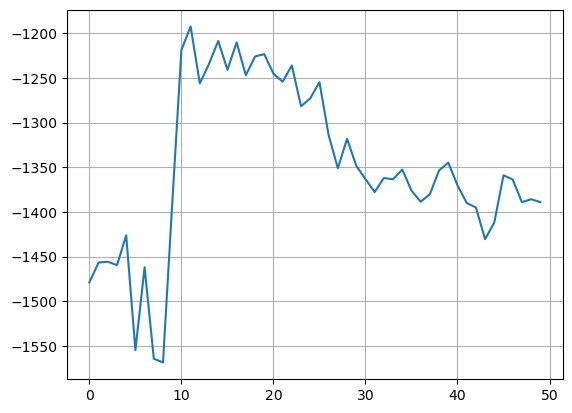

In [20]:
plt.plot(logs)
plt.grid()
plt.show()

In [22]:
agent.load('checkpoint')

In [28]:
env = gym.make("Pendulum-v1")
agent.play(env, trajectory_len)
env.close()

[-1.2319158]
[-2.]
[-2.]
[-1.2834184]
[-1.1681185]
[-2.]
[-1.3920238]
[-1.9898926]
[-0.81699467]
[-1.4956384]
[0.6117748]
[-0.5219151]
[-1.9180133]
[-1.202715]
[-1.5950601]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-0.06734395]
[-2.]
[-1.7111043]
[-2.]
[-2.]
[-1.2771101]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-1.4909405]
[-0.8446367]
[-1.0572722]
[-2.]
[-2.]
[-2.]
[-0.75744367]
[-2.]
[-1.0769415]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-1.8625629]
[-2.]
[-0.94257873]
[-1.1589174]
[-2.]
[-0.05758953]
[-1.7927494]
[-1.2458398]
[-2.]
[-1.587694]
[-1.5737832]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-1.318904]
[-1.6709852]
[-1.775238]
[-2.]
[-2.]
[-2.]
[-0.13610578]
[-2.]
[-2.]
[-1.8797878]
[-0.21033931]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-1.8553232]
[-1.7490292]
[-2.]
[-2.]
[-1.7810743]
[-2.]
[-1.5570486]
[-1.4911683]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-2.]
[-0.35838008]
[-2.]
[-2.]
[0.10349381]
[-1.9260294]
[

In [7]:
#lr = 0.7

env = gym.make('MountainCarContinuous-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

epochs = 70
trajectory_len = 500  #100
trajectory_n = 250  #500
q_param = 0.8

agent = CEM(state_dim, action_dim)

logs = agent.train(env, epochs, trajectory_len, trajectory_n, q_param)

  0%|                                                                                           | 0/70 [00:00<?, ?it/s]C:\Users\Egor\AppData\Local\Temp\ipykernel_18032\2578779861.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  elite_states = torch.FloatTensor(elite_states)
  1%|█▏                                                                               | 1/70 [01:18<1:30:23, 78.60s/it]

epoch = 0, 
 total reward = -0.13963015305767879


  3%|██▎                                                                              | 2/70 [02:30<1:24:18, 74.38s/it]

epoch = 1, 
 total reward = -0.6802712969181646


  4%|███▍                                                                             | 3/70 [03:41<1:21:20, 72.84s/it]

epoch = 2, 
 total reward = -0.13918652260656858


  6%|████▋                                                                            | 4/70 [05:00<1:23:00, 75.46s/it]

epoch = 3, 
 total reward = -0.1557019481845777


  7%|█████▊                                                                           | 5/70 [06:09<1:19:10, 73.08s/it]

epoch = 4, 
 total reward = -0.46211712700111435


  9%|██████▉                                                                          | 6/70 [07:20<1:17:19, 72.50s/it]

epoch = 5, 
 total reward = -0.5016627413809738


 10%|████████                                                                         | 7/70 [08:38<1:17:50, 74.14s/it]

epoch = 6, 
 total reward = -1.0594869526150306


 11%|█████████▎                                                                       | 8/70 [09:48<1:15:21, 72.93s/it]

epoch = 7, 
 total reward = -1.6102608859066376


 13%|██████████▍                                                                      | 9/70 [11:00<1:13:55, 72.72s/it]

epoch = 8, 
 total reward = -1.8539405593201885


 14%|███████████▍                                                                    | 10/70 [12:14<1:12:52, 72.87s/it]

epoch = 9, 
 total reward = -2.307781913963585


 16%|████████████▌                                                                   | 11/70 [13:32<1:13:14, 74.49s/it]

epoch = 10, 
 total reward = -2.571749422761581


 17%|█████████████▋                                                                  | 12/70 [14:40<1:10:19, 72.75s/it]

epoch = 11, 
 total reward = -2.2765697644661875


 19%|██████████████▊                                                                 | 13/70 [15:52<1:08:42, 72.32s/it]

epoch = 12, 
 total reward = -2.009593403033982


 20%|████████████████                                                                | 14/70 [17:06<1:07:55, 72.77s/it]

epoch = 13, 
 total reward = -1.8432033534533208


 21%|█████████████████▏                                                              | 15/70 [18:17<1:06:13, 72.24s/it]

epoch = 14, 
 total reward = -1.4943585309792302


 23%|██████████████████▎                                                             | 16/70 [19:30<1:05:12, 72.45s/it]

epoch = 15, 
 total reward = -1.0362042037099923


 24%|███████████████████▍                                                            | 17/70 [20:45<1:04:46, 73.33s/it]

epoch = 16, 
 total reward = -0.5901127824493899


 26%|████████████████████▌                                                           | 18/70 [21:56<1:02:50, 72.51s/it]

epoch = 17, 
 total reward = -0.32669742615668934


 27%|█████████████████████▋                                                          | 19/70 [23:06<1:01:04, 71.86s/it]

epoch = 18, 
 total reward = -0.19836902038241583


 29%|███████████████████████▍                                                          | 20/70 [24:17<59:35, 71.50s/it]

epoch = 19, 
 total reward = -0.12944862847854266


 30%|████████████████████████▌                                                         | 21/70 [25:33<59:41, 73.09s/it]

epoch = 20, 
 total reward = -0.044598416497714996


 31%|█████████████████████████▊                                                        | 22/70 [26:47<58:37, 73.29s/it]

epoch = 21, 
 total reward = -0.023123994817086945


 33%|██████████████████████████▉                                                       | 23/70 [27:56<56:28, 72.09s/it]

epoch = 22, 
 total reward = -0.0013807575027265826


 34%|████████████████████████████                                                      | 24/70 [29:16<56:57, 74.30s/it]

epoch = 23, 
 total reward = -0.006736612604608914


 36%|█████████████████████████████▎                                                    | 25/70 [30:28<55:13, 73.62s/it]

epoch = 24, 
 total reward = -0.052647490616040495


 37%|██████████████████████████████▍                                                   | 26/70 [31:41<53:58, 73.60s/it]

epoch = 25, 
 total reward = -0.08426780148012063


 39%|███████████████████████████████▋                                                  | 27/70 [33:02<54:10, 75.59s/it]

epoch = 26, 
 total reward = -0.10120858463758542


 40%|████████████████████████████████▊                                                 | 28/70 [34:12<51:44, 73.91s/it]

epoch = 27, 
 total reward = -0.0904009009113326


 41%|█████████████████████████████████▉                                                | 29/70 [35:23<49:55, 73.06s/it]

epoch = 28, 
 total reward = -0.08991819004234136


 43%|███████████████████████████████████▏                                              | 30/70 [36:38<49:07, 73.69s/it]

epoch = 29, 
 total reward = -0.07014771944076109


 44%|████████████████████████████████████▎                                             | 31/70 [37:51<47:43, 73.42s/it]

epoch = 30, 
 total reward = -0.05014447727434411


 46%|█████████████████████████████████████▍                                            | 32/70 [39:01<45:57, 72.58s/it]

epoch = 31, 
 total reward = -0.03809027570023507


 47%|██████████████████████████████████████▋                                           | 33/70 [40:12<44:22, 71.96s/it]

epoch = 32, 
 total reward = -0.03499833359003748


 49%|███████████████████████████████████████▊                                          | 34/70 [41:12<41:00, 68.34s/it]

epoch = 33, 
 total reward = -0.023150441630976553


 50%|█████████████████████████████████████████                                         | 35/70 [42:22<40:09, 68.84s/it]

epoch = 34, 
 total reward = -0.02214493303987674


 51%|██████████████████████████████████████████▏                                       | 36/70 [43:31<39:06, 69.03s/it]

epoch = 35, 
 total reward = -0.014815302542385105


 53%|███████████████████████████████████████████▎                                      | 37/70 [44:49<39:29, 71.80s/it]

epoch = 36, 
 total reward = -0.009227715608164058


 54%|████████████████████████████████████████████▌                                     | 38/70 [46:04<38:43, 72.60s/it]

epoch = 37, 
 total reward = -0.006114612813298443


 56%|█████████████████████████████████████████████▋                                    | 39/70 [47:16<37:25, 72.45s/it]

epoch = 38, 
 total reward = -0.0017465009451739224


 57%|██████████████████████████████████████████████▊                                   | 40/70 [48:28<36:12, 72.42s/it]

epoch = 39, 
 total reward = -0.0005926193118478205


 59%|████████████████████████████████████████████████                                  | 41/70 [49:44<35:25, 73.28s/it]

epoch = 40, 
 total reward = -0.003054300250742843


 60%|█████████████████████████████████████████████████▏                                | 42/70 [50:35<31:07, 66.70s/it]

epoch = 41, 
 total reward = -0.00966167784476684


 61%|██████████████████████████████████████████████████▎                               | 43/70 [51:45<30:26, 67.64s/it]

epoch = 42, 
 total reward = -0.02105576989459473


 63%|███████████████████████████████████████████████████▌                              | 44/70 [53:01<30:26, 70.25s/it]

epoch = 43, 
 total reward = -0.019702880577510892


 64%|████████████████████████████████████████████████████▋                             | 45/70 [54:10<29:07, 69.90s/it]

epoch = 44, 
 total reward = -0.016043552381707526


 66%|█████████████████████████████████████████████████████▉                            | 46/70 [55:21<28:04, 70.17s/it]

epoch = 45, 
 total reward = -0.00549309375480488


 67%|███████████████████████████████████████████████████████                           | 47/70 [56:31<26:50, 70.03s/it]

epoch = 46, 
 total reward = -0.00036803804210428447


 69%|████████████████████████████████████████████████████████▏                         | 48/70 [57:45<26:11, 71.42s/it]

epoch = 47, 
 total reward = -0.004116952934887327


 70%|█████████████████████████████████████████████████████████▍                        | 49/70 [58:56<24:52, 71.06s/it]

epoch = 48, 
 total reward = -0.017744163771482812


 71%|█████████████████████████████████████████████████████████▏                      | 50/70 [1:00:06<23:36, 70.83s/it]

epoch = 49, 
 total reward = -0.042312656592138564


 73%|██████████████████████████████████████████████████████████▎                     | 51/70 [1:01:25<23:10, 73.19s/it]

epoch = 50, 
 total reward = -0.06727315741272713


 74%|███████████████████████████████████████████████████████████▍                    | 52/70 [1:02:34<21:39, 72.19s/it]

epoch = 51, 
 total reward = -0.09489063123728719


 76%|████████████████████████████████████████████████████████████▌                   | 53/70 [1:03:47<20:28, 72.26s/it]

epoch = 52, 
 total reward = -0.1416177836140681


 77%|█████████████████████████████████████████████████████████████▋                  | 54/70 [1:05:07<19:52, 74.51s/it]

epoch = 53, 
 total reward = -0.19548704723117777


 79%|██████████████████████████████████████████████████████████████▊                 | 55/70 [1:06:20<18:32, 74.14s/it]

epoch = 54, 
 total reward = -0.25886939641255174


 80%|████████████████████████████████████████████████████████████████                | 56/70 [1:07:31<17:06, 73.34s/it]

epoch = 55, 
 total reward = -0.33921368682227226


 81%|█████████████████████████████████████████████████████████████████▏              | 57/70 [1:08:53<16:23, 75.67s/it]

epoch = 56, 
 total reward = -0.47913234040696034


 83%|██████████████████████████████████████████████████████████████████▎             | 58/70 [1:10:05<14:55, 74.64s/it]

epoch = 57, 
 total reward = -0.6552041863679531


 84%|███████████████████████████████████████████████████████████████████▍            | 59/70 [1:11:20<13:42, 74.77s/it]

epoch = 58, 
 total reward = -0.8428638536089925


 86%|████████████████████████████████████████████████████████████████████▌           | 60/70 [1:12:34<12:25, 74.55s/it]

epoch = 59, 
 total reward = -0.9402587741088325


 87%|█████████████████████████████████████████████████████████████████████▋          | 61/70 [1:13:49<11:11, 74.62s/it]

epoch = 60, 
 total reward = -1.0476187571507836


 89%|██████████████████████████████████████████████████████████████████████▊         | 62/70 [1:14:35<08:48, 66.09s/it]

epoch = 61, 
 total reward = -1.1826056923459216


 90%|████████████████████████████████████████████████████████████████████████        | 63/70 [1:15:47<07:54, 67.76s/it]

epoch = 62, 
 total reward = -1.268616251074171


 91%|█████████████████████████████████████████████████████████████████████████▏      | 64/70 [1:17:05<07:05, 70.89s/it]

epoch = 63, 
 total reward = -1.3541031785716013


 93%|██████████████████████████████████████████████████████████████████████████▎     | 65/70 [1:18:18<05:57, 71.54s/it]

epoch = 64, 
 total reward = -1.322316668468157


 94%|███████████████████████████████████████████████████████████████████████████▍    | 66/70 [1:19:29<04:45, 71.41s/it]

epoch = 65, 
 total reward = -1.2734632020788919


 96%|████████████████████████████████████████████████████████████████████████████▌   | 67/70 [1:20:46<03:39, 73.09s/it]

epoch = 66, 
 total reward = -1.2004216234129175


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 68/70 [1:21:58<02:25, 72.65s/it]

epoch = 67, 
 total reward = -1.12017433916267


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 69/70 [1:23:09<01:12, 72.34s/it]

epoch = 68, 
 total reward = -1.0847102831691777


100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [1:24:26<00:00, 72.38s/it]

epoch = 69, 
 total reward = -1.0732782828857947


In [ ]:
plt.plot(logs)
plt.grid()
plt.show()

In [5]:
env = gym.make('MountainCarContinuous-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

epochs = 70
trajectory_len = 500  #100
trajectory_n = 250  #500
q_param = 0.8

agent = CEM(state_dim, action_dim)

In [6]:
agent.load('checkpoint')

In [7]:
env = gym.make('MountainCarContinuous-v0')
agent.play(env, trajectory_len)
env.close()

In [5]:
#lr = 0.7

env = gym.make('MountainCarContinuous-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

epochs = 70
trajectory_len = 300  #100
trajectory_n = 500  #500
q_param = 0.8

agent = CEM(state_dim, action_dim)

logs = agent.train(env, epochs, trajectory_len, trajectory_n, q_param)

  0%|                                                                                           | 0/70 [00:00<?, ?it/s]C:\Users\Egor\AppData\Local\Temp\ipykernel_8240\1716882894.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  elite_states = torch.FloatTensor(elite_states)
  1%|█▏                                                                                 | 1/70 [00:44<50:51, 44.22s/it]

epoch = 0, 
 total reward = -0.016556149170890305


  3%|██▎                                                                                | 2/70 [01:33<53:30, 47.21s/it]

epoch = 1, 
 total reward = -0.020186190013984674


  4%|███▌                                                                               | 3/70 [02:23<54:18, 48.63s/it]

epoch = 2, 
 total reward = -0.006829323277914087


  6%|████▋                                                                              | 4/70 [03:10<52:26, 47.67s/it]

epoch = 3, 
 total reward = -0.0019015668270203866


  7%|█████▉                                                                             | 5/70 [03:58<51:51, 47.87s/it]

epoch = 4, 
 total reward = -0.0002946179146688992


  9%|███████                                                                            | 6/70 [04:50<52:35, 49.30s/it]

epoch = 5, 
 total reward = -0.09647853448281893


 10%|████████▎                                                                          | 7/70 [05:43<52:56, 50.42s/it]

epoch = 6, 
 total reward = -0.22010385097323354


 11%|█████████▍                                                                         | 8/70 [06:30<50:58, 49.33s/it]

epoch = 7, 
 total reward = -0.31802325572596274


 13%|██████████▋                                                                        | 9/70 [07:16<49:10, 48.36s/it]

epoch = 8, 
 total reward = -0.4298208225888616


 14%|███████████▋                                                                      | 10/70 [08:03<48:02, 48.04s/it]

epoch = 9, 
 total reward = -0.4686509757190973


 16%|████████████▉                                                                     | 11/70 [08:52<47:26, 48.24s/it]

epoch = 10, 
 total reward = -0.40981519580542247


 17%|██████████████                                                                    | 12/70 [09:43<47:31, 49.17s/it]

epoch = 11, 
 total reward = -0.34681570467906025


 19%|███████████████▏                                                                  | 13/70 [10:35<47:28, 49.98s/it]

epoch = 12, 
 total reward = -0.35713040875045443


 20%|████████████████▍                                                                 | 14/70 [11:26<46:58, 50.34s/it]

epoch = 13, 
 total reward = -0.3561232391207265


 21%|█████████████████▌                                                                | 15/70 [12:18<46:26, 50.67s/it]

epoch = 14, 
 total reward = -0.457542710239938


 23%|██████████████████▋                                                               | 16/70 [13:03<44:18, 49.22s/it]

epoch = 15, 
 total reward = -0.5804067785482759


 24%|███████████████████▉                                                              | 17/70 [13:48<42:22, 47.97s/it]

epoch = 16, 
 total reward = -0.7043741867500708


 26%|█████████████████████                                                             | 18/70 [14:36<41:20, 47.69s/it]

epoch = 17, 
 total reward = -0.9203174914265725


 27%|██████████████████████▎                                                           | 19/70 [15:22<40:18, 47.43s/it]

epoch = 18, 
 total reward = -1.0277573814224064


 29%|███████████████████████▍                                                          | 20/70 [16:08<39:00, 46.81s/it]

epoch = 19, 
 total reward = -1.076406696395024


 30%|████████████████████████▌                                                         | 21/70 [16:53<37:45, 46.24s/it]

epoch = 20, 
 total reward = -1.0170101539355616


 31%|█████████████████████████▊                                                        | 22/70 [17:39<36:57, 46.20s/it]

epoch = 21, 
 total reward = -0.9539918530531398


 33%|██████████████████████████▉                                                       | 23/70 [18:25<36:19, 46.36s/it]

epoch = 22, 
 total reward = -0.8807776454989843


 34%|████████████████████████████                                                      | 24/70 [19:13<35:51, 46.77s/it]

epoch = 23, 
 total reward = -0.8271937426750594


 36%|█████████████████████████████▎                                                    | 25/70 [19:59<34:45, 46.34s/it]

epoch = 24, 
 total reward = -0.8247309032076181


 37%|██████████████████████████████▍                                                   | 26/70 [20:46<34:08, 46.56s/it]

epoch = 25, 
 total reward = -0.8017173783338815


 39%|███████████████████████████████▋                                                  | 27/70 [21:32<33:18, 46.48s/it]

epoch = 26, 
 total reward = -0.8110632462068034


 40%|████████████████████████████████▊                                                 | 28/70 [22:18<32:31, 46.47s/it]

epoch = 27, 
 total reward = -0.8812837246718961


 41%|█████████████████████████████████▉                                                | 29/70 [23:11<33:01, 48.34s/it]

epoch = 28, 
 total reward = -0.8827808081912595


 43%|███████████████████████████████████▏                                              | 30/70 [24:03<32:57, 49.43s/it]

epoch = 29, 
 total reward = -0.9301336956248404


 44%|████████████████████████████████████▎                                             | 31/70 [24:53<32:19, 49.74s/it]

epoch = 30, 
 total reward = -1.0484535048389252


 46%|█████████████████████████████████████▍                                            | 32/70 [25:41<31:06, 49.13s/it]

epoch = 31, 
 total reward = -1.097043064787655


 47%|██████████████████████████████████████▋                                           | 33/70 [26:27<29:41, 48.14s/it]

epoch = 32, 
 total reward = -1.1546807635583816


 49%|███████████████████████████████████████▊                                          | 34/70 [27:13<28:29, 47.49s/it]

epoch = 33, 
 total reward = -1.2236713741525704


 50%|█████████████████████████████████████████                                         | 35/70 [27:59<27:25, 47.02s/it]

epoch = 34, 
 total reward = -1.2748025804801832


 51%|██████████████████████████████████████████▏                                       | 36/70 [28:50<27:21, 48.29s/it]

epoch = 35, 
 total reward = -1.2553870472973758


 53%|███████████████████████████████████████████▎                                      | 37/70 [29:40<26:51, 48.82s/it]

epoch = 36, 
 total reward = -1.3023006527381222


 54%|████████████████████████████████████████████▌                                     | 38/70 [30:32<26:27, 49.60s/it]

epoch = 37, 
 total reward = -1.3659017370895037


 56%|█████████████████████████████████████████████▋                                    | 39/70 [31:20<25:24, 49.18s/it]

epoch = 38, 
 total reward = -1.4428128300289145


 57%|██████████████████████████████████████████████▊                                   | 40/70 [32:11<24:57, 49.91s/it]

epoch = 39, 
 total reward = -1.6026695847813053


 59%|████████████████████████████████████████████████                                  | 41/70 [33:04<24:30, 50.71s/it]

epoch = 40, 
 total reward = -1.651638112126773


 60%|█████████████████████████████████████████████████▏                                | 42/70 [33:57<23:56, 51.32s/it]

epoch = 41, 
 total reward = -1.7367358497125847


 61%|██████████████████████████████████████████████████▎                               | 43/70 [34:46<22:47, 50.66s/it]

epoch = 42, 
 total reward = -1.906789659760439


 63%|███████████████████████████████████████████████████▌                              | 44/70 [35:35<21:42, 50.11s/it]

epoch = 43, 
 total reward = -1.9876966052417269


 64%|████████████████████████████████████████████████████▋                             | 45/70 [36:30<21:29, 51.58s/it]

epoch = 44, 
 total reward = -2.0678917177510057


 66%|█████████████████████████████████████████████████████▉                            | 46/70 [37:19<20:23, 50.99s/it]

epoch = 45, 
 total reward = -2.1272018037952907


 67%|███████████████████████████████████████████████████████                           | 47/70 [38:11<19:36, 51.17s/it]

epoch = 46, 
 total reward = -2.1044958988893963


 69%|████████████████████████████████████████████████████████▏                         | 48/70 [39:02<18:47, 51.26s/it]

epoch = 47, 
 total reward = -2.1459906481616247


 70%|█████████████████████████████████████████████████████████▍                        | 49/70 [39:53<17:53, 51.13s/it]

epoch = 48, 
 total reward = -2.208972652708785


 71%|██████████████████████████████████████████████████████████▌                       | 50/70 [40:40<16:36, 49.83s/it]

epoch = 49, 
 total reward = -2.2994157316540202


 73%|███████████████████████████████████████████████████████████▋                      | 51/70 [41:30<15:49, 49.98s/it]

epoch = 50, 
 total reward = -2.3201942864955956


 74%|████████████████████████████████████████████████████████████▉                     | 52/70 [42:20<14:58, 49.91s/it]

epoch = 51, 
 total reward = -2.3218196508491107


 76%|██████████████████████████████████████████████████████████████                    | 53/70 [43:07<13:53, 49.04s/it]

epoch = 52, 
 total reward = -2.292332083172623


 77%|███████████████████████████████████████████████████████████████▎                  | 54/70 [43:53<12:50, 48.18s/it]

epoch = 53, 
 total reward = -2.2256033603389977


 79%|████████████████████████████████████████████████████████████████▍                 | 55/70 [44:43<12:11, 48.76s/it]

epoch = 54, 
 total reward = -2.171430816762033


 80%|█████████████████████████████████████████████████████████████████▌                | 56/70 [45:36<11:37, 49.79s/it]

epoch = 55, 
 total reward = -2.151070141021781


 81%|██████████████████████████████████████████████████████████████████▊               | 57/70 [46:29<11:02, 50.98s/it]

epoch = 56, 
 total reward = -2.1109180153648603


 83%|███████████████████████████████████████████████████████████████████▉              | 58/70 [47:22<10:18, 51.53s/it]

epoch = 57, 
 total reward = -2.0413597581410485


 84%|█████████████████████████████████████████████████████████████████████             | 59/70 [48:14<09:29, 51.73s/it]

epoch = 58, 
 total reward = -2.035300190126602


 86%|██████████████████████████████████████████████████████████████████████▎           | 60/70 [49:04<08:30, 51.02s/it]

epoch = 59, 
 total reward = -2.1034623763966236


 87%|███████████████████████████████████████████████████████████████████████▍          | 61/70 [49:51<07:28, 49.86s/it]

epoch = 60, 
 total reward = -2.1930351573487714


 89%|████████████████████████████████████████████████████████████████████████▋         | 62/70 [50:41<06:40, 50.04s/it]

epoch = 61, 
 total reward = -2.375953597824163


 90%|█████████████████████████████████████████████████████████████████████████▊        | 63/70 [51:35<05:58, 51.16s/it]

epoch = 62, 
 total reward = -2.5046435711125863


 91%|██████████████████████████████████████████████████████████████████████████▉       | 64/70 [52:30<05:13, 52.32s/it]

epoch = 63, 
 total reward = -2.599240014532259


 93%|████████████████████████████████████████████████████████████████████████████▏     | 65/70 [53:19<04:16, 51.36s/it]

epoch = 64, 
 total reward = -2.5074983966436766


 94%|█████████████████████████████████████████████████████████████████████████████▎    | 66/70 [54:06<03:19, 49.92s/it]

epoch = 65, 
 total reward = -2.489944431867534


 96%|██████████████████████████████████████████████████████████████████████████████▍   | 67/70 [54:51<02:25, 48.53s/it]

epoch = 66, 
 total reward = -2.5658864917584303


 97%|███████████████████████████████████████████████████████████████████████████████▋  | 68/70 [55:37<01:35, 47.67s/it]

epoch = 67, 
 total reward = -2.7074668001163396


 99%|████████████████████████████████████████████████████████████████████████████████▊ | 69/70 [56:23<00:47, 47.22s/it]

epoch = 68, 
 total reward = -2.93182664906496


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [57:09<00:00, 49.00s/it]

epoch = 69, 
 total reward = -3.182994624278677


In [ ]:
plt.plot(logs)
plt.grid()
plt.show()

In [20]:
env = gym.make('MountainCarContinuous-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

epochs = 55
trajectory_len = 500  #100
trajectory_n = 250  #500
q_param = 0.8

agent = CEM(state_dim, action_dim)

logs = agent.train(env, epochs, trajectory_len, trajectory_n, q_param)

  2%|█▌                                                                                 | 1/55 [00:53<48:18, 53.68s/it]

epoch = 0, 
 total reward = -0.7626958895404048


  4%|███                                                                                | 2/55 [02:00<54:28, 61.67s/it]

epoch = 1, 
 total reward = -0.7492128044048504


  5%|████▌                                                                              | 3/55 [02:57<51:15, 59.15s/it]

epoch = 2, 
 total reward = -0.7378543366068157


  7%|██████                                                                             | 4/55 [04:00<51:35, 60.70s/it]

epoch = 3, 
 total reward = -0.727670634031356


  9%|███████▌                                                                           | 5/55 [04:53<48:27, 58.14s/it]

epoch = 4, 
 total reward = -0.7199544086840378


 11%|█████████                                                                          | 6/55 [05:57<48:57, 59.94s/it]

epoch = 5, 
 total reward = -0.7137589633535896


 13%|██████████▌                                                                        | 7/55 [06:57<48:04, 60.09s/it]

epoch = 6, 
 total reward = -0.7079645955216682


 15%|████████████                                                                       | 8/55 [08:00<47:50, 61.07s/it]

epoch = 7, 
 total reward = -0.7036142897317942


 16%|█████████████▌                                                                     | 9/55 [08:57<45:45, 59.68s/it]

epoch = 8, 
 total reward = -0.7008277673690114


 18%|██████████████▉                                                                   | 10/55 [10:12<48:20, 64.47s/it]

epoch = 9, 
 total reward = -0.6984971406619486


 20%|████████████████▍                                                                 | 11/55 [11:21<48:12, 65.73s/it]

epoch = 10, 
 total reward = -0.6967462999290572


 22%|█████████████████▉                                                                | 12/55 [12:21<45:53, 64.04s/it]

epoch = 11, 
 total reward = -0.6972844391535472


 24%|███████████████████▍                                                              | 13/55 [13:02<39:58, 57.12s/it]

epoch = 12, 
 total reward = -0.6957175162064063


 25%|████████████████████▊                                                             | 14/55 [14:14<42:07, 61.64s/it]

epoch = 13, 
 total reward = -0.6929528248424363


 27%|██████████████████████▎                                                           | 15/55 [15:17<41:18, 61.96s/it]

epoch = 14, 
 total reward = -0.6906869080523772


 29%|███████████████████████▊                                                          | 16/55 [16:21<40:38, 62.52s/it]

epoch = 15, 
 total reward = -0.6887471082542466


 31%|█████████████████████████▎                                                        | 17/55 [17:19<38:48, 61.27s/it]

epoch = 16, 
 total reward = -0.6883115484775053


 33%|██████████████████████████▊                                                       | 18/55 [17:59<33:47, 54.81s/it]

epoch = 17, 
 total reward = -0.6880691144522856


 35%|████████████████████████████▎                                                     | 19/55 [19:03<34:32, 57.58s/it]

epoch = 18, 
 total reward = -0.68726731164118


 36%|█████████████████████████████▊                                                    | 20/55 [20:06<34:29, 59.13s/it]

epoch = 19, 
 total reward = -0.6881534994546207


 38%|███████████████████████████████▎                                                  | 21/55 [21:02<33:01, 58.28s/it]

epoch = 20, 
 total reward = -0.689896956428313


 40%|████████████████████████████████▊                                                 | 22/55 [22:14<34:19, 62.40s/it]

epoch = 21, 
 total reward = -0.6910137973688604


 42%|██████████████████████████████████▎                                               | 23/55 [23:19<33:42, 63.21s/it]

epoch = 22, 
 total reward = -0.6907283984183875


 44%|███████████████████████████████████▊                                              | 24/55 [24:23<32:42, 63.31s/it]

epoch = 23, 
 total reward = -0.6905834662094431


 45%|█████████████████████████████████████▎                                            | 25/55 [25:06<28:37, 57.24s/it]

epoch = 24, 
 total reward = -0.6908220357933089


 45%|█████████████████████████████████████▎                                            | 25/55 [26:05<31:18, 62.60s/it]


KeyboardInterrupt: 

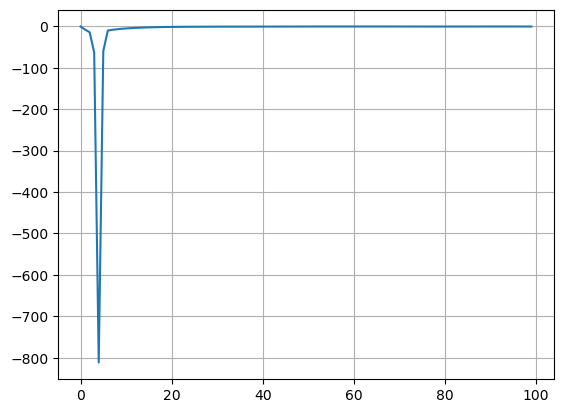

In [52]:
plt.plot(logs)
plt.grid()
plt.show()

In [53]:
env = gym.make('MountainCarContinuous-v0')
agent.play(env, trajectory_len)
env.close()